In [13]:
import logging
import math
import re
import os
from dataclasses import dataclass, field
from typing import Optional

import torch
import transformers
from torch.nn import functional as F
import json

from peft import PeftModel, LoraConfig, TaskType
from datasets import load_dataset
from safetensors.torch import load_file

import numpy as np

from src.model import CODI, ModelArguments, DataArguments as OriginalDataArguments, TrainingArguments

@dataclass
class DataArguments(OriginalDataArguments):
    data_path: Optional[str] = field(
        default=None, metadata={"help": "(Unused) Path to the local training or evaluation file."}
    )

do_print = True
probe_topk = 5
test_attention = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

captured_attentions = []

def get_attention_hook(module, input, output):
    if isinstance(output, tuple) and len(output) > 1 and output[1] is not None:
        attention_weights = output[1].clone().detach().cpu()
        captured_attentions.append(attention_weights)

def extract_answer_number(sentence: str) -> float:
    sentence = sentence.replace(',', '')
    pred = [s for s in re.findall(r'-?\d+\.?\d*', sentence)]
    if not pred:
        return float('inf')
    return float(pred[-1])

def compute_accuracy(gold: list, pred: list):
    acc = sum(p == g for p, g in zip(pred, gold))
    return acc / len(gold)

def evaluation(model_args, data_args, training_args):
    task_type = TaskType.CAUSAL_LM
    target_modules = ["c_attn", "c_proj", "c_fc"]
    lora_config = LoraConfig(
        task_type=task_type,
        inference_mode=False,
        r=model_args.lora_r,
        lora_alpha=model_args.lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
        init_lora_weights=True,
    )

    model = CODI(model_args, training_args, lora_config)

    try:
        state_dict = load_file(os.path.join(model_args.ckpt_dir, "model.safetensors"))
    except Exception:
        state_dict = torch.load(os.path.join(model_args.ckpt_dir, "pytorch_model.bin"))
    model.load_state_dict(state_dict, strict=False)
    model.codi.tie_weights()

    for layer in model.codi.transformer.h:
        layer.attn.register_forward_hook(get_attention_hook)

    tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_args.model_name_or_path,
        token=model_args.token,
        model_max_length=training_args.model_max_length,
        padding_side="left",
        use_fast=False,
    )

    if tokenizer.pad_token_id is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        tokenizer.pad_token_id = model.pad_token_id or tokenizer.convert_tokens_to_ids('[PAD]')

    model = model.to(device).to(torch.bfloat16)

    dataset = load_dataset("gsm8k", "main")
    test_set = dataset['test']

    question = [ex['question'].strip() for ex in test_set]
    answer = [float(re.findall(r'-?\d+\.?\d*', ex["answer"].replace(',', ''))[-1]) for ex in test_set]

    eval_step = math.ceil(len(question) / data_args.batch_size)
    question_data = []
    for i in range(eval_step):
        start_idx = i * data_args.batch_size
        end_idx = (i + 1) * data_args.batch_size
        batch_questions = question[start_idx:end_idx]
        batch = tokenizer(batch_questions, return_tensors="pt", padding="longest")

        if training_args.remove_eos:
            bot_tensor = torch.tensor([model.bot_id], dtype=torch.long).expand(batch["input_ids"].size(0), 1)
        else:
            bot_tensor = torch.tensor([tokenizer.eos_token_id, model.bot_id], dtype=torch.long).expand(batch["input_ids"].size(0), 2)

        batch["input_ids"] = torch.cat((batch["input_ids"], bot_tensor), dim=1)
        batch["attention_mask"] = torch.cat((batch["attention_mask"], torch.ones_like(bot_tensor)), dim=1)
        question_data.append(batch.to(device))

    model.eval()
    gen_kwargs = {"max_new_tokens": 256, "temperature": 0.1, "top_k": 40, "top_p": 0.95, "do_sample": True}

    ans_pred_list = []
    len_cot = []
    phase1_data_collection = []
    all_question_attentions = []
    num_layers = model.codi.config.num_hidden_layers
    num_heads = model.codi.config.num_attention_heads
    max_seq_len = training_args.model_max_length
    num_latent_steps = training_args.inf_latent_iterations

    for step, batch in enumerate(question_data):
        batch_size = batch["input_ids"].size(0)
        batch_attention_holder = torch.zeros(batch_size, num_latent_steps, num_layers, num_heads, max_seq_len, dtype=torch.bfloat16, device='cpu')
        batch_latent_data = [[] for _ in range(batch_size)]

        with torch.no_grad():
            outputs = model.codi(input_ids=batch["input_ids"], use_cache=True, output_hidden_states=True, past_key_values=None, attention_mask=batch["attention_mask"], output_attentions=True)
            past_key_values = outputs.past_key_values
            latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)

            if training_args.use_prj:
                latent_embd = model.prj(latent_embd)

            for i in range(training_args.inf_latent_iterations):
                captured_attentions.clear()
                outputs = model.codi(inputs_embeds=latent_embd, use_cache=True, output_hidden_states=True, past_key_values=past_key_values, output_attentions=True)

                for layer_idx, layer_attention_weights in enumerate(captured_attentions):
                    squeezed_weights = layer_attention_weights.squeeze(2)
                    current_seq_len = squeezed_weights.shape[-1]
                    batch_attention_holder[:, i, layer_idx, :, :current_seq_len] = squeezed_weights.to(torch.bfloat16)

                past_key_values = outputs.past_key_values
                current_latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)
                probs = torch.nn.functional.softmax(model.codi.lm_head(current_latent_embd), dim=-1)
                _, top5_indices = torch.topk(probs, k=probe_topk, dim=2)

                for b_idx in range(batch_size):
                    token_probs = probs[b_idx, 0, top5_indices[b_idx, 0]].detach().cpu().tolist()
                    decoded_top5 = [
                        (tokenizer.decode([tok_id]), float(prob))
                        for tok_id, prob in zip(top5_indices[b_idx, 0], token_probs)
                    ]
                    batch_latent_data[b_idx].append({
                        "latent_token_index": i,
                        "latent_token_tensor": current_latent_embd[b_idx].clone().detach().cpu(),
                        "decoded_intermediate_output": decoded_top5
                    })

                latent_embd = current_latent_embd
                if training_args.use_prj:
                    latent_embd = model.prj(latent_embd)

            all_question_attentions.extend(list(torch.unbind(batch_attention_holder, dim=0)))

            eot_emb = model.get_embd(model.codi, model.model_name)(
                torch.tensor([model.eot_id], dtype=torch.long, device=device)).unsqueeze(0).expand(batch_size, -1, -1)

            finished = torch.zeros(batch_size, dtype=torch.bool, device=device)
            pred_tokens = [[] for _ in range(batch_size)]

            for _ in range(gen_kwargs["max_new_tokens"]):
                out = model.codi(inputs_embeds=eot_emb, use_cache=True, past_key_values=past_key_values)
                past_key_values = out.past_key_values
                logits = out.logits[:, -1, :model.codi.config.vocab_size-1]
                next_token_ids = torch.argmax(logits, dim=-1) if training_args.greedy else torch.multinomial(F.softmax(logits / gen_kwargs["temperature"], dim=-1), num_samples=1).squeeze(-1)

                for b in range(batch_size):
                    if not finished[b]:
                        token_id = next_token_ids[b].item()
                        pred_tokens[b].append(token_id)
                        if token_id == tokenizer.eos_token_id:
                            finished[b] = True

                if finished.all():
                    break

                eot_emb = model.get_embd(model.codi, model.model_name)(next_token_ids).unsqueeze(1)

            for mini_step, pred_token in enumerate(pred_tokens):
                len_cot.append(len(pred_token))
                decoded_pred = tokenizer.decode(pred_token, skip_special_tokens=True)
                current_question_idx = step * data_args.batch_size + mini_step
                pred_answer = extract_answer_number(decoded_pred)
                ans_pred_list.append(pred_answer)

                phase1_data_collection.append({
                    "question_id": current_question_idx,
                    "question_text": question[current_question_idx],
                    "ground_truth_answer": answer[current_question_idx],
                    "model_prediction_text": decoded_pred,
                    "model_prediction_answer": pred_answer,
                    "latent_data": batch_latent_data[mini_step]
                })

    final_attention_tensor = torch.stack(all_question_attentions, dim=0)
    torch.save(final_attention_tensor, "gsm8k_attention_weights.pt")
    print("✅ Saved attention weights to gsm8k_attention_weights.pt")

    def convert_tensors_to_lists(data):
        if isinstance(data, list):
            return [convert_tensors_to_lists(item) for item in data]
        elif isinstance(data, dict):
            return {key: convert_tensors_to_lists(value) for key, value in data.items()}
        elif isinstance(data, torch.Tensor):
            return data.detach().cpu().tolist()
        return data

    with open("gsm8k_phase1_data_collection.json", "w") as f:
        json.dump(convert_tensors_to_lists(phase1_data_collection), f, indent=2)

    accuracy = compute_accuracy(answer, ans_pred_list)
    print(f"✅ GSM8K accuracy: {accuracy * 100:.2f}%")
    print(f"📏 Average generated answer length: {sum(len_cot)/len(len_cot):.2f} tokens")
    return accuracy

if __name__ == "__main__":
    parser = transformers.HfArgumentParser((ModelArguments, DataArguments, TrainingArguments))
    args = [
        "--output_dir", "outputs/probe_latent_results",
        "--model_name_or_path", "gpt2",
        "--seed", "11",
        "--model_max_length", "512",
        "--bf16",
        "--lora_r", "128",
        "--lora_alpha", "32",
        "--lora_init",
        "--batch_size", "32",
        "--greedy", "True",
        "--num_latent", "6",
        "--use_prj", "True",
        "--prj_dim", "768",
        "--prj_no_ln", "False",
        "--prj_dropout", "0.0",
        "--inf_latent_iterations", "6",
        "--inf_num_iterations", "1",
        "--remove_eos", "True",
        "--use_lora", "True",
        "--ckpt_dir", "CODI-gpt2"
    ]
    model_args, data_args, training_args = parser.parse_args_into_dataclasses(args)

    accuracy = evaluation(model_args, data_args, training_args)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 20057088 || all params: 144499200 || trainable%: 13.880414562848792
✅ Saved attention weights to gsm8k_attention_weights.pt
✅ GSM8K accuracy: 18.50%
📏 Average generated answer length: 6.15 tokens


In [36]:
import json
import re
import torch
import numpy as np
import random
from tqdm import tqdm

# --- Config ---
TOP_HEADS = [
    (9, 7), (9, 2), (10, 2), (10, 3), (10, 10),
    (9, 9), (10, 7), (1, 2), (1, 7), (4, 5)
]
NUM_RANDOM_SETS = 1000
NUM_HEADS = 10
NUM_LATENTS = 6
FIXED_SEQ_LEN = 64
DATA_PATH = "gsm8k_phase1_data_collection.json"
ATTN_CONTRIB_TENSOR_PATH = "gsm8k_attention_weights.pt"

# --- Utility ---
def is_number(token: str):
    return bool(re.match(r"^-?\d+(\.\d+)?$", token.strip()))

def extract_features(attn_tensor, data, head_set):
    features = []
    labels = []
    for q_idx, example in tqdm(enumerate(data), total=len(data), desc="🔁 Extracting"):
        for latent_step in range(NUM_LATENTS):
            try:
                decoded_probs = example["latent_data"][latent_step]["decoded_intermediate_output"]
                if not isinstance(decoded_probs[0], (list, tuple)) or len(decoded_probs[0]) != 2:
                    raise ValueError("Expected (token, prob) tuples.")

                numeric_score = sum(prob for tok, prob in decoded_probs if is_number(tok))

                head_vectors = []
                for layer, head in head_set:
                    contrib = attn_tensor[q_idx, latent_step, layer, head, :].float()
                    if contrib.shape[0] < FIXED_SEQ_LEN:
                        padded = torch.nn.functional.pad(contrib, (0, FIXED_SEQ_LEN - contrib.shape[0]))
                    else:
                        padded = contrib[:FIXED_SEQ_LEN]
                    head_vectors.append(padded)

                feature_vector = torch.cat(head_vectors).numpy()
                features.append(feature_vector)
                labels.append(numeric_score)

            except Exception as e:
                print(f"❗ Skipping q{q_idx} step {latent_step}: {e}")
                continue

    return np.array(features), np.array(labels)

# --- Load Inputs ---
print("📦 Loading...")
with open(DATA_PATH, "r") as f:
    data = json.load(f)
attn_tensor = torch.load(ATTN_CONTRIB_TENSOR_PATH, map_location="cpu")
print(f"✅ Attention tensor shape: {attn_tensor.shape}")
print(f"✅ Loaded {len(data)} examples")

# --- Hand-picked ---
print("\n🎯 Extracting features from TOP_HEADS...")
top_features, top_labels = extract_features(attn_tensor, data, TOP_HEADS)
np.save("probe_features_top.npy", top_features)
np.save("probe_labels.npy", top_labels)  # same for all
print(f"✅ Saved top features: {top_features.shape}")

# --- Random Sets ---
ALL_HEADS = [(l, h) for l in range(12) for h in range(12)]

for i in range(NUM_RANDOM_SETS):
    random_heads = random.sample(ALL_HEADS, NUM_HEADS)
    print(f"\n🎲 Random Set {i+1}/{NUM_RANDOM_SETS}: {random_heads}")
    rand_feats, _ = extract_features(attn_tensor, data, random_heads)
    np.save(f"probe_features_rand_{i:03d}.npy", rand_feats)

print("\n✅ All feature sets saved.")


📦 Loading...
✅ Attention tensor shape: torch.Size([1319, 6, 12, 12, 512])
✅ Loaded 1319 examples

🎯 Extracting features from TOP_HEADS...


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 783.57it/s]


✅ Saved top features: (7914, 640)

🎲 Random Set 1/1000: [(2, 7), (2, 5), (5, 8), (7, 3), (9, 4), (1, 9), (7, 5), (5, 11), (10, 0), (8, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.39it/s]



🎲 Random Set 2/1000: [(3, 11), (4, 3), (9, 6), (0, 2), (8, 5), (1, 11), (6, 11), (0, 0), (3, 10), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.75it/s]



🎲 Random Set 3/1000: [(4, 1), (1, 4), (8, 5), (5, 7), (5, 3), (6, 8), (1, 6), (10, 11), (8, 3), (9, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 765.83it/s]



🎲 Random Set 4/1000: [(9, 5), (5, 2), (1, 1), (11, 3), (11, 5), (9, 0), (3, 0), (5, 10), (0, 9), (8, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 757.31it/s]



🎲 Random Set 5/1000: [(8, 1), (5, 5), (3, 10), (8, 6), (5, 6), (4, 7), (4, 5), (2, 7), (10, 8), (9, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.96it/s]



🎲 Random Set 6/1000: [(3, 2), (6, 5), (9, 6), (0, 9), (11, 2), (7, 9), (3, 3), (4, 1), (4, 7), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.57it/s]



🎲 Random Set 7/1000: [(9, 9), (3, 8), (7, 9), (3, 4), (1, 1), (6, 7), (3, 1), (3, 11), (0, 0), (10, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.41it/s]



🎲 Random Set 8/1000: [(10, 11), (8, 9), (1, 2), (6, 4), (9, 6), (0, 9), (3, 1), (1, 1), (8, 7), (8, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.39it/s]



🎲 Random Set 9/1000: [(1, 4), (6, 11), (4, 11), (0, 9), (11, 11), (0, 3), (4, 9), (1, 8), (3, 11), (9, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.38it/s]



🎲 Random Set 10/1000: [(4, 10), (6, 11), (3, 0), (10, 10), (0, 10), (5, 3), (3, 2), (8, 2), (11, 2), (6, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 760.82it/s]



🎲 Random Set 11/1000: [(3, 7), (3, 0), (4, 1), (10, 8), (4, 5), (7, 5), (10, 2), (0, 0), (1, 6), (3, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 777.68it/s]



🎲 Random Set 12/1000: [(3, 10), (8, 0), (8, 3), (9, 9), (7, 6), (8, 6), (1, 5), (4, 8), (1, 11), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 782.59it/s]



🎲 Random Set 13/1000: [(9, 6), (0, 9), (6, 10), (2, 8), (0, 6), (10, 7), (9, 2), (5, 9), (10, 8), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:02<00:00, 605.46it/s]



🎲 Random Set 14/1000: [(0, 2), (0, 8), (7, 3), (2, 8), (0, 10), (6, 9), (10, 11), (0, 6), (6, 5), (6, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.66it/s]



🎲 Random Set 15/1000: [(8, 5), (6, 11), (2, 5), (6, 10), (4, 2), (8, 11), (7, 2), (5, 2), (2, 4), (5, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.93it/s]



🎲 Random Set 16/1000: [(0, 0), (6, 3), (6, 1), (10, 5), (8, 3), (5, 2), (10, 9), (11, 2), (0, 4), (0, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.64it/s]



🎲 Random Set 17/1000: [(5, 7), (10, 4), (1, 8), (2, 1), (6, 1), (11, 5), (8, 3), (4, 0), (1, 11), (10, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 733.46it/s]



🎲 Random Set 18/1000: [(0, 9), (10, 8), (0, 11), (0, 5), (3, 4), (7, 3), (7, 4), (9, 10), (0, 0), (11, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.51it/s]



🎲 Random Set 19/1000: [(8, 3), (10, 5), (6, 2), (6, 7), (9, 10), (10, 11), (6, 6), (7, 10), (3, 3), (2, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.48it/s]



🎲 Random Set 20/1000: [(8, 5), (4, 11), (0, 1), (9, 2), (5, 2), (3, 6), (6, 5), (2, 2), (9, 11), (5, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.50it/s]



🎲 Random Set 21/1000: [(11, 1), (3, 10), (7, 3), (7, 0), (5, 11), (6, 6), (11, 7), (0, 8), (0, 3), (11, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.42it/s]



🎲 Random Set 22/1000: [(0, 8), (0, 1), (8, 8), (6, 9), (9, 10), (2, 6), (2, 2), (5, 3), (4, 8), (0, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.81it/s]



🎲 Random Set 23/1000: [(6, 9), (0, 3), (9, 3), (0, 9), (6, 5), (2, 2), (0, 10), (3, 4), (5, 0), (7, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 773.99it/s]



🎲 Random Set 24/1000: [(3, 4), (0, 5), (5, 8), (9, 11), (1, 8), (6, 2), (0, 7), (6, 11), (5, 1), (9, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 743.72it/s]



🎲 Random Set 25/1000: [(5, 0), (4, 2), (9, 1), (11, 8), (3, 0), (11, 7), (0, 4), (3, 2), (9, 11), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.95it/s]



🎲 Random Set 26/1000: [(0, 0), (9, 0), (7, 8), (9, 10), (11, 8), (7, 5), (9, 2), (8, 9), (10, 7), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 815.46it/s]



🎲 Random Set 27/1000: [(7, 0), (8, 1), (0, 8), (7, 2), (8, 8), (2, 7), (11, 11), (8, 9), (5, 4), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.83it/s]



🎲 Random Set 28/1000: [(8, 0), (3, 2), (4, 4), (2, 4), (4, 10), (2, 0), (8, 6), (8, 4), (1, 10), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.42it/s]



🎲 Random Set 29/1000: [(5, 3), (3, 7), (0, 8), (10, 1), (2, 9), (2, 3), (9, 8), (9, 4), (1, 11), (8, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.76it/s]



🎲 Random Set 30/1000: [(4, 2), (10, 3), (7, 9), (6, 2), (5, 0), (8, 2), (0, 7), (9, 8), (7, 11), (4, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.79it/s]



🎲 Random Set 31/1000: [(11, 7), (3, 0), (2, 7), (3, 4), (0, 3), (2, 8), (10, 0), (2, 4), (7, 6), (4, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.37it/s]



🎲 Random Set 32/1000: [(2, 7), (0, 10), (11, 3), (10, 0), (10, 9), (6, 0), (2, 0), (4, 0), (4, 8), (6, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.26it/s]



🎲 Random Set 33/1000: [(7, 2), (3, 10), (2, 1), (10, 5), (9, 8), (9, 9), (7, 10), (2, 8), (9, 7), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.49it/s]



🎲 Random Set 34/1000: [(0, 9), (2, 6), (9, 0), (9, 10), (4, 1), (11, 11), (8, 7), (6, 7), (9, 2), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.02it/s]



🎲 Random Set 35/1000: [(1, 9), (9, 10), (7, 2), (1, 2), (4, 2), (5, 4), (8, 4), (9, 9), (1, 11), (6, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 770.00it/s]



🎲 Random Set 36/1000: [(1, 1), (11, 1), (8, 2), (7, 1), (0, 7), (1, 8), (6, 9), (7, 2), (10, 10), (2, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.25it/s]



🎲 Random Set 37/1000: [(3, 11), (5, 0), (7, 0), (10, 11), (9, 0), (4, 7), (11, 6), (10, 1), (8, 4), (3, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 769.36it/s]



🎲 Random Set 38/1000: [(1, 11), (1, 5), (3, 6), (8, 10), (8, 5), (5, 10), (8, 0), (0, 4), (8, 4), (4, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 773.97it/s]



🎲 Random Set 39/1000: [(6, 1), (3, 1), (3, 8), (4, 0), (10, 10), (5, 6), (8, 2), (2, 9), (10, 3), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.80it/s]



🎲 Random Set 40/1000: [(8, 1), (8, 4), (7, 10), (3, 4), (5, 11), (8, 2), (6, 10), (11, 7), (9, 6), (7, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 782.29it/s]



🎲 Random Set 41/1000: [(8, 8), (5, 11), (11, 11), (4, 5), (9, 8), (3, 9), (3, 4), (5, 0), (5, 2), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.09it/s]



🎲 Random Set 42/1000: [(9, 1), (10, 11), (6, 8), (4, 2), (4, 3), (2, 8), (3, 1), (1, 0), (0, 7), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 786.45it/s]



🎲 Random Set 43/1000: [(9, 4), (11, 0), (6, 5), (11, 9), (0, 3), (7, 2), (1, 3), (2, 5), (7, 6), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.63it/s]



🎲 Random Set 44/1000: [(8, 10), (10, 10), (7, 11), (8, 5), (6, 0), (4, 0), (7, 3), (11, 6), (10, 4), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 771.79it/s]



🎲 Random Set 45/1000: [(6, 6), (0, 8), (9, 1), (5, 0), (0, 9), (11, 10), (11, 11), (9, 3), (1, 9), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.97it/s]



🎲 Random Set 46/1000: [(11, 6), (9, 10), (6, 4), (10, 10), (11, 2), (3, 5), (9, 2), (7, 0), (7, 10), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.79it/s]



🎲 Random Set 47/1000: [(0, 2), (0, 4), (2, 9), (1, 6), (8, 6), (0, 3), (8, 0), (8, 1), (10, 3), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.91it/s]



🎲 Random Set 48/1000: [(11, 5), (4, 0), (11, 8), (2, 8), (8, 1), (8, 6), (3, 10), (2, 9), (0, 6), (8, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.92it/s]



🎲 Random Set 49/1000: [(5, 6), (5, 3), (0, 8), (10, 3), (4, 6), (11, 0), (6, 2), (7, 10), (0, 7), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.28it/s]



🎲 Random Set 50/1000: [(0, 6), (3, 9), (7, 8), (7, 6), (1, 4), (7, 7), (10, 10), (2, 10), (4, 3), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 768.50it/s]



🎲 Random Set 51/1000: [(11, 1), (5, 9), (6, 11), (8, 5), (5, 2), (10, 10), (10, 1), (9, 6), (8, 0), (10, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.22it/s]



🎲 Random Set 52/1000: [(0, 10), (0, 0), (2, 6), (3, 9), (5, 7), (2, 3), (4, 0), (10, 0), (1, 4), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.13it/s]



🎲 Random Set 53/1000: [(3, 11), (0, 7), (10, 3), (11, 3), (11, 10), (2, 3), (8, 5), (1, 1), (5, 9), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 815.88it/s]



🎲 Random Set 54/1000: [(0, 9), (2, 8), (9, 3), (5, 1), (2, 2), (3, 1), (6, 2), (0, 6), (6, 8), (10, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.27it/s]



🎲 Random Set 55/1000: [(5, 8), (4, 1), (10, 9), (10, 3), (10, 8), (5, 4), (4, 10), (2, 8), (1, 1), (6, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 777.93it/s]



🎲 Random Set 56/1000: [(0, 9), (10, 5), (5, 11), (7, 5), (10, 3), (4, 11), (3, 2), (10, 8), (6, 2), (4, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 811.58it/s]



🎲 Random Set 57/1000: [(6, 1), (5, 8), (1, 9), (2, 7), (2, 2), (7, 7), (2, 11), (10, 7), (2, 4), (0, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.69it/s]



🎲 Random Set 58/1000: [(2, 1), (5, 3), (4, 1), (0, 1), (8, 11), (10, 4), (5, 5), (5, 10), (3, 7), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 771.95it/s]



🎲 Random Set 59/1000: [(11, 4), (1, 1), (4, 5), (10, 1), (0, 8), (9, 10), (3, 4), (2, 7), (9, 4), (11, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.89it/s]



🎲 Random Set 60/1000: [(0, 6), (4, 8), (1, 2), (2, 6), (3, 0), (3, 3), (2, 0), (3, 6), (1, 7), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.70it/s]



🎲 Random Set 61/1000: [(5, 9), (3, 3), (10, 7), (10, 6), (11, 1), (8, 4), (6, 5), (6, 0), (4, 4), (11, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.14it/s]



🎲 Random Set 62/1000: [(4, 8), (11, 5), (11, 0), (4, 9), (4, 0), (0, 11), (5, 8), (2, 11), (2, 1), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 810.14it/s]



🎲 Random Set 63/1000: [(6, 2), (1, 8), (9, 5), (5, 7), (4, 2), (7, 3), (4, 8), (3, 7), (9, 4), (10, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.62it/s]



🎲 Random Set 64/1000: [(9, 5), (2, 1), (9, 10), (9, 6), (1, 9), (11, 4), (6, 7), (10, 4), (11, 8), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.50it/s]



🎲 Random Set 65/1000: [(9, 2), (9, 0), (8, 1), (3, 5), (8, 7), (4, 5), (7, 9), (9, 8), (11, 10), (6, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.66it/s]



🎲 Random Set 66/1000: [(6, 5), (5, 7), (7, 5), (1, 1), (3, 5), (6, 11), (6, 8), (9, 6), (11, 2), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.65it/s]



🎲 Random Set 67/1000: [(10, 7), (11, 1), (4, 4), (7, 9), (1, 11), (4, 2), (1, 3), (5, 0), (8, 7), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 816.89it/s]



🎲 Random Set 68/1000: [(10, 3), (0, 1), (0, 5), (9, 9), (6, 1), (7, 2), (8, 10), (11, 6), (7, 9), (11, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.13it/s]



🎲 Random Set 69/1000: [(5, 0), (7, 6), (0, 7), (0, 2), (2, 6), (9, 5), (0, 3), (5, 9), (10, 2), (1, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.09it/s]



🎲 Random Set 70/1000: [(11, 9), (6, 4), (6, 8), (7, 8), (11, 11), (1, 6), (8, 6), (8, 10), (2, 11), (8, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.91it/s]



🎲 Random Set 71/1000: [(8, 1), (3, 9), (6, 2), (7, 2), (3, 4), (6, 0), (8, 9), (6, 1), (3, 5), (11, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 758.28it/s]



🎲 Random Set 72/1000: [(6, 1), (8, 7), (2, 11), (5, 10), (8, 9), (9, 11), (7, 4), (2, 10), (0, 5), (11, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.04it/s]



🎲 Random Set 73/1000: [(8, 5), (8, 11), (11, 3), (0, 11), (4, 3), (5, 11), (1, 9), (5, 3), (4, 9), (2, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.35it/s]



🎲 Random Set 74/1000: [(0, 2), (4, 1), (7, 2), (11, 9), (8, 5), (9, 1), (1, 6), (1, 4), (2, 5), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.93it/s]



🎲 Random Set 75/1000: [(8, 9), (9, 1), (7, 9), (3, 4), (3, 6), (0, 9), (2, 0), (10, 5), (6, 6), (8, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.12it/s]



🎲 Random Set 76/1000: [(11, 7), (6, 5), (1, 6), (1, 1), (2, 0), (6, 1), (0, 0), (10, 10), (6, 7), (9, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.15it/s]



🎲 Random Set 77/1000: [(3, 2), (8, 8), (4, 11), (5, 1), (11, 8), (10, 11), (8, 7), (1, 3), (6, 10), (5, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.93it/s]



🎲 Random Set 78/1000: [(10, 11), (2, 8), (0, 9), (8, 0), (6, 8), (1, 9), (2, 9), (7, 9), (3, 3), (2, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 772.76it/s]



🎲 Random Set 79/1000: [(9, 9), (8, 11), (5, 4), (10, 3), (8, 2), (8, 8), (6, 2), (3, 4), (0, 2), (3, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.41it/s]



🎲 Random Set 80/1000: [(11, 4), (11, 8), (3, 7), (3, 8), (9, 8), (9, 11), (7, 7), (11, 11), (1, 7), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.02it/s]



🎲 Random Set 81/1000: [(3, 4), (5, 6), (6, 9), (0, 3), (9, 2), (3, 10), (7, 0), (5, 1), (10, 4), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.66it/s]



🎲 Random Set 82/1000: [(9, 10), (11, 3), (0, 0), (0, 8), (5, 0), (4, 8), (7, 7), (8, 5), (7, 6), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.91it/s]



🎲 Random Set 83/1000: [(0, 2), (11, 1), (1, 7), (10, 0), (9, 1), (8, 7), (1, 11), (9, 0), (0, 4), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:02<00:00, 607.72it/s]



🎲 Random Set 84/1000: [(6, 5), (9, 6), (8, 5), (8, 3), (6, 9), (11, 8), (10, 1), (0, 7), (7, 1), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.01it/s]



🎲 Random Set 85/1000: [(6, 9), (11, 5), (9, 3), (11, 2), (0, 11), (11, 0), (1, 7), (11, 3), (10, 1), (7, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.71it/s]



🎲 Random Set 86/1000: [(4, 10), (6, 6), (5, 1), (5, 11), (5, 10), (7, 1), (1, 4), (8, 0), (11, 9), (1, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.70it/s]



🎲 Random Set 87/1000: [(1, 11), (3, 6), (2, 9), (7, 3), (7, 7), (2, 8), (6, 6), (6, 9), (1, 7), (10, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 811.47it/s]



🎲 Random Set 88/1000: [(10, 6), (11, 3), (4, 3), (4, 2), (9, 10), (1, 3), (0, 11), (8, 3), (0, 4), (3, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 817.42it/s]



🎲 Random Set 89/1000: [(11, 3), (4, 5), (2, 6), (1, 1), (11, 8), (2, 3), (4, 2), (0, 8), (8, 5), (3, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.58it/s]



🎲 Random Set 90/1000: [(4, 4), (10, 7), (3, 6), (7, 4), (2, 8), (4, 1), (8, 10), (7, 2), (11, 8), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 810.60it/s]



🎲 Random Set 91/1000: [(10, 0), (4, 4), (2, 11), (3, 3), (7, 7), (7, 5), (6, 8), (6, 11), (10, 3), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.22it/s]



🎲 Random Set 92/1000: [(11, 8), (2, 6), (11, 0), (2, 0), (4, 5), (8, 5), (4, 1), (2, 11), (4, 4), (10, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 751.64it/s]



🎲 Random Set 93/1000: [(7, 10), (4, 7), (4, 4), (7, 2), (8, 4), (2, 5), (11, 0), (6, 4), (9, 10), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 774.04it/s]



🎲 Random Set 94/1000: [(2, 9), (4, 1), (9, 4), (7, 1), (11, 1), (11, 2), (0, 10), (1, 5), (8, 5), (4, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.85it/s]



🎲 Random Set 95/1000: [(3, 3), (8, 11), (5, 10), (7, 1), (10, 7), (7, 10), (10, 5), (9, 8), (2, 0), (10, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.29it/s]



🎲 Random Set 96/1000: [(5, 1), (2, 2), (11, 1), (11, 0), (8, 1), (4, 5), (10, 4), (0, 11), (6, 3), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.71it/s]



🎲 Random Set 97/1000: [(11, 4), (9, 1), (5, 6), (0, 1), (3, 2), (10, 3), (6, 8), (0, 8), (0, 3), (6, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 815.77it/s]



🎲 Random Set 98/1000: [(8, 7), (0, 1), (6, 6), (10, 10), (6, 5), (9, 7), (8, 0), (3, 4), (10, 1), (11, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 781.94it/s]



🎲 Random Set 99/1000: [(2, 0), (10, 8), (2, 2), (1, 5), (1, 6), (0, 10), (3, 0), (0, 2), (10, 7), (8, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 780.17it/s]



🎲 Random Set 100/1000: [(8, 6), (0, 6), (0, 0), (1, 10), (7, 3), (5, 2), (7, 11), (5, 3), (5, 9), (1, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.49it/s]



🎲 Random Set 101/1000: [(6, 6), (9, 7), (9, 0), (5, 5), (2, 0), (6, 5), (2, 4), (6, 3), (2, 8), (3, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.30it/s]



🎲 Random Set 102/1000: [(3, 7), (8, 5), (1, 1), (6, 9), (5, 3), (5, 4), (10, 0), (7, 2), (4, 11), (8, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.55it/s]



🎲 Random Set 103/1000: [(3, 8), (8, 1), (10, 6), (3, 11), (11, 7), (2, 11), (8, 6), (5, 1), (11, 5), (4, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.32it/s]



🎲 Random Set 104/1000: [(9, 2), (8, 2), (10, 10), (8, 4), (8, 0), (1, 10), (9, 8), (2, 3), (5, 3), (9, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 774.25it/s]



🎲 Random Set 105/1000: [(7, 8), (9, 6), (5, 11), (6, 6), (6, 1), (2, 9), (8, 11), (4, 3), (10, 4), (8, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 762.51it/s]



🎲 Random Set 106/1000: [(8, 10), (11, 2), (4, 3), (5, 2), (4, 6), (8, 9), (1, 11), (1, 8), (8, 0), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.49it/s]



🎲 Random Set 107/1000: [(5, 1), (4, 10), (1, 8), (11, 4), (8, 2), (7, 6), (3, 6), (7, 9), (7, 3), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 782.92it/s]



🎲 Random Set 108/1000: [(10, 3), (0, 10), (2, 4), (2, 11), (11, 8), (3, 1), (5, 7), (4, 11), (9, 6), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.03it/s]



🎲 Random Set 109/1000: [(10, 2), (11, 8), (1, 0), (1, 4), (0, 9), (3, 0), (6, 0), (11, 9), (3, 2), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.43it/s]



🎲 Random Set 110/1000: [(7, 10), (8, 4), (10, 0), (8, 9), (11, 10), (0, 10), (2, 10), (9, 6), (6, 4), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.09it/s]



🎲 Random Set 111/1000: [(11, 8), (10, 5), (5, 7), (2, 2), (11, 3), (4, 9), (2, 4), (6, 7), (7, 8), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.09it/s]



🎲 Random Set 112/1000: [(6, 2), (8, 7), (6, 9), (2, 7), (5, 2), (4, 2), (5, 5), (1, 11), (7, 3), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 752.98it/s]



🎲 Random Set 113/1000: [(5, 3), (7, 11), (10, 10), (2, 0), (2, 10), (0, 6), (1, 11), (7, 9), (6, 8), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.73it/s]



🎲 Random Set 114/1000: [(1, 3), (7, 2), (9, 10), (3, 2), (0, 9), (2, 5), (2, 0), (3, 4), (0, 5), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.95it/s]



🎲 Random Set 115/1000: [(6, 1), (0, 10), (0, 4), (4, 8), (10, 6), (1, 4), (11, 1), (3, 9), (1, 10), (1, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.60it/s]



🎲 Random Set 116/1000: [(1, 8), (0, 1), (7, 4), (11, 6), (9, 11), (1, 7), (5, 10), (5, 1), (3, 9), (6, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.67it/s]



🎲 Random Set 117/1000: [(7, 6), (5, 3), (7, 11), (2, 3), (9, 9), (11, 6), (4, 10), (3, 5), (11, 3), (10, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.51it/s]



🎲 Random Set 118/1000: [(5, 3), (4, 11), (9, 3), (3, 5), (4, 0), (4, 10), (1, 1), (10, 3), (1, 4), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 777.93it/s]



🎲 Random Set 119/1000: [(6, 4), (2, 6), (8, 3), (5, 2), (4, 1), (2, 5), (7, 3), (1, 3), (7, 1), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 782.24it/s]



🎲 Random Set 120/1000: [(6, 5), (9, 8), (2, 4), (5, 7), (7, 10), (10, 1), (8, 5), (11, 1), (2, 9), (10, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.31it/s]



🎲 Random Set 121/1000: [(6, 11), (8, 10), (6, 1), (0, 9), (3, 2), (4, 5), (10, 6), (6, 5), (5, 6), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.09it/s]



🎲 Random Set 122/1000: [(11, 6), (9, 1), (4, 3), (7, 2), (4, 4), (3, 10), (8, 1), (3, 8), (1, 1), (5, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.33it/s]



🎲 Random Set 123/1000: [(9, 5), (4, 10), (0, 8), (8, 9), (8, 6), (11, 2), (11, 1), (4, 1), (9, 7), (6, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.29it/s]



🎲 Random Set 124/1000: [(11, 7), (8, 1), (0, 2), (0, 10), (1, 1), (10, 7), (2, 8), (4, 3), (8, 6), (0, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.33it/s]



🎲 Random Set 125/1000: [(1, 2), (7, 1), (2, 2), (11, 5), (0, 1), (9, 8), (3, 3), (5, 11), (6, 2), (5, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 777.58it/s]



🎲 Random Set 126/1000: [(4, 11), (10, 8), (0, 6), (5, 1), (9, 0), (8, 2), (9, 9), (10, 2), (2, 10), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.40it/s]



🎲 Random Set 127/1000: [(0, 4), (9, 11), (11, 2), (10, 3), (1, 11), (6, 1), (2, 0), (9, 2), (1, 0), (9, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.66it/s]



🎲 Random Set 128/1000: [(1, 7), (6, 6), (8, 11), (3, 1), (4, 4), (2, 4), (10, 8), (8, 5), (1, 0), (5, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.61it/s]



🎲 Random Set 129/1000: [(10, 4), (7, 10), (5, 7), (6, 10), (11, 7), (4, 6), (1, 4), (10, 2), (6, 11), (5, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 786.74it/s]



🎲 Random Set 130/1000: [(0, 5), (9, 5), (9, 7), (6, 10), (7, 5), (9, 4), (1, 11), (6, 3), (0, 9), (11, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.07it/s]



🎲 Random Set 131/1000: [(10, 4), (10, 10), (10, 0), (0, 0), (4, 6), (5, 1), (0, 6), (10, 8), (0, 4), (6, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.31it/s]



🎲 Random Set 132/1000: [(2, 1), (4, 7), (6, 8), (8, 1), (1, 3), (11, 9), (11, 8), (9, 1), (1, 4), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 738.06it/s]



🎲 Random Set 133/1000: [(0, 5), (11, 6), (9, 5), (10, 11), (1, 10), (2, 1), (6, 3), (1, 0), (5, 4), (7, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 786.26it/s]



🎲 Random Set 134/1000: [(3, 8), (11, 7), (8, 9), (9, 11), (7, 7), (4, 8), (9, 5), (0, 3), (9, 7), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.38it/s]



🎲 Random Set 135/1000: [(1, 11), (0, 8), (8, 5), (6, 10), (10, 5), (3, 3), (6, 1), (2, 10), (1, 3), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.16it/s]



🎲 Random Set 136/1000: [(3, 4), (6, 9), (6, 7), (6, 5), (5, 10), (2, 5), (3, 9), (2, 4), (2, 9), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.83it/s]



🎲 Random Set 137/1000: [(9, 9), (8, 11), (6, 11), (1, 1), (11, 10), (1, 5), (7, 1), (1, 0), (4, 1), (9, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.40it/s]



🎲 Random Set 138/1000: [(1, 8), (8, 7), (2, 1), (10, 5), (1, 1), (11, 6), (5, 3), (11, 11), (0, 7), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 773.41it/s]



🎲 Random Set 139/1000: [(7, 3), (4, 3), (11, 0), (1, 0), (7, 10), (3, 10), (7, 5), (3, 3), (2, 0), (4, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 760.88it/s]



🎲 Random Set 140/1000: [(5, 3), (0, 2), (3, 0), (10, 1), (0, 1), (6, 7), (2, 6), (4, 5), (0, 10), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.76it/s]



🎲 Random Set 141/1000: [(8, 3), (2, 2), (9, 3), (2, 4), (7, 5), (7, 1), (1, 6), (2, 0), (7, 9), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.79it/s]



🎲 Random Set 142/1000: [(10, 5), (8, 3), (4, 1), (7, 8), (3, 4), (1, 6), (10, 6), (10, 10), (9, 11), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.19it/s]



🎲 Random Set 143/1000: [(0, 1), (3, 8), (3, 7), (4, 0), (0, 4), (0, 11), (8, 5), (1, 9), (6, 4), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.49it/s]



🎲 Random Set 144/1000: [(4, 1), (4, 10), (8, 8), (3, 9), (4, 2), (4, 9), (11, 9), (1, 6), (0, 3), (6, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.10it/s]



🎲 Random Set 145/1000: [(3, 8), (6, 8), (10, 2), (7, 4), (1, 0), (9, 7), (2, 10), (7, 9), (11, 2), (7, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 777.01it/s]



🎲 Random Set 146/1000: [(8, 11), (6, 9), (10, 6), (3, 1), (2, 10), (5, 4), (11, 5), (2, 9), (10, 4), (8, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 777.38it/s]



🎲 Random Set 147/1000: [(4, 9), (4, 3), (11, 3), (5, 0), (9, 9), (11, 5), (0, 2), (10, 5), (0, 6), (3, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.64it/s]



🎲 Random Set 148/1000: [(2, 8), (10, 4), (3, 7), (6, 6), (9, 0), (1, 10), (0, 0), (9, 9), (4, 2), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 810.29it/s]



🎲 Random Set 149/1000: [(1, 4), (5, 4), (5, 8), (6, 10), (6, 2), (7, 7), (7, 1), (10, 3), (8, 3), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 811.16it/s]



🎲 Random Set 150/1000: [(2, 2), (0, 11), (4, 6), (0, 4), (8, 6), (7, 9), (6, 6), (4, 9), (8, 8), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 813.43it/s]



🎲 Random Set 151/1000: [(10, 11), (9, 3), (6, 10), (8, 5), (2, 8), (11, 0), (6, 9), (1, 8), (0, 0), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.58it/s]



🎲 Random Set 152/1000: [(9, 2), (6, 7), (1, 3), (7, 9), (11, 11), (6, 8), (3, 7), (10, 0), (11, 10), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:02<00:00, 582.27it/s]



🎲 Random Set 153/1000: [(10, 5), (0, 2), (10, 1), (7, 5), (6, 4), (11, 4), (9, 5), (2, 11), (11, 5), (8, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.18it/s]



🎲 Random Set 154/1000: [(1, 5), (9, 1), (2, 4), (4, 2), (2, 3), (5, 10), (8, 4), (5, 7), (3, 9), (11, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.28it/s]



🎲 Random Set 155/1000: [(10, 10), (5, 5), (2, 11), (2, 6), (3, 1), (9, 2), (1, 7), (0, 2), (7, 2), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 780.87it/s]



🎲 Random Set 156/1000: [(4, 7), (1, 0), (1, 8), (1, 1), (7, 7), (5, 8), (4, 9), (4, 10), (6, 9), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.02it/s]



🎲 Random Set 157/1000: [(8, 7), (0, 8), (7, 0), (8, 11), (5, 5), (8, 5), (0, 3), (11, 4), (2, 11), (0, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.74it/s]



🎲 Random Set 158/1000: [(7, 4), (0, 7), (8, 3), (5, 9), (9, 2), (11, 5), (3, 3), (4, 10), (1, 7), (6, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 762.45it/s]



🎲 Random Set 159/1000: [(10, 11), (9, 4), (3, 6), (1, 11), (2, 0), (8, 11), (0, 7), (11, 2), (3, 8), (6, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.82it/s]



🎲 Random Set 160/1000: [(3, 0), (10, 9), (2, 11), (1, 5), (10, 1), (11, 3), (4, 2), (2, 10), (1, 0), (1, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.63it/s]



🎲 Random Set 161/1000: [(11, 1), (2, 11), (6, 10), (9, 11), (6, 8), (9, 10), (0, 0), (1, 10), (9, 2), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.27it/s]



🎲 Random Set 162/1000: [(1, 7), (1, 4), (8, 5), (8, 6), (8, 8), (5, 6), (7, 10), (4, 10), (2, 4), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.40it/s]



🎲 Random Set 163/1000: [(0, 0), (9, 5), (10, 5), (4, 3), (2, 6), (8, 9), (0, 3), (2, 8), (0, 9), (9, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.14it/s]



🎲 Random Set 164/1000: [(6, 8), (6, 6), (9, 8), (6, 7), (4, 1), (3, 0), (2, 6), (1, 9), (9, 10), (8, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.79it/s]



🎲 Random Set 165/1000: [(1, 2), (5, 10), (0, 2), (4, 1), (8, 6), (9, 10), (1, 8), (8, 8), (11, 7), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 770.68it/s]



🎲 Random Set 166/1000: [(8, 5), (0, 8), (5, 3), (4, 9), (10, 4), (5, 11), (8, 11), (0, 6), (1, 6), (7, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 772.65it/s]



🎲 Random Set 167/1000: [(6, 7), (7, 0), (7, 9), (7, 7), (7, 2), (6, 5), (1, 9), (2, 4), (9, 3), (3, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.77it/s]



🎲 Random Set 168/1000: [(8, 11), (6, 4), (9, 2), (2, 3), (5, 1), (4, 11), (5, 6), (6, 8), (10, 2), (6, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.38it/s]



🎲 Random Set 169/1000: [(6, 9), (4, 9), (2, 2), (8, 9), (2, 11), (2, 1), (5, 5), (11, 8), (9, 6), (7, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.82it/s]



🎲 Random Set 170/1000: [(10, 11), (10, 0), (10, 7), (3, 3), (9, 7), (4, 5), (6, 11), (3, 4), (2, 9), (1, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.23it/s]



🎲 Random Set 171/1000: [(7, 5), (10, 6), (9, 9), (3, 7), (0, 11), (5, 1), (10, 3), (7, 3), (1, 0), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.07it/s]



🎲 Random Set 172/1000: [(9, 9), (5, 10), (4, 10), (9, 3), (0, 10), (8, 11), (4, 1), (9, 7), (6, 2), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 769.15it/s]



🎲 Random Set 173/1000: [(6, 9), (6, 3), (7, 3), (7, 8), (5, 11), (2, 0), (7, 7), (4, 3), (4, 6), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 770.09it/s]



🎲 Random Set 174/1000: [(8, 2), (10, 8), (2, 9), (5, 1), (3, 10), (11, 0), (7, 0), (1, 6), (1, 10), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.41it/s]



🎲 Random Set 175/1000: [(6, 6), (1, 0), (4, 10), (11, 9), (4, 9), (2, 2), (1, 4), (6, 5), (6, 4), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.83it/s]



🎲 Random Set 176/1000: [(9, 3), (3, 11), (3, 2), (2, 10), (5, 5), (10, 1), (9, 1), (5, 11), (6, 10), (9, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.24it/s]



🎲 Random Set 177/1000: [(9, 2), (3, 9), (11, 4), (8, 10), (2, 0), (10, 4), (7, 11), (10, 11), (6, 10), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.84it/s]



🎲 Random Set 178/1000: [(7, 0), (10, 7), (10, 0), (2, 1), (1, 5), (2, 5), (8, 2), (6, 6), (5, 7), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.35it/s]



🎲 Random Set 179/1000: [(5, 8), (6, 6), (4, 7), (6, 9), (6, 11), (11, 0), (11, 5), (5, 4), (9, 10), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 770.44it/s]



🎲 Random Set 180/1000: [(4, 4), (2, 0), (6, 1), (9, 1), (1, 6), (2, 7), (4, 3), (6, 7), (7, 8), (5, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.19it/s]



🎲 Random Set 181/1000: [(4, 2), (11, 9), (8, 8), (9, 1), (2, 0), (6, 0), (5, 2), (1, 4), (10, 0), (7, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.26it/s]



🎲 Random Set 182/1000: [(11, 4), (6, 1), (2, 8), (9, 5), (8, 4), (6, 9), (7, 11), (6, 8), (9, 6), (5, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.46it/s]



🎲 Random Set 183/1000: [(5, 4), (1, 3), (6, 9), (8, 9), (2, 5), (7, 2), (5, 3), (0, 6), (0, 5), (0, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.31it/s]



🎲 Random Set 184/1000: [(9, 2), (5, 10), (0, 1), (0, 2), (0, 5), (11, 7), (6, 5), (10, 10), (2, 2), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.73it/s]



🎲 Random Set 185/1000: [(8, 1), (1, 8), (5, 2), (3, 0), (5, 4), (9, 10), (7, 5), (1, 11), (5, 3), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 786.93it/s]



🎲 Random Set 186/1000: [(8, 11), (0, 10), (2, 10), (0, 6), (4, 10), (1, 0), (10, 9), (2, 9), (1, 9), (1, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 750.09it/s]



🎲 Random Set 187/1000: [(10, 9), (0, 10), (0, 1), (3, 9), (7, 3), (2, 11), (11, 11), (10, 10), (4, 0), (1, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.59it/s]



🎲 Random Set 188/1000: [(0, 7), (10, 5), (6, 0), (7, 8), (7, 6), (3, 11), (1, 10), (10, 8), (3, 0), (5, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.59it/s]



🎲 Random Set 189/1000: [(7, 4), (11, 7), (8, 8), (11, 4), (10, 3), (8, 3), (2, 2), (11, 3), (10, 4), (6, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.26it/s]



🎲 Random Set 190/1000: [(0, 11), (7, 7), (10, 10), (5, 8), (8, 6), (6, 9), (4, 10), (6, 8), (0, 6), (5, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.88it/s]



🎲 Random Set 191/1000: [(3, 10), (10, 0), (6, 9), (6, 10), (3, 4), (6, 0), (9, 10), (1, 4), (10, 2), (0, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.85it/s]



🎲 Random Set 192/1000: [(11, 1), (8, 2), (8, 9), (5, 11), (11, 4), (1, 0), (10, 6), (10, 4), (1, 5), (2, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 774.83it/s]



🎲 Random Set 193/1000: [(9, 4), (5, 7), (5, 1), (0, 10), (0, 9), (10, 7), (5, 6), (11, 3), (9, 2), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 771.53it/s]



🎲 Random Set 194/1000: [(9, 8), (9, 5), (5, 0), (7, 4), (5, 11), (10, 5), (6, 7), (3, 2), (4, 3), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.81it/s]



🎲 Random Set 195/1000: [(9, 9), (8, 7), (6, 11), (1, 11), (7, 5), (7, 9), (9, 5), (11, 10), (11, 4), (4, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.28it/s]



🎲 Random Set 196/1000: [(11, 11), (4, 8), (6, 6), (0, 8), (9, 7), (8, 2), (6, 3), (3, 0), (0, 2), (8, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.32it/s]



🎲 Random Set 197/1000: [(0, 9), (10, 11), (4, 8), (10, 3), (3, 11), (6, 5), (10, 7), (6, 7), (1, 3), (4, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.96it/s]



🎲 Random Set 198/1000: [(3, 10), (4, 3), (10, 1), (4, 8), (5, 7), (9, 7), (10, 7), (11, 5), (3, 6), (11, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.98it/s]



🎲 Random Set 199/1000: [(11, 9), (3, 4), (0, 6), (2, 9), (8, 5), (5, 10), (2, 11), (11, 5), (9, 0), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 774.70it/s]



🎲 Random Set 200/1000: [(3, 7), (10, 10), (5, 7), (1, 8), (8, 4), (0, 3), (10, 4), (9, 1), (1, 4), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 763.37it/s]



🎲 Random Set 201/1000: [(11, 8), (6, 5), (8, 5), (0, 8), (7, 1), (8, 0), (7, 10), (10, 0), (11, 11), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.17it/s]



🎲 Random Set 202/1000: [(0, 1), (10, 11), (0, 7), (5, 1), (8, 1), (6, 7), (1, 5), (1, 10), (11, 1), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.15it/s]



🎲 Random Set 203/1000: [(10, 6), (3, 6), (6, 0), (4, 3), (1, 9), (3, 2), (7, 1), (6, 9), (9, 5), (8, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.31it/s]



🎲 Random Set 204/1000: [(10, 9), (2, 1), (7, 1), (1, 10), (7, 5), (7, 11), (6, 7), (7, 0), (10, 0), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.19it/s]



🎲 Random Set 205/1000: [(11, 5), (0, 11), (0, 7), (9, 4), (10, 1), (6, 1), (1, 10), (10, 9), (8, 0), (10, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.88it/s]



🎲 Random Set 206/1000: [(5, 6), (1, 7), (9, 7), (2, 11), (11, 7), (0, 1), (7, 9), (9, 3), (0, 4), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 782.85it/s]



🎲 Random Set 207/1000: [(0, 11), (7, 11), (2, 7), (10, 1), (5, 11), (10, 10), (2, 3), (8, 8), (3, 7), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.05it/s]



🎲 Random Set 208/1000: [(2, 7), (6, 2), (11, 7), (8, 11), (11, 11), (3, 7), (3, 6), (11, 8), (10, 0), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.74it/s]



🎲 Random Set 209/1000: [(10, 3), (0, 10), (0, 4), (8, 0), (9, 9), (5, 4), (8, 1), (7, 0), (10, 6), (8, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.08it/s]



🎲 Random Set 210/1000: [(11, 4), (10, 0), (5, 8), (1, 7), (1, 11), (3, 8), (0, 0), (6, 9), (2, 7), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.60it/s]



🎲 Random Set 211/1000: [(5, 3), (10, 7), (1, 4), (7, 0), (9, 2), (7, 7), (5, 0), (4, 8), (7, 4), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.90it/s]



🎲 Random Set 212/1000: [(7, 9), (0, 11), (8, 9), (5, 0), (4, 11), (4, 4), (6, 1), (6, 8), (11, 3), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.05it/s]



🎲 Random Set 213/1000: [(4, 11), (6, 7), (10, 5), (0, 2), (7, 1), (6, 3), (2, 9), (11, 6), (2, 2), (10, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 769.99it/s]



🎲 Random Set 214/1000: [(3, 5), (5, 8), (10, 1), (0, 4), (1, 6), (0, 7), (2, 10), (4, 0), (8, 3), (8, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 782.44it/s]



🎲 Random Set 215/1000: [(2, 10), (5, 3), (10, 10), (2, 0), (5, 5), (0, 4), (6, 0), (10, 8), (0, 9), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.21it/s]



🎲 Random Set 216/1000: [(11, 11), (6, 5), (6, 6), (11, 1), (5, 9), (1, 3), (5, 7), (9, 6), (9, 10), (10, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.66it/s]



🎲 Random Set 217/1000: [(9, 6), (11, 6), (7, 9), (8, 4), (3, 8), (11, 5), (10, 10), (4, 9), (7, 2), (8, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.69it/s]



🎲 Random Set 218/1000: [(6, 5), (9, 7), (11, 4), (1, 3), (1, 11), (4, 9), (1, 4), (9, 8), (8, 3), (4, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.86it/s]



🎲 Random Set 219/1000: [(2, 1), (6, 8), (1, 4), (11, 0), (10, 3), (4, 11), (1, 6), (3, 1), (11, 2), (6, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 776.11it/s]



🎲 Random Set 220/1000: [(3, 9), (4, 9), (1, 3), (1, 2), (5, 4), (5, 3), (6, 4), (3, 2), (6, 5), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:02<00:00, 601.18it/s]



🎲 Random Set 221/1000: [(8, 5), (1, 7), (1, 3), (4, 3), (4, 1), (11, 2), (6, 7), (5, 10), (10, 7), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.06it/s]



🎲 Random Set 222/1000: [(11, 9), (4, 9), (9, 3), (8, 2), (8, 9), (7, 5), (6, 0), (3, 8), (5, 10), (1, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.09it/s]



🎲 Random Set 223/1000: [(7, 2), (0, 9), (6, 5), (6, 1), (0, 3), (10, 1), (9, 0), (7, 10), (3, 8), (9, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.37it/s]



🎲 Random Set 224/1000: [(5, 0), (11, 10), (7, 0), (10, 6), (1, 11), (3, 6), (7, 6), (11, 6), (10, 5), (4, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.38it/s]



🎲 Random Set 225/1000: [(5, 11), (10, 9), (8, 2), (9, 3), (9, 2), (9, 10), (11, 2), (0, 11), (0, 2), (11, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.08it/s]



🎲 Random Set 226/1000: [(1, 2), (10, 10), (7, 4), (8, 7), (3, 2), (2, 3), (2, 9), (6, 7), (3, 3), (3, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 767.00it/s]



🎲 Random Set 227/1000: [(10, 9), (5, 4), (4, 6), (6, 0), (6, 2), (4, 7), (4, 10), (1, 8), (0, 5), (11, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 766.41it/s]



🎲 Random Set 228/1000: [(2, 4), (9, 6), (11, 9), (5, 1), (9, 5), (6, 9), (6, 5), (10, 4), (4, 8), (4, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.21it/s]



🎲 Random Set 229/1000: [(4, 4), (3, 2), (8, 5), (9, 11), (4, 10), (1, 11), (10, 0), (7, 7), (5, 6), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 768.81it/s]



🎲 Random Set 230/1000: [(2, 7), (5, 7), (5, 11), (4, 5), (2, 2), (5, 10), (3, 6), (7, 10), (2, 10), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.24it/s]



🎲 Random Set 231/1000: [(6, 9), (7, 8), (10, 2), (1, 10), (5, 3), (11, 5), (6, 6), (6, 2), (4, 6), (6, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 815.03it/s]



🎲 Random Set 232/1000: [(9, 8), (4, 5), (3, 7), (7, 10), (1, 9), (8, 10), (4, 1), (2, 0), (0, 7), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.56it/s]



🎲 Random Set 233/1000: [(3, 8), (4, 4), (1, 4), (3, 4), (4, 6), (11, 2), (0, 10), (10, 4), (9, 1), (6, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 766.10it/s]



🎲 Random Set 234/1000: [(0, 1), (5, 0), (2, 8), (7, 4), (6, 8), (11, 6), (2, 11), (6, 3), (0, 2), (9, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.67it/s]



🎲 Random Set 235/1000: [(4, 2), (3, 4), (4, 3), (6, 2), (5, 9), (2, 0), (10, 8), (8, 9), (1, 6), (9, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.29it/s]



🎲 Random Set 236/1000: [(8, 3), (7, 2), (0, 11), (1, 2), (5, 7), (5, 4), (2, 10), (8, 1), (1, 10), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.98it/s]



🎲 Random Set 237/1000: [(6, 7), (8, 6), (7, 8), (8, 9), (2, 3), (11, 0), (6, 6), (2, 7), (4, 4), (6, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.34it/s]



🎲 Random Set 238/1000: [(3, 4), (4, 10), (11, 3), (7, 7), (3, 5), (2, 2), (9, 6), (10, 11), (9, 0), (11, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.01it/s]



🎲 Random Set 239/1000: [(3, 8), (11, 3), (10, 2), (10, 6), (7, 10), (4, 11), (2, 3), (0, 6), (1, 0), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.77it/s]



🎲 Random Set 240/1000: [(3, 2), (9, 5), (4, 3), (8, 7), (5, 10), (11, 10), (10, 2), (2, 6), (6, 6), (2, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 786.10it/s]



🎲 Random Set 241/1000: [(7, 9), (6, 6), (5, 6), (10, 11), (11, 2), (0, 7), (3, 7), (9, 11), (1, 9), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 773.33it/s]



🎲 Random Set 242/1000: [(0, 4), (4, 11), (5, 1), (1, 10), (1, 2), (7, 2), (1, 1), (4, 3), (9, 8), (2, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.85it/s]



🎲 Random Set 243/1000: [(4, 3), (5, 2), (0, 9), (7, 11), (4, 6), (9, 7), (2, 10), (7, 1), (0, 5), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 821.48it/s]



🎲 Random Set 244/1000: [(11, 4), (2, 11), (2, 7), (7, 2), (6, 8), (3, 1), (0, 3), (1, 0), (2, 0), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 820.18it/s]



🎲 Random Set 245/1000: [(10, 6), (5, 6), (8, 9), (5, 10), (10, 4), (9, 3), (2, 6), (6, 0), (1, 1), (9, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.03it/s]



🎲 Random Set 246/1000: [(6, 0), (6, 10), (2, 0), (0, 4), (1, 0), (3, 1), (2, 11), (10, 1), (8, 5), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.70it/s]



🎲 Random Set 247/1000: [(0, 10), (11, 8), (9, 0), (1, 9), (1, 10), (9, 9), (0, 0), (11, 4), (5, 2), (10, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 767.16it/s]



🎲 Random Set 248/1000: [(8, 8), (2, 8), (8, 0), (11, 6), (0, 5), (3, 8), (0, 4), (1, 2), (0, 3), (0, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.78it/s]



🎲 Random Set 249/1000: [(7, 10), (11, 10), (7, 3), (10, 4), (6, 10), (8, 11), (3, 2), (7, 7), (6, 7), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.58it/s]



🎲 Random Set 250/1000: [(2, 5), (11, 9), (8, 5), (8, 7), (3, 0), (4, 1), (6, 7), (4, 9), (6, 1), (1, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 820.48it/s]



🎲 Random Set 251/1000: [(1, 3), (11, 2), (6, 2), (4, 1), (1, 0), (8, 4), (4, 5), (6, 4), (3, 2), (0, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 811.39it/s]



🎲 Random Set 252/1000: [(3, 9), (4, 6), (11, 1), (6, 11), (11, 0), (1, 5), (10, 4), (1, 9), (0, 11), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.38it/s]



🎲 Random Set 253/1000: [(3, 2), (3, 0), (8, 9), (11, 3), (9, 9), (2, 6), (9, 2), (7, 1), (8, 11), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.90it/s]



🎲 Random Set 254/1000: [(10, 8), (5, 11), (8, 8), (8, 10), (10, 0), (0, 4), (8, 0), (8, 2), (6, 6), (5, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.69it/s]



🎲 Random Set 255/1000: [(8, 5), (1, 6), (9, 4), (5, 1), (3, 7), (10, 0), (0, 7), (0, 1), (2, 3), (0, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 774.67it/s]



🎲 Random Set 256/1000: [(0, 10), (6, 4), (4, 1), (6, 2), (11, 0), (8, 8), (3, 9), (10, 0), (8, 7), (11, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.88it/s]



🎲 Random Set 257/1000: [(4, 4), (3, 5), (10, 11), (7, 6), (6, 9), (8, 3), (3, 6), (7, 0), (0, 6), (11, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.16it/s]



🎲 Random Set 258/1000: [(3, 9), (6, 8), (8, 10), (7, 5), (11, 2), (8, 4), (7, 3), (6, 9), (5, 8), (8, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.95it/s]



🎲 Random Set 259/1000: [(9, 0), (1, 5), (10, 1), (2, 6), (0, 4), (2, 9), (9, 4), (5, 10), (7, 0), (8, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.33it/s]



🎲 Random Set 260/1000: [(2, 10), (8, 9), (2, 5), (11, 8), (10, 2), (8, 1), (3, 7), (0, 7), (4, 7), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.02it/s]



🎲 Random Set 261/1000: [(8, 0), (11, 8), (3, 11), (0, 10), (6, 0), (6, 6), (5, 5), (5, 4), (1, 11), (11, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.30it/s]



🎲 Random Set 262/1000: [(2, 2), (8, 0), (5, 11), (1, 4), (8, 11), (1, 11), (4, 9), (10, 3), (10, 4), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.75it/s]



🎲 Random Set 263/1000: [(11, 11), (10, 8), (5, 1), (7, 0), (5, 3), (11, 1), (10, 6), (2, 4), (4, 10), (2, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.99it/s]



🎲 Random Set 264/1000: [(4, 2), (9, 3), (7, 6), (6, 4), (6, 3), (8, 1), (8, 10), (2, 3), (11, 10), (9, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.80it/s]



🎲 Random Set 265/1000: [(6, 11), (11, 10), (9, 5), (9, 7), (11, 5), (10, 0), (11, 11), (1, 3), (11, 0), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.24it/s]



🎲 Random Set 266/1000: [(6, 3), (6, 7), (3, 0), (4, 1), (4, 2), (11, 6), (9, 3), (10, 11), (6, 10), (11, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.52it/s]



🎲 Random Set 267/1000: [(0, 2), (6, 2), (0, 11), (2, 6), (11, 11), (7, 1), (2, 11), (1, 11), (6, 11), (9, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 776.67it/s]



🎲 Random Set 268/1000: [(7, 1), (4, 4), (5, 5), (2, 1), (1, 11), (9, 4), (0, 8), (7, 11), (9, 9), (11, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.71it/s]



🎲 Random Set 269/1000: [(5, 3), (1, 1), (8, 11), (7, 6), (8, 6), (2, 0), (2, 1), (2, 8), (8, 9), (0, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 810.12it/s]



🎲 Random Set 270/1000: [(7, 7), (3, 7), (7, 10), (3, 3), (1, 7), (7, 11), (2, 7), (4, 1), (10, 3), (0, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.54it/s]



🎲 Random Set 271/1000: [(9, 3), (6, 1), (2, 7), (3, 5), (5, 3), (3, 10), (11, 10), (6, 7), (1, 0), (4, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.42it/s]



🎲 Random Set 272/1000: [(6, 4), (9, 4), (5, 10), (11, 0), (11, 10), (6, 11), (3, 1), (7, 7), (1, 5), (11, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 782.80it/s]



🎲 Random Set 273/1000: [(8, 4), (10, 0), (7, 3), (6, 0), (9, 4), (11, 9), (6, 1), (6, 8), (5, 4), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 812.99it/s]



🎲 Random Set 274/1000: [(11, 6), (6, 3), (4, 5), (9, 4), (3, 1), (0, 5), (3, 2), (4, 10), (6, 2), (11, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 786.51it/s]



🎲 Random Set 275/1000: [(2, 5), (1, 4), (5, 9), (10, 7), (1, 10), (11, 5), (3, 5), (4, 10), (8, 7), (3, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.39it/s]



🎲 Random Set 276/1000: [(7, 1), (0, 8), (2, 8), (11, 8), (5, 0), (1, 11), (4, 9), (2, 10), (6, 4), (8, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.02it/s]



🎲 Random Set 277/1000: [(6, 6), (11, 10), (10, 0), (11, 7), (3, 6), (8, 2), (10, 4), (2, 6), (10, 5), (9, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 752.74it/s]



🎲 Random Set 278/1000: [(11, 9), (10, 10), (2, 10), (1, 6), (0, 3), (3, 10), (2, 5), (1, 1), (3, 7), (4, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.45it/s]



🎲 Random Set 279/1000: [(6, 4), (7, 11), (3, 9), (8, 8), (8, 11), (1, 3), (6, 5), (8, 4), (4, 6), (11, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 774.19it/s]



🎲 Random Set 280/1000: [(1, 7), (2, 2), (7, 7), (4, 3), (1, 9), (6, 6), (2, 3), (3, 10), (8, 7), (0, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.01it/s]



🎲 Random Set 281/1000: [(3, 0), (3, 9), (5, 11), (5, 4), (3, 11), (10, 0), (5, 6), (0, 8), (5, 7), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 749.40it/s]



🎲 Random Set 282/1000: [(5, 0), (9, 9), (7, 3), (4, 4), (5, 6), (2, 5), (2, 7), (0, 11), (11, 7), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.81it/s]



🎲 Random Set 283/1000: [(2, 4), (3, 1), (3, 0), (4, 3), (7, 11), (5, 8), (4, 1), (1, 2), (1, 5), (0, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 780.23it/s]



🎲 Random Set 284/1000: [(11, 6), (7, 2), (7, 8), (10, 9), (4, 4), (8, 10), (4, 2), (11, 3), (9, 9), (11, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.09it/s]



🎲 Random Set 285/1000: [(10, 9), (2, 2), (6, 10), (6, 0), (1, 10), (10, 1), (7, 5), (2, 10), (7, 8), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:02<00:00, 586.18it/s]



🎲 Random Set 286/1000: [(11, 8), (9, 4), (6, 9), (10, 7), (0, 10), (4, 6), (11, 6), (8, 11), (3, 2), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 761.48it/s]



🎲 Random Set 287/1000: [(11, 8), (0, 6), (1, 2), (3, 5), (7, 5), (9, 7), (10, 4), (5, 2), (8, 1), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 762.60it/s]



🎲 Random Set 288/1000: [(4, 8), (11, 1), (4, 1), (3, 11), (9, 5), (1, 9), (0, 10), (9, 8), (6, 11), (8, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 769.77it/s]



🎲 Random Set 289/1000: [(9, 6), (5, 9), (5, 2), (0, 2), (6, 9), (5, 7), (4, 0), (6, 8), (7, 9), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.69it/s]



🎲 Random Set 290/1000: [(5, 7), (5, 10), (7, 11), (1, 4), (3, 4), (5, 3), (4, 9), (3, 10), (1, 1), (1, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.30it/s]



🎲 Random Set 291/1000: [(6, 2), (9, 8), (0, 7), (4, 10), (7, 9), (2, 10), (8, 7), (0, 5), (1, 1), (0, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.58it/s]



🎲 Random Set 292/1000: [(3, 3), (6, 7), (8, 5), (9, 11), (10, 2), (2, 1), (2, 5), (6, 1), (1, 10), (8, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.61it/s]



🎲 Random Set 293/1000: [(6, 8), (7, 4), (8, 8), (2, 9), (7, 5), (5, 3), (9, 5), (4, 7), (10, 11), (0, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.95it/s]



🎲 Random Set 294/1000: [(9, 2), (2, 6), (6, 6), (6, 5), (1, 3), (1, 1), (7, 5), (5, 7), (5, 10), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 760.72it/s]



🎲 Random Set 295/1000: [(4, 3), (4, 6), (7, 10), (3, 1), (5, 2), (10, 2), (5, 9), (2, 2), (11, 9), (7, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.72it/s]



🎲 Random Set 296/1000: [(0, 5), (10, 9), (8, 7), (8, 2), (10, 4), (9, 5), (5, 4), (3, 7), (1, 8), (4, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.09it/s]



🎲 Random Set 297/1000: [(0, 8), (6, 2), (6, 7), (0, 0), (2, 1), (11, 5), (7, 5), (1, 8), (3, 5), (6, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.97it/s]



🎲 Random Set 298/1000: [(8, 11), (10, 4), (9, 6), (5, 4), (7, 3), (7, 11), (9, 7), (11, 5), (4, 2), (4, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.37it/s]



🎲 Random Set 299/1000: [(3, 2), (7, 10), (4, 7), (10, 10), (6, 8), (7, 0), (5, 0), (5, 6), (4, 6), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.83it/s]



🎲 Random Set 300/1000: [(6, 7), (4, 1), (9, 6), (6, 10), (10, 6), (2, 6), (7, 5), (4, 9), (3, 0), (4, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.49it/s]



🎲 Random Set 301/1000: [(9, 11), (5, 11), (11, 8), (6, 6), (7, 0), (5, 0), (11, 6), (7, 5), (2, 4), (4, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.84it/s]



🎲 Random Set 302/1000: [(4, 2), (1, 4), (11, 9), (1, 10), (5, 10), (10, 10), (6, 5), (10, 8), (6, 2), (7, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 817.10it/s]



🎲 Random Set 303/1000: [(2, 9), (9, 4), (3, 5), (4, 1), (9, 1), (1, 0), (9, 10), (0, 6), (8, 0), (6, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.55it/s]



🎲 Random Set 304/1000: [(0, 8), (2, 8), (8, 0), (9, 11), (2, 5), (11, 4), (2, 2), (7, 10), (2, 1), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.82it/s]



🎲 Random Set 305/1000: [(11, 0), (10, 7), (5, 9), (6, 6), (10, 3), (9, 0), (4, 10), (0, 7), (9, 10), (8, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 783.19it/s]



🎲 Random Set 306/1000: [(4, 5), (1, 8), (1, 6), (3, 3), (6, 4), (5, 2), (0, 0), (0, 7), (11, 8), (0, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 753.73it/s]



🎲 Random Set 307/1000: [(8, 1), (4, 3), (7, 1), (4, 7), (0, 9), (3, 11), (9, 6), (10, 6), (6, 7), (0, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.69it/s]



🎲 Random Set 308/1000: [(11, 9), (3, 4), (4, 2), (2, 10), (2, 2), (3, 2), (7, 3), (9, 5), (5, 5), (11, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 779.91it/s]



🎲 Random Set 309/1000: [(11, 11), (4, 7), (5, 10), (4, 3), (9, 7), (8, 3), (1, 9), (6, 0), (1, 3), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 763.54it/s]



🎲 Random Set 310/1000: [(0, 11), (5, 10), (1, 2), (11, 4), (7, 8), (11, 3), (4, 2), (10, 3), (5, 1), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 786.20it/s]



🎲 Random Set 311/1000: [(5, 2), (7, 3), (4, 9), (7, 5), (11, 5), (8, 3), (9, 5), (3, 0), (4, 3), (0, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.93it/s]



🎲 Random Set 312/1000: [(0, 0), (7, 6), (1, 2), (0, 9), (10, 4), (6, 8), (10, 6), (2, 6), (9, 3), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.93it/s]



🎲 Random Set 313/1000: [(9, 7), (6, 6), (4, 11), (10, 11), (4, 5), (9, 8), (0, 9), (0, 7), (9, 2), (8, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.00it/s]



🎲 Random Set 314/1000: [(4, 8), (11, 7), (1, 11), (7, 11), (3, 5), (8, 8), (1, 9), (0, 11), (0, 1), (4, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 740.09it/s]



🎲 Random Set 315/1000: [(10, 10), (6, 0), (1, 3), (3, 4), (5, 9), (0, 9), (5, 10), (7, 4), (0, 4), (11, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.28it/s]



🎲 Random Set 316/1000: [(9, 10), (7, 2), (3, 11), (9, 1), (0, 8), (7, 8), (6, 11), (1, 0), (3, 1), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.92it/s]



🎲 Random Set 317/1000: [(4, 10), (11, 3), (9, 1), (7, 5), (0, 5), (1, 8), (6, 8), (1, 1), (5, 8), (8, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.07it/s]



🎲 Random Set 318/1000: [(0, 1), (9, 5), (5, 11), (10, 11), (11, 5), (8, 5), (8, 2), (0, 8), (11, 8), (5, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 762.42it/s]



🎲 Random Set 319/1000: [(10, 2), (11, 6), (0, 9), (8, 2), (0, 3), (1, 6), (4, 5), (3, 10), (9, 11), (9, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.60it/s]



🎲 Random Set 320/1000: [(5, 4), (5, 5), (7, 6), (5, 11), (11, 11), (11, 2), (9, 4), (7, 8), (1, 0), (10, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 780.08it/s]



🎲 Random Set 321/1000: [(5, 11), (2, 10), (3, 2), (10, 5), (9, 6), (5, 4), (11, 2), (5, 9), (3, 4), (4, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 764.47it/s]



🎲 Random Set 322/1000: [(6, 11), (3, 4), (3, 3), (8, 2), (5, 9), (8, 5), (9, 9), (9, 10), (5, 1), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.23it/s]



🎲 Random Set 323/1000: [(9, 10), (10, 2), (6, 0), (8, 4), (2, 10), (6, 8), (0, 8), (8, 3), (4, 4), (3, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 781.77it/s]



🎲 Random Set 324/1000: [(4, 11), (8, 5), (11, 1), (0, 8), (11, 0), (0, 5), (7, 8), (10, 6), (11, 2), (7, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.99it/s]



🎲 Random Set 325/1000: [(4, 8), (1, 0), (4, 1), (8, 3), (5, 1), (2, 5), (0, 9), (11, 1), (3, 8), (6, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 767.00it/s]



🎲 Random Set 326/1000: [(11, 10), (6, 4), (6, 7), (8, 11), (7, 2), (7, 4), (0, 7), (0, 9), (10, 8), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.76it/s]



🎲 Random Set 327/1000: [(8, 2), (1, 4), (1, 11), (3, 0), (8, 3), (5, 10), (10, 2), (9, 9), (6, 10), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.55it/s]



🎲 Random Set 328/1000: [(4, 2), (9, 2), (1, 8), (5, 4), (8, 10), (7, 3), (6, 7), (3, 10), (4, 11), (10, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 771.38it/s]



🎲 Random Set 329/1000: [(8, 10), (2, 9), (1, 6), (8, 5), (5, 8), (4, 8), (0, 9), (7, 6), (4, 4), (9, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.15it/s]



🎲 Random Set 330/1000: [(10, 1), (8, 4), (3, 6), (6, 7), (11, 2), (9, 0), (7, 8), (10, 7), (4, 4), (2, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.18it/s]



🎲 Random Set 331/1000: [(6, 0), (10, 3), (11, 1), (8, 0), (0, 3), (5, 4), (9, 6), (2, 0), (0, 0), (4, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.13it/s]



🎲 Random Set 332/1000: [(5, 1), (6, 4), (11, 7), (3, 1), (0, 5), (2, 2), (0, 1), (1, 3), (0, 3), (8, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.61it/s]



🎲 Random Set 333/1000: [(10, 7), (6, 4), (8, 6), (0, 9), (0, 7), (2, 8), (11, 8), (6, 3), (1, 8), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 786.62it/s]



🎲 Random Set 334/1000: [(2, 4), (8, 4), (4, 10), (9, 11), (5, 1), (3, 5), (8, 7), (0, 2), (1, 11), (5, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.17it/s]



🎲 Random Set 335/1000: [(7, 0), (11, 9), (5, 8), (2, 10), (1, 1), (5, 3), (4, 6), (4, 5), (3, 4), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.77it/s]



🎲 Random Set 336/1000: [(4, 6), (4, 7), (7, 5), (3, 0), (3, 11), (3, 7), (3, 10), (4, 10), (1, 9), (6, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 773.56it/s]



🎲 Random Set 337/1000: [(7, 4), (8, 0), (10, 4), (11, 2), (9, 6), (4, 7), (2, 5), (4, 2), (6, 11), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.31it/s]



🎲 Random Set 338/1000: [(0, 8), (4, 5), (3, 0), (8, 0), (0, 7), (0, 4), (7, 11), (10, 7), (5, 5), (4, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.46it/s]



🎲 Random Set 339/1000: [(9, 1), (5, 8), (10, 7), (0, 3), (11, 7), (3, 6), (5, 3), (5, 11), (5, 4), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.02it/s]



🎲 Random Set 340/1000: [(6, 10), (2, 0), (9, 11), (2, 11), (3, 10), (8, 5), (9, 1), (0, 5), (4, 0), (9, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.04it/s]



🎲 Random Set 341/1000: [(4, 0), (4, 10), (7, 1), (2, 7), (7, 11), (8, 3), (7, 4), (1, 7), (1, 2), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 764.44it/s]



🎲 Random Set 342/1000: [(4, 11), (8, 9), (10, 4), (6, 2), (5, 8), (0, 4), (6, 5), (1, 3), (6, 3), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.08it/s]



🎲 Random Set 343/1000: [(11, 5), (11, 8), (6, 9), (0, 0), (10, 6), (9, 9), (6, 0), (7, 9), (0, 11), (0, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 813.94it/s]



🎲 Random Set 344/1000: [(4, 9), (9, 7), (1, 2), (0, 11), (0, 1), (4, 1), (3, 5), (7, 11), (3, 11), (3, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.05it/s]



🎲 Random Set 345/1000: [(9, 3), (3, 7), (6, 2), (3, 9), (6, 10), (1, 2), (5, 1), (5, 0), (2, 0), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.61it/s]



🎲 Random Set 346/1000: [(1, 5), (3, 0), (5, 10), (4, 7), (7, 7), (2, 7), (7, 1), (5, 2), (11, 11), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.89it/s]



🎲 Random Set 347/1000: [(0, 3), (1, 3), (8, 2), (7, 10), (9, 2), (0, 5), (5, 11), (11, 3), (2, 10), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.89it/s]



🎲 Random Set 348/1000: [(9, 8), (8, 9), (9, 0), (10, 3), (3, 3), (7, 7), (2, 5), (4, 3), (10, 11), (4, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 764.75it/s]



🎲 Random Set 349/1000: [(10, 7), (11, 3), (3, 9), (7, 8), (6, 9), (7, 4), (4, 0), (3, 1), (8, 9), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.95it/s]



🎲 Random Set 350/1000: [(10, 2), (0, 2), (5, 1), (7, 11), (3, 1), (11, 10), (4, 3), (6, 11), (9, 10), (1, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.33it/s]



🎲 Random Set 351/1000: [(4, 3), (2, 6), (8, 9), (10, 10), (6, 0), (5, 7), (5, 5), (3, 0), (2, 11), (4, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.59it/s]



🎲 Random Set 352/1000: [(5, 9), (3, 1), (2, 0), (3, 2), (9, 4), (2, 8), (9, 7), (4, 4), (1, 2), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.93it/s]



🎲 Random Set 353/1000: [(0, 5), (11, 11), (5, 1), (2, 6), (10, 7), (4, 9), (10, 9), (3, 11), (11, 7), (3, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 816.23it/s]



🎲 Random Set 354/1000: [(0, 2), (6, 6), (7, 7), (5, 2), (4, 1), (0, 8), (0, 11), (3, 0), (3, 6), (6, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.24it/s]



🎲 Random Set 355/1000: [(2, 2), (7, 2), (5, 8), (2, 5), (5, 7), (10, 6), (8, 2), (2, 6), (3, 1), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:02<00:00, 594.29it/s]



🎲 Random Set 356/1000: [(2, 6), (9, 1), (4, 4), (0, 9), (7, 1), (11, 8), (10, 11), (1, 3), (1, 8), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.89it/s]



🎲 Random Set 357/1000: [(1, 4), (6, 2), (2, 10), (2, 0), (3, 8), (10, 0), (5, 1), (2, 5), (1, 10), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.56it/s]



🎲 Random Set 358/1000: [(0, 3), (1, 9), (9, 10), (4, 0), (11, 1), (6, 10), (8, 0), (11, 2), (0, 6), (11, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 813.26it/s]



🎲 Random Set 359/1000: [(10, 7), (5, 10), (4, 9), (8, 6), (2, 6), (5, 0), (9, 3), (8, 5), (4, 10), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 811.78it/s]



🎲 Random Set 360/1000: [(9, 0), (11, 11), (3, 9), (0, 11), (6, 5), (8, 0), (1, 3), (2, 9), (7, 8), (7, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.93it/s]



🎲 Random Set 361/1000: [(2, 11), (5, 4), (9, 3), (8, 9), (1, 3), (4, 8), (6, 5), (8, 6), (5, 11), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 775.73it/s]



🎲 Random Set 362/1000: [(5, 10), (6, 11), (0, 11), (10, 1), (1, 6), (7, 10), (4, 2), (7, 4), (4, 10), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 780.44it/s]



🎲 Random Set 363/1000: [(3, 4), (7, 6), (11, 1), (0, 4), (5, 7), (8, 6), (10, 4), (9, 11), (1, 0), (9, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.87it/s]



🎲 Random Set 364/1000: [(0, 1), (9, 10), (3, 0), (2, 7), (5, 5), (3, 8), (10, 7), (7, 9), (7, 1), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.97it/s]



🎲 Random Set 365/1000: [(6, 4), (0, 11), (8, 10), (4, 10), (11, 2), (9, 9), (9, 0), (9, 4), (3, 6), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 812.52it/s]



🎲 Random Set 366/1000: [(10, 4), (4, 6), (8, 5), (10, 5), (6, 0), (4, 5), (7, 10), (11, 1), (6, 1), (7, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 813.58it/s]



🎲 Random Set 367/1000: [(9, 8), (8, 4), (6, 10), (8, 8), (9, 4), (11, 9), (7, 9), (1, 10), (2, 0), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.95it/s]



🎲 Random Set 368/1000: [(7, 0), (4, 3), (11, 6), (1, 7), (8, 0), (5, 2), (8, 6), (0, 8), (1, 6), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 767.17it/s]



🎲 Random Set 369/1000: [(0, 8), (0, 3), (4, 0), (8, 8), (7, 8), (0, 0), (2, 0), (4, 4), (5, 11), (2, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.08it/s]



🎲 Random Set 370/1000: [(1, 4), (5, 0), (9, 4), (3, 11), (4, 11), (2, 2), (5, 10), (6, 3), (9, 2), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 812.81it/s]



🎲 Random Set 371/1000: [(2, 7), (7, 1), (9, 6), (4, 1), (3, 1), (5, 2), (3, 5), (7, 10), (11, 4), (10, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 769.01it/s]



🎲 Random Set 372/1000: [(11, 1), (2, 6), (8, 2), (2, 11), (0, 1), (3, 0), (9, 1), (1, 1), (1, 2), (4, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 813.86it/s]



🎲 Random Set 373/1000: [(6, 7), (4, 7), (11, 7), (4, 10), (0, 0), (7, 0), (3, 9), (0, 11), (4, 8), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 816.27it/s]



🎲 Random Set 374/1000: [(6, 8), (7, 0), (1, 4), (8, 6), (7, 11), (8, 7), (8, 0), (0, 9), (5, 7), (10, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.31it/s]



🎲 Random Set 375/1000: [(5, 10), (6, 11), (11, 10), (1, 11), (8, 0), (10, 11), (5, 7), (8, 4), (9, 5), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 774.27it/s]



🎲 Random Set 376/1000: [(10, 2), (7, 7), (0, 4), (6, 2), (6, 6), (5, 0), (0, 9), (6, 11), (2, 10), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 755.03it/s]



🎲 Random Set 377/1000: [(9, 1), (10, 3), (5, 0), (9, 3), (9, 9), (0, 8), (1, 5), (11, 9), (7, 3), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.98it/s]



🎲 Random Set 378/1000: [(8, 5), (8, 9), (6, 10), (1, 7), (7, 9), (5, 6), (10, 3), (1, 1), (0, 0), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 780.58it/s]



🎲 Random Set 379/1000: [(2, 2), (7, 7), (5, 3), (5, 6), (1, 0), (11, 9), (9, 4), (4, 2), (2, 6), (4, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.95it/s]



🎲 Random Set 380/1000: [(3, 9), (6, 1), (11, 0), (9, 0), (4, 10), (5, 5), (3, 6), (9, 6), (4, 3), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 772.40it/s]



🎲 Random Set 381/1000: [(3, 8), (5, 8), (2, 7), (4, 11), (11, 2), (11, 7), (8, 8), (5, 2), (9, 5), (7, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.88it/s]



🎲 Random Set 382/1000: [(3, 3), (1, 8), (1, 6), (9, 8), (3, 11), (8, 1), (4, 0), (5, 11), (10, 9), (11, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 779.59it/s]



🎲 Random Set 383/1000: [(4, 1), (10, 7), (10, 6), (4, 10), (3, 9), (11, 8), (8, 6), (0, 11), (6, 7), (4, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 783.18it/s]



🎲 Random Set 384/1000: [(4, 3), (10, 1), (9, 7), (5, 3), (11, 5), (9, 4), (10, 9), (7, 1), (6, 1), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 816.04it/s]



🎲 Random Set 385/1000: [(7, 11), (1, 2), (7, 9), (1, 11), (9, 0), (11, 3), (5, 1), (2, 4), (10, 6), (5, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.05it/s]



🎲 Random Set 386/1000: [(0, 10), (8, 0), (8, 9), (4, 6), (6, 9), (11, 7), (3, 3), (11, 8), (11, 6), (7, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.00it/s]



🎲 Random Set 387/1000: [(5, 4), (8, 0), (9, 5), (6, 0), (6, 1), (2, 4), (1, 7), (5, 2), (0, 0), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.39it/s]



🎲 Random Set 388/1000: [(5, 9), (1, 1), (6, 11), (11, 9), (11, 5), (3, 4), (7, 10), (0, 7), (1, 11), (9, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.64it/s]



🎲 Random Set 389/1000: [(0, 0), (9, 7), (11, 6), (8, 4), (10, 7), (11, 8), (4, 4), (0, 7), (0, 2), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.96it/s]



🎲 Random Set 390/1000: [(5, 0), (9, 6), (1, 10), (5, 3), (2, 1), (10, 6), (5, 9), (1, 4), (2, 6), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.13it/s]



🎲 Random Set 391/1000: [(11, 5), (5, 11), (9, 4), (2, 10), (0, 3), (6, 2), (9, 7), (9, 3), (3, 11), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.29it/s]



🎲 Random Set 392/1000: [(10, 9), (5, 2), (11, 2), (8, 1), (4, 3), (7, 2), (4, 4), (5, 4), (0, 9), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.16it/s]



🎲 Random Set 393/1000: [(0, 1), (4, 8), (11, 11), (10, 3), (2, 10), (3, 9), (9, 4), (5, 10), (11, 10), (3, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.90it/s]



🎲 Random Set 394/1000: [(10, 1), (2, 4), (0, 8), (7, 2), (5, 0), (3, 3), (6, 8), (3, 5), (3, 10), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 814.99it/s]



🎲 Random Set 395/1000: [(7, 3), (11, 10), (10, 6), (5, 6), (0, 0), (10, 1), (9, 0), (10, 4), (4, 2), (9, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.14it/s]



🎲 Random Set 396/1000: [(3, 11), (2, 11), (7, 9), (5, 0), (9, 10), (3, 9), (1, 4), (8, 0), (7, 0), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 786.47it/s]



🎲 Random Set 397/1000: [(4, 0), (6, 3), (11, 5), (0, 10), (4, 7), (9, 4), (7, 0), (1, 5), (3, 7), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.54it/s]



🎲 Random Set 398/1000: [(8, 10), (6, 2), (3, 1), (5, 6), (7, 3), (0, 7), (1, 8), (6, 0), (9, 10), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.50it/s]



🎲 Random Set 399/1000: [(9, 4), (2, 1), (11, 0), (2, 6), (3, 9), (3, 1), (8, 0), (7, 5), (4, 11), (6, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.61it/s]



🎲 Random Set 400/1000: [(8, 8), (2, 7), (11, 1), (9, 10), (8, 11), (7, 3), (7, 9), (10, 9), (8, 10), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.53it/s]



🎲 Random Set 401/1000: [(2, 10), (1, 0), (6, 10), (8, 1), (6, 8), (2, 0), (6, 4), (8, 7), (5, 11), (4, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.88it/s]



🎲 Random Set 402/1000: [(2, 8), (5, 6), (2, 11), (0, 9), (9, 8), (1, 11), (5, 0), (4, 8), (1, 2), (0, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 754.71it/s]



🎲 Random Set 403/1000: [(5, 1), (6, 7), (4, 3), (10, 7), (3, 7), (3, 3), (8, 4), (3, 9), (8, 9), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.79it/s]



🎲 Random Set 404/1000: [(4, 1), (5, 6), (1, 5), (6, 5), (7, 8), (1, 4), (4, 4), (5, 10), (5, 4), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 814.94it/s]



🎲 Random Set 405/1000: [(4, 2), (5, 8), (3, 7), (10, 6), (4, 9), (8, 6), (5, 9), (1, 6), (5, 7), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 813.64it/s]



🎲 Random Set 406/1000: [(2, 5), (7, 1), (8, 9), (7, 3), (6, 10), (0, 4), (7, 11), (1, 10), (5, 1), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.36it/s]



🎲 Random Set 407/1000: [(7, 9), (1, 8), (4, 9), (7, 2), (0, 11), (3, 5), (6, 9), (4, 4), (8, 11), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 814.10it/s]



🎲 Random Set 408/1000: [(4, 6), (5, 9), (1, 8), (2, 7), (8, 1), (0, 6), (9, 4), (2, 4), (11, 9), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.52it/s]



🎲 Random Set 409/1000: [(9, 10), (11, 5), (6, 9), (7, 1), (8, 6), (2, 2), (0, 0), (4, 3), (1, 2), (10, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 771.80it/s]



🎲 Random Set 410/1000: [(2, 3), (11, 6), (7, 5), (6, 2), (4, 2), (0, 6), (7, 4), (7, 10), (4, 11), (11, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.90it/s]



🎲 Random Set 411/1000: [(6, 3), (2, 7), (3, 8), (7, 1), (2, 8), (0, 4), (7, 9), (1, 11), (6, 2), (9, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.66it/s]



🎲 Random Set 412/1000: [(10, 10), (4, 10), (10, 6), (0, 1), (10, 3), (2, 2), (11, 4), (4, 0), (1, 8), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.75it/s]



🎲 Random Set 413/1000: [(11, 1), (3, 2), (2, 7), (2, 2), (3, 3), (3, 1), (6, 6), (0, 3), (4, 5), (5, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 816.31it/s]



🎲 Random Set 414/1000: [(2, 2), (7, 2), (1, 0), (1, 4), (2, 6), (1, 9), (0, 4), (0, 6), (3, 9), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 816.69it/s]



🎲 Random Set 415/1000: [(4, 8), (0, 6), (8, 3), (5, 0), (8, 8), (7, 4), (6, 8), (7, 2), (11, 4), (10, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.15it/s]



🎲 Random Set 416/1000: [(11, 0), (9, 3), (3, 3), (11, 4), (7, 9), (4, 11), (10, 0), (0, 11), (11, 5), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.60it/s]



🎲 Random Set 417/1000: [(11, 8), (7, 0), (8, 6), (5, 4), (7, 4), (1, 10), (1, 5), (7, 6), (11, 7), (1, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.70it/s]



🎲 Random Set 418/1000: [(8, 11), (3, 2), (5, 5), (6, 11), (2, 8), (6, 2), (8, 6), (6, 4), (9, 0), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.54it/s]



🎲 Random Set 419/1000: [(1, 4), (8, 10), (2, 8), (2, 5), (5, 9), (10, 6), (7, 11), (1, 10), (4, 6), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.91it/s]



🎲 Random Set 420/1000: [(11, 6), (4, 0), (8, 4), (5, 9), (1, 7), (5, 3), (1, 4), (10, 4), (1, 6), (10, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.84it/s]



🎲 Random Set 421/1000: [(4, 4), (2, 0), (7, 2), (4, 5), (9, 2), (2, 2), (2, 8), (1, 9), (11, 11), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.25it/s]



🎲 Random Set 422/1000: [(8, 4), (10, 7), (2, 8), (9, 5), (0, 5), (5, 1), (0, 6), (9, 8), (6, 9), (10, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.61it/s]



🎲 Random Set 423/1000: [(1, 0), (9, 4), (10, 1), (6, 1), (0, 8), (2, 1), (7, 9), (10, 0), (4, 4), (1, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.91it/s]



🎲 Random Set 424/1000: [(3, 9), (9, 11), (8, 9), (7, 5), (7, 0), (5, 9), (10, 6), (6, 9), (5, 5), (11, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:02<00:00, 615.00it/s]



🎲 Random Set 425/1000: [(6, 11), (1, 7), (4, 11), (6, 3), (6, 7), (2, 8), (5, 0), (6, 1), (11, 9), (1, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.83it/s]



🎲 Random Set 426/1000: [(3, 0), (11, 4), (4, 3), (3, 8), (1, 8), (4, 6), (7, 8), (1, 3), (8, 11), (2, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.80it/s]



🎲 Random Set 427/1000: [(3, 0), (5, 11), (2, 11), (2, 7), (5, 10), (6, 11), (11, 3), (5, 1), (11, 2), (10, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.31it/s]



🎲 Random Set 428/1000: [(2, 11), (3, 9), (9, 1), (10, 4), (10, 11), (6, 2), (3, 7), (6, 5), (3, 3), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 773.86it/s]



🎲 Random Set 429/1000: [(10, 3), (10, 10), (8, 4), (9, 0), (8, 2), (2, 4), (1, 3), (6, 5), (3, 9), (3, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 783.51it/s]



🎲 Random Set 430/1000: [(0, 3), (6, 4), (10, 5), (0, 2), (4, 9), (9, 4), (0, 8), (9, 3), (4, 7), (10, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.38it/s]



🎲 Random Set 431/1000: [(5, 5), (4, 9), (8, 10), (8, 6), (9, 2), (6, 7), (6, 0), (1, 2), (8, 7), (1, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.91it/s]



🎲 Random Set 432/1000: [(10, 4), (2, 6), (3, 0), (4, 10), (2, 5), (4, 8), (7, 8), (11, 6), (6, 3), (0, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.59it/s]



🎲 Random Set 433/1000: [(5, 4), (0, 9), (2, 3), (5, 10), (10, 10), (5, 7), (7, 10), (6, 2), (4, 2), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.65it/s]



🎲 Random Set 434/1000: [(8, 11), (11, 8), (7, 11), (0, 6), (5, 1), (7, 2), (7, 5), (0, 11), (4, 3), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 820.28it/s]



🎲 Random Set 435/1000: [(0, 9), (7, 6), (1, 9), (5, 9), (1, 5), (10, 3), (10, 2), (5, 5), (4, 8), (10, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 812.48it/s]



🎲 Random Set 436/1000: [(10, 6), (5, 6), (7, 8), (5, 3), (10, 2), (0, 10), (3, 9), (2, 0), (11, 6), (6, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 782.30it/s]



🎲 Random Set 437/1000: [(8, 9), (8, 0), (6, 8), (2, 8), (5, 10), (4, 2), (11, 0), (2, 2), (8, 11), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.13it/s]



🎲 Random Set 438/1000: [(6, 8), (8, 11), (0, 2), (0, 8), (5, 6), (9, 11), (11, 1), (5, 3), (5, 9), (1, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 782.31it/s]



🎲 Random Set 439/1000: [(3, 10), (4, 6), (4, 4), (10, 0), (4, 11), (8, 9), (5, 0), (1, 4), (3, 6), (5, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.39it/s]



🎲 Random Set 440/1000: [(3, 2), (0, 5), (8, 5), (4, 3), (2, 3), (1, 6), (9, 1), (6, 7), (8, 7), (9, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.61it/s]



🎲 Random Set 441/1000: [(5, 7), (5, 5), (6, 4), (4, 3), (3, 8), (9, 10), (5, 3), (1, 0), (3, 4), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.39it/s]



🎲 Random Set 442/1000: [(11, 0), (10, 4), (7, 0), (8, 3), (10, 6), (7, 4), (9, 6), (9, 1), (9, 3), (9, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.10it/s]



🎲 Random Set 443/1000: [(7, 8), (10, 4), (9, 2), (2, 5), (0, 10), (10, 1), (6, 5), (3, 0), (3, 7), (4, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 764.80it/s]



🎲 Random Set 444/1000: [(0, 3), (2, 9), (6, 11), (0, 1), (8, 1), (4, 3), (4, 9), (0, 11), (0, 0), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.09it/s]



🎲 Random Set 445/1000: [(8, 8), (10, 0), (4, 9), (8, 10), (9, 4), (5, 2), (4, 11), (0, 9), (10, 9), (6, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.08it/s]



🎲 Random Set 446/1000: [(3, 1), (3, 3), (0, 3), (6, 2), (4, 7), (2, 0), (1, 3), (7, 1), (3, 5), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 814.94it/s]



🎲 Random Set 447/1000: [(5, 4), (6, 7), (6, 4), (3, 10), (8, 2), (2, 7), (0, 4), (6, 10), (3, 1), (0, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 770.46it/s]



🎲 Random Set 448/1000: [(7, 0), (11, 1), (2, 0), (2, 11), (0, 11), (9, 5), (8, 11), (8, 7), (6, 3), (7, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.49it/s]



🎲 Random Set 449/1000: [(9, 4), (10, 7), (7, 3), (10, 10), (8, 1), (6, 4), (0, 7), (4, 8), (5, 3), (9, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.89it/s]



🎲 Random Set 450/1000: [(2, 1), (5, 4), (7, 7), (8, 7), (3, 7), (4, 7), (9, 10), (1, 9), (10, 3), (5, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.74it/s]



🎲 Random Set 451/1000: [(1, 3), (10, 6), (7, 6), (2, 8), (10, 10), (7, 8), (4, 8), (9, 3), (4, 3), (4, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.32it/s]



🎲 Random Set 452/1000: [(7, 1), (2, 2), (0, 3), (8, 9), (9, 10), (5, 2), (5, 4), (3, 6), (3, 7), (11, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.88it/s]



🎲 Random Set 453/1000: [(10, 1), (0, 7), (11, 4), (3, 7), (7, 3), (8, 6), (10, 10), (10, 7), (10, 3), (11, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.84it/s]



🎲 Random Set 454/1000: [(5, 11), (3, 10), (0, 5), (4, 5), (0, 0), (8, 0), (0, 9), (11, 4), (10, 9), (9, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.89it/s]



🎲 Random Set 455/1000: [(3, 1), (1, 9), (3, 5), (8, 4), (10, 2), (8, 2), (7, 1), (6, 7), (1, 4), (5, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 812.61it/s]



🎲 Random Set 456/1000: [(3, 1), (1, 0), (5, 8), (11, 4), (7, 5), (7, 3), (6, 1), (6, 6), (1, 10), (10, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.44it/s]



🎲 Random Set 457/1000: [(0, 7), (1, 2), (3, 8), (6, 5), (1, 5), (5, 2), (3, 3), (10, 1), (11, 1), (11, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 782.69it/s]



🎲 Random Set 458/1000: [(6, 1), (11, 4), (6, 5), (3, 7), (10, 0), (0, 3), (2, 2), (8, 5), (9, 6), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.63it/s]



🎲 Random Set 459/1000: [(5, 5), (1, 11), (3, 7), (1, 4), (7, 3), (9, 3), (11, 3), (11, 1), (7, 0), (6, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 813.49it/s]



🎲 Random Set 460/1000: [(0, 1), (1, 0), (7, 11), (11, 2), (8, 7), (3, 8), (7, 5), (5, 10), (2, 4), (6, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.54it/s]



🎲 Random Set 461/1000: [(0, 10), (3, 9), (3, 3), (9, 7), (5, 1), (1, 7), (11, 4), (9, 8), (10, 0), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.74it/s]



🎲 Random Set 462/1000: [(6, 9), (10, 6), (11, 2), (8, 7), (4, 7), (10, 2), (8, 6), (9, 6), (1, 8), (8, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.77it/s]



🎲 Random Set 463/1000: [(7, 1), (2, 6), (4, 7), (11, 8), (11, 10), (7, 10), (11, 9), (9, 6), (10, 1), (1, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.37it/s]



🎲 Random Set 464/1000: [(7, 8), (7, 5), (11, 8), (4, 0), (9, 3), (5, 8), (10, 0), (10, 5), (1, 5), (7, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.87it/s]



🎲 Random Set 465/1000: [(8, 5), (2, 1), (2, 3), (6, 4), (4, 2), (10, 11), (2, 7), (8, 7), (0, 10), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.75it/s]



🎲 Random Set 466/1000: [(11, 7), (5, 4), (4, 3), (8, 8), (7, 1), (0, 4), (1, 6), (4, 4), (8, 9), (1, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.63it/s]



🎲 Random Set 467/1000: [(9, 6), (8, 3), (11, 1), (7, 9), (3, 5), (4, 11), (8, 10), (7, 6), (2, 5), (5, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.19it/s]



🎲 Random Set 468/1000: [(1, 8), (5, 5), (0, 4), (7, 4), (9, 11), (7, 0), (2, 3), (7, 10), (10, 5), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.37it/s]



🎲 Random Set 469/1000: [(10, 8), (2, 4), (10, 10), (3, 1), (0, 4), (2, 2), (3, 10), (3, 11), (3, 0), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.68it/s]



🎲 Random Set 470/1000: [(9, 5), (5, 3), (7, 11), (3, 3), (1, 0), (11, 8), (5, 10), (9, 6), (0, 11), (3, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 783.67it/s]



🎲 Random Set 471/1000: [(8, 9), (7, 0), (1, 11), (5, 0), (10, 11), (2, 7), (4, 4), (3, 9), (0, 2), (8, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.98it/s]



🎲 Random Set 472/1000: [(11, 11), (0, 1), (0, 3), (1, 3), (10, 3), (10, 6), (7, 7), (3, 9), (4, 8), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.65it/s]



🎲 Random Set 473/1000: [(2, 10), (2, 2), (4, 1), (9, 11), (9, 1), (4, 4), (8, 3), (3, 1), (8, 10), (0, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.84it/s]



🎲 Random Set 474/1000: [(5, 0), (3, 2), (4, 9), (4, 4), (8, 8), (3, 7), (8, 2), (7, 3), (1, 9), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.94it/s]



🎲 Random Set 475/1000: [(1, 4), (10, 7), (2, 8), (0, 0), (3, 3), (7, 1), (7, 11), (6, 2), (1, 8), (6, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.35it/s]



🎲 Random Set 476/1000: [(3, 8), (9, 5), (6, 3), (4, 2), (5, 6), (6, 0), (8, 3), (0, 2), (4, 3), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.20it/s]



🎲 Random Set 477/1000: [(9, 6), (11, 10), (2, 5), (0, 0), (7, 1), (9, 3), (9, 7), (7, 4), (2, 4), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 783.93it/s]



🎲 Random Set 478/1000: [(8, 2), (7, 2), (6, 9), (4, 4), (11, 0), (1, 6), (0, 2), (9, 4), (4, 2), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.26it/s]



🎲 Random Set 479/1000: [(10, 0), (9, 0), (8, 0), (8, 4), (4, 4), (4, 9), (6, 0), (1, 9), (5, 0), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.13it/s]



🎲 Random Set 480/1000: [(5, 0), (7, 4), (8, 9), (1, 10), (3, 6), (8, 2), (3, 7), (7, 10), (0, 8), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.32it/s]



🎲 Random Set 481/1000: [(7, 2), (4, 10), (5, 6), (0, 8), (5, 0), (4, 9), (0, 11), (10, 2), (4, 0), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.91it/s]



🎲 Random Set 482/1000: [(1, 0), (7, 8), (0, 3), (8, 10), (9, 5), (3, 5), (2, 1), (7, 7), (5, 4), (6, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.59it/s]



🎲 Random Set 483/1000: [(0, 6), (8, 9), (4, 3), (3, 0), (11, 0), (1, 9), (3, 9), (4, 4), (7, 8), (0, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 773.64it/s]



🎲 Random Set 484/1000: [(8, 9), (2, 9), (5, 0), (4, 1), (0, 6), (4, 5), (4, 7), (2, 3), (5, 4), (10, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 769.98it/s]



🎲 Random Set 485/1000: [(5, 0), (3, 10), (10, 9), (9, 10), (3, 4), (11, 7), (0, 2), (4, 1), (1, 2), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 755.52it/s]



🎲 Random Set 486/1000: [(1, 9), (2, 6), (9, 10), (8, 10), (0, 11), (8, 8), (10, 6), (10, 5), (2, 4), (1, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 768.38it/s]



🎲 Random Set 487/1000: [(4, 10), (6, 3), (8, 7), (1, 1), (8, 0), (9, 5), (8, 3), (5, 1), (9, 4), (9, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 781.24it/s]



🎲 Random Set 488/1000: [(10, 2), (0, 11), (10, 6), (0, 10), (5, 7), (3, 11), (8, 8), (11, 8), (9, 11), (0, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.49it/s]



🎲 Random Set 489/1000: [(4, 6), (4, 11), (11, 2), (11, 8), (8, 5), (2, 0), (0, 8), (5, 7), (1, 10), (6, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.94it/s]



🎲 Random Set 490/1000: [(4, 8), (2, 0), (6, 0), (11, 11), (11, 9), (0, 1), (1, 11), (6, 9), (5, 5), (5, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 775.33it/s]



🎲 Random Set 491/1000: [(8, 8), (4, 8), (5, 7), (7, 5), (3, 1), (2, 11), (10, 7), (3, 11), (4, 4), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 774.89it/s]



🎲 Random Set 492/1000: [(10, 1), (2, 8), (8, 3), (3, 10), (9, 6), (3, 11), (0, 4), (1, 5), (9, 11), (3, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:02<00:00, 603.14it/s]



🎲 Random Set 493/1000: [(7, 0), (2, 7), (6, 8), (11, 4), (3, 1), (9, 3), (11, 11), (4, 1), (5, 5), (6, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 775.84it/s]



🎲 Random Set 494/1000: [(0, 7), (10, 5), (9, 3), (1, 4), (7, 8), (4, 7), (0, 2), (7, 3), (3, 4), (6, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.07it/s]



🎲 Random Set 495/1000: [(10, 5), (4, 10), (7, 1), (6, 8), (2, 0), (9, 3), (8, 7), (8, 8), (0, 9), (1, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.13it/s]



🎲 Random Set 496/1000: [(3, 4), (11, 10), (6, 11), (3, 1), (0, 9), (0, 5), (8, 9), (2, 10), (7, 7), (7, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.03it/s]



🎲 Random Set 497/1000: [(0, 6), (4, 2), (1, 0), (6, 4), (7, 8), (11, 0), (11, 10), (0, 5), (0, 9), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 771.54it/s]



🎲 Random Set 498/1000: [(11, 0), (4, 1), (7, 4), (1, 0), (6, 10), (5, 2), (7, 11), (11, 6), (8, 7), (4, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 766.89it/s]



🎲 Random Set 499/1000: [(8, 7), (1, 9), (0, 4), (2, 6), (10, 7), (3, 9), (11, 5), (4, 9), (1, 0), (0, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 779.80it/s]



🎲 Random Set 500/1000: [(4, 5), (2, 11), (3, 3), (8, 2), (2, 3), (5, 0), (7, 8), (3, 4), (0, 0), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 769.75it/s]



🎲 Random Set 501/1000: [(0, 1), (5, 11), (10, 0), (0, 10), (7, 2), (2, 5), (7, 10), (10, 4), (2, 11), (1, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 782.99it/s]



🎲 Random Set 502/1000: [(10, 3), (9, 0), (5, 1), (10, 11), (8, 11), (9, 9), (5, 5), (3, 10), (1, 10), (11, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 781.41it/s]



🎲 Random Set 503/1000: [(7, 11), (2, 10), (11, 8), (9, 3), (3, 2), (1, 10), (2, 0), (5, 3), (11, 0), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 786.66it/s]



🎲 Random Set 504/1000: [(11, 6), (5, 3), (8, 9), (5, 5), (10, 9), (8, 6), (8, 8), (5, 10), (4, 11), (8, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.72it/s]



🎲 Random Set 505/1000: [(9, 3), (0, 3), (0, 7), (11, 1), (4, 5), (2, 4), (4, 10), (11, 4), (11, 3), (1, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.91it/s]



🎲 Random Set 506/1000: [(3, 4), (7, 11), (11, 0), (10, 8), (0, 0), (10, 6), (7, 9), (8, 10), (4, 11), (5, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.24it/s]



🎲 Random Set 507/1000: [(5, 8), (9, 7), (1, 6), (6, 7), (7, 5), (6, 9), (11, 5), (4, 6), (6, 6), (8, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.41it/s]



🎲 Random Set 508/1000: [(2, 5), (7, 6), (0, 9), (4, 9), (5, 4), (9, 5), (10, 9), (6, 8), (7, 7), (0, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.19it/s]



🎲 Random Set 509/1000: [(0, 8), (8, 8), (5, 2), (7, 6), (3, 2), (3, 1), (6, 3), (10, 3), (9, 10), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.24it/s]



🎲 Random Set 510/1000: [(0, 2), (6, 7), (3, 3), (3, 2), (11, 5), (5, 0), (8, 4), (7, 4), (4, 6), (11, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 756.73it/s]



🎲 Random Set 511/1000: [(4, 8), (8, 9), (0, 4), (5, 10), (10, 5), (1, 4), (10, 11), (11, 8), (6, 10), (1, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 772.65it/s]



🎲 Random Set 512/1000: [(5, 8), (8, 1), (10, 4), (9, 3), (3, 0), (1, 1), (5, 6), (11, 1), (7, 1), (5, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.52it/s]



🎲 Random Set 513/1000: [(7, 8), (3, 0), (5, 11), (1, 6), (6, 7), (0, 7), (9, 8), (10, 7), (2, 9), (0, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.58it/s]



🎲 Random Set 514/1000: [(1, 6), (7, 5), (10, 2), (2, 11), (4, 8), (9, 2), (6, 10), (6, 7), (8, 7), (4, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.29it/s]



🎲 Random Set 515/1000: [(1, 8), (11, 6), (11, 9), (2, 2), (11, 5), (2, 9), (5, 9), (7, 9), (8, 1), (5, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 770.91it/s]



🎲 Random Set 516/1000: [(5, 1), (11, 7), (10, 11), (9, 11), (7, 2), (11, 10), (0, 4), (10, 9), (5, 10), (1, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.07it/s]



🎲 Random Set 517/1000: [(10, 7), (1, 2), (6, 9), (4, 3), (9, 8), (5, 4), (3, 4), (2, 6), (6, 11), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 767.99it/s]



🎲 Random Set 518/1000: [(1, 6), (7, 8), (0, 0), (2, 4), (8, 1), (3, 3), (8, 3), (5, 5), (10, 8), (0, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.48it/s]



🎲 Random Set 519/1000: [(5, 7), (10, 11), (1, 0), (10, 3), (2, 0), (9, 7), (9, 4), (10, 5), (0, 10), (3, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.99it/s]



🎲 Random Set 520/1000: [(8, 11), (8, 10), (5, 10), (4, 10), (7, 3), (1, 4), (11, 2), (2, 9), (5, 2), (1, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 773.47it/s]



🎲 Random Set 521/1000: [(3, 11), (3, 0), (3, 1), (5, 8), (4, 5), (10, 7), (10, 8), (8, 10), (2, 7), (11, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 777.16it/s]



🎲 Random Set 522/1000: [(11, 10), (5, 2), (10, 6), (0, 5), (1, 7), (2, 8), (0, 7), (4, 4), (1, 8), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 783.64it/s]



🎲 Random Set 523/1000: [(5, 8), (0, 2), (8, 5), (10, 11), (11, 0), (1, 11), (1, 7), (6, 11), (9, 8), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 769.50it/s]



🎲 Random Set 524/1000: [(2, 4), (11, 3), (6, 1), (10, 3), (9, 3), (6, 2), (8, 8), (10, 0), (4, 0), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 766.06it/s]



🎲 Random Set 525/1000: [(5, 4), (1, 7), (8, 11), (9, 8), (2, 7), (3, 1), (8, 4), (4, 1), (5, 6), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 767.00it/s]



🎲 Random Set 526/1000: [(0, 0), (2, 10), (5, 5), (0, 8), (9, 11), (9, 1), (2, 4), (9, 7), (8, 2), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.76it/s]



🎲 Random Set 527/1000: [(1, 8), (11, 5), (7, 7), (7, 2), (3, 0), (8, 11), (10, 4), (4, 8), (9, 11), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.88it/s]



🎲 Random Set 528/1000: [(1, 9), (3, 8), (9, 11), (4, 8), (6, 5), (5, 9), (6, 7), (6, 1), (1, 0), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.21it/s]



🎲 Random Set 529/1000: [(5, 0), (4, 0), (6, 8), (1, 10), (0, 10), (3, 0), (2, 3), (4, 1), (0, 0), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.33it/s]



🎲 Random Set 530/1000: [(11, 8), (3, 6), (8, 7), (2, 2), (3, 8), (4, 4), (9, 7), (7, 9), (3, 2), (0, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 769.08it/s]



🎲 Random Set 531/1000: [(4, 11), (11, 6), (1, 7), (0, 5), (7, 10), (8, 7), (10, 3), (9, 11), (11, 10), (6, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 765.69it/s]



🎲 Random Set 532/1000: [(5, 11), (6, 10), (4, 4), (1, 4), (4, 9), (0, 2), (8, 9), (9, 1), (5, 7), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.34it/s]



🎲 Random Set 533/1000: [(9, 4), (3, 9), (10, 10), (9, 5), (10, 8), (11, 7), (3, 7), (10, 1), (0, 0), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 783.32it/s]



🎲 Random Set 534/1000: [(10, 11), (10, 4), (4, 7), (0, 3), (4, 2), (6, 11), (2, 11), (9, 11), (5, 2), (7, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.75it/s]



🎲 Random Set 535/1000: [(7, 5), (3, 1), (1, 11), (8, 0), (11, 0), (0, 0), (6, 1), (9, 10), (11, 6), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.35it/s]



🎲 Random Set 536/1000: [(0, 5), (4, 10), (4, 11), (10, 3), (5, 0), (11, 8), (11, 5), (0, 7), (1, 4), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.97it/s]



🎲 Random Set 537/1000: [(8, 11), (2, 3), (10, 5), (7, 8), (0, 10), (9, 9), (4, 4), (7, 10), (3, 5), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 769.05it/s]



🎲 Random Set 538/1000: [(9, 4), (2, 2), (11, 5), (2, 5), (9, 9), (7, 3), (9, 1), (1, 11), (0, 4), (0, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 774.82it/s]



🎲 Random Set 539/1000: [(1, 6), (4, 8), (2, 10), (7, 0), (2, 3), (2, 7), (11, 9), (5, 11), (6, 9), (3, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.57it/s]



🎲 Random Set 540/1000: [(5, 3), (10, 10), (2, 3), (10, 2), (7, 10), (4, 0), (4, 5), (6, 7), (4, 6), (8, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 781.77it/s]



🎲 Random Set 541/1000: [(9, 9), (9, 7), (0, 2), (2, 7), (4, 8), (7, 9), (1, 10), (8, 11), (2, 8), (1, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 762.63it/s]



🎲 Random Set 542/1000: [(11, 1), (1, 11), (4, 6), (8, 6), (1, 8), (11, 3), (2, 3), (4, 4), (7, 7), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.35it/s]



🎲 Random Set 543/1000: [(4, 7), (10, 4), (11, 5), (8, 6), (11, 9), (6, 3), (9, 3), (11, 3), (4, 0), (10, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 773.31it/s]



🎲 Random Set 544/1000: [(3, 11), (3, 3), (2, 5), (3, 4), (3, 0), (0, 7), (6, 4), (7, 5), (2, 6), (10, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 753.65it/s]



🎲 Random Set 545/1000: [(8, 6), (4, 1), (10, 3), (10, 5), (9, 4), (2, 7), (1, 3), (6, 3), (6, 4), (7, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.93it/s]



🎲 Random Set 546/1000: [(5, 8), (4, 5), (2, 0), (0, 7), (8, 8), (11, 0), (7, 7), (5, 10), (9, 7), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.79it/s]



🎲 Random Set 547/1000: [(0, 7), (5, 11), (3, 5), (7, 8), (3, 6), (7, 7), (6, 8), (6, 3), (8, 7), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.84it/s]



🎲 Random Set 548/1000: [(11, 0), (7, 6), (8, 8), (4, 1), (5, 5), (6, 10), (2, 11), (2, 2), (5, 2), (4, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.07it/s]



🎲 Random Set 549/1000: [(3, 9), (1, 5), (7, 4), (9, 9), (3, 1), (3, 2), (3, 8), (1, 3), (10, 3), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.75it/s]



🎲 Random Set 550/1000: [(8, 11), (3, 8), (5, 4), (1, 11), (0, 0), (1, 10), (8, 1), (11, 0), (6, 0), (11, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 767.42it/s]



🎲 Random Set 551/1000: [(9, 8), (3, 5), (3, 7), (0, 5), (2, 9), (1, 3), (0, 1), (11, 0), (4, 5), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 770.67it/s]



🎲 Random Set 552/1000: [(7, 3), (1, 4), (4, 5), (6, 6), (9, 2), (4, 9), (7, 9), (0, 10), (2, 10), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.87it/s]



🎲 Random Set 553/1000: [(8, 5), (5, 10), (0, 0), (9, 9), (6, 11), (1, 3), (3, 1), (10, 1), (4, 0), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.79it/s]



🎲 Random Set 554/1000: [(1, 10), (5, 8), (3, 6), (2, 6), (7, 9), (1, 0), (9, 2), (7, 3), (8, 3), (7, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.44it/s]



🎲 Random Set 555/1000: [(5, 7), (11, 1), (8, 8), (3, 2), (8, 6), (11, 9), (9, 1), (9, 7), (11, 5), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.07it/s]



🎲 Random Set 556/1000: [(9, 6), (9, 3), (5, 2), (3, 3), (5, 1), (0, 11), (6, 6), (8, 7), (6, 1), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 780.64it/s]



🎲 Random Set 557/1000: [(2, 11), (8, 11), (10, 8), (10, 3), (0, 9), (4, 10), (5, 10), (7, 6), (0, 7), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:02<00:00, 586.26it/s]



🎲 Random Set 558/1000: [(1, 1), (1, 11), (11, 3), (1, 8), (8, 8), (6, 3), (8, 2), (10, 8), (6, 10), (1, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.40it/s]



🎲 Random Set 559/1000: [(4, 6), (3, 11), (10, 7), (2, 5), (1, 8), (7, 8), (5, 5), (11, 3), (4, 2), (5, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.99it/s]



🎲 Random Set 560/1000: [(2, 9), (6, 8), (0, 9), (2, 10), (6, 0), (5, 6), (9, 9), (11, 10), (8, 10), (10, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 776.62it/s]



🎲 Random Set 561/1000: [(0, 1), (6, 7), (8, 10), (6, 6), (7, 5), (9, 5), (8, 3), (8, 6), (10, 4), (0, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.69it/s]



🎲 Random Set 562/1000: [(5, 0), (4, 0), (4, 3), (6, 5), (4, 8), (9, 5), (8, 1), (9, 1), (9, 6), (9, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.43it/s]



🎲 Random Set 563/1000: [(3, 2), (4, 2), (10, 6), (7, 3), (10, 1), (7, 1), (2, 11), (5, 4), (8, 8), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 782.64it/s]



🎲 Random Set 564/1000: [(7, 3), (10, 4), (4, 7), (8, 2), (11, 0), (7, 9), (4, 10), (8, 1), (1, 4), (3, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.79it/s]



🎲 Random Set 565/1000: [(9, 3), (8, 6), (6, 0), (11, 10), (0, 2), (3, 2), (11, 1), (8, 5), (5, 0), (8, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.47it/s]



🎲 Random Set 566/1000: [(1, 7), (6, 11), (2, 9), (9, 11), (5, 1), (6, 9), (0, 5), (8, 6), (3, 7), (7, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.97it/s]



🎲 Random Set 567/1000: [(7, 9), (3, 9), (8, 8), (7, 6), (3, 8), (10, 1), (10, 7), (10, 4), (5, 0), (7, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.39it/s]



🎲 Random Set 568/1000: [(3, 10), (3, 6), (3, 0), (3, 8), (7, 5), (1, 10), (6, 11), (7, 8), (0, 11), (0, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.97it/s]



🎲 Random Set 569/1000: [(10, 0), (4, 3), (2, 1), (6, 0), (6, 4), (1, 0), (7, 4), (3, 11), (10, 3), (8, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.88it/s]



🎲 Random Set 570/1000: [(1, 11), (8, 4), (4, 5), (6, 7), (1, 4), (2, 3), (3, 5), (3, 10), (4, 0), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.45it/s]



🎲 Random Set 571/1000: [(2, 10), (10, 8), (10, 9), (1, 1), (10, 7), (11, 11), (3, 5), (9, 4), (8, 1), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.81it/s]



🎲 Random Set 572/1000: [(5, 11), (1, 11), (8, 2), (6, 11), (2, 7), (10, 3), (8, 3), (11, 2), (3, 9), (6, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.01it/s]



🎲 Random Set 573/1000: [(5, 7), (0, 3), (8, 10), (5, 8), (7, 1), (8, 2), (7, 6), (11, 0), (7, 4), (5, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.95it/s]



🎲 Random Set 574/1000: [(11, 1), (3, 5), (2, 10), (6, 1), (9, 5), (6, 9), (3, 6), (3, 7), (7, 11), (3, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.93it/s]



🎲 Random Set 575/1000: [(1, 8), (2, 5), (6, 10), (7, 8), (11, 10), (4, 4), (3, 8), (0, 8), (3, 6), (8, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.95it/s]



🎲 Random Set 576/1000: [(9, 8), (0, 3), (2, 5), (9, 5), (0, 2), (11, 5), (6, 10), (10, 2), (3, 3), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.24it/s]



🎲 Random Set 577/1000: [(11, 8), (11, 4), (6, 6), (3, 5), (2, 11), (5, 0), (3, 11), (4, 8), (7, 3), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 761.87it/s]



🎲 Random Set 578/1000: [(1, 6), (6, 1), (7, 2), (6, 8), (9, 9), (11, 3), (1, 3), (7, 1), (7, 9), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 777.17it/s]



🎲 Random Set 579/1000: [(2, 5), (9, 5), (8, 1), (1, 7), (10, 1), (7, 2), (6, 1), (8, 9), (11, 4), (10, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.02it/s]



🎲 Random Set 580/1000: [(7, 9), (9, 8), (10, 7), (7, 2), (2, 3), (4, 7), (1, 8), (3, 8), (8, 4), (4, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.56it/s]



🎲 Random Set 581/1000: [(6, 11), (0, 7), (2, 11), (8, 3), (2, 7), (6, 9), (4, 6), (11, 6), (4, 9), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.67it/s]



🎲 Random Set 582/1000: [(11, 10), (0, 9), (9, 8), (2, 2), (2, 8), (11, 11), (7, 10), (11, 5), (5, 1), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.47it/s]



🎲 Random Set 583/1000: [(9, 4), (7, 1), (2, 5), (4, 10), (9, 7), (1, 11), (9, 3), (10, 9), (8, 9), (8, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.66it/s]



🎲 Random Set 584/1000: [(1, 9), (4, 5), (7, 2), (1, 4), (8, 1), (7, 5), (9, 0), (9, 6), (4, 1), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.70it/s]



🎲 Random Set 585/1000: [(4, 10), (7, 1), (5, 11), (9, 8), (0, 6), (1, 7), (5, 0), (1, 9), (6, 8), (10, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.45it/s]



🎲 Random Set 586/1000: [(8, 6), (5, 10), (9, 10), (11, 1), (11, 10), (11, 0), (4, 8), (8, 4), (10, 6), (9, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.79it/s]



🎲 Random Set 587/1000: [(7, 6), (1, 10), (1, 4), (7, 0), (10, 7), (11, 4), (10, 4), (5, 5), (5, 7), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 780.90it/s]



🎲 Random Set 588/1000: [(3, 7), (5, 3), (0, 10), (1, 7), (0, 0), (5, 8), (4, 0), (5, 7), (7, 11), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.45it/s]



🎲 Random Set 589/1000: [(6, 9), (7, 3), (1, 11), (4, 11), (5, 3), (8, 0), (9, 1), (2, 11), (4, 1), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.01it/s]



🎲 Random Set 590/1000: [(5, 10), (6, 4), (3, 7), (0, 5), (9, 0), (1, 7), (0, 0), (4, 10), (4, 5), (6, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.97it/s]



🎲 Random Set 591/1000: [(11, 11), (7, 3), (5, 1), (3, 3), (1, 0), (4, 4), (10, 4), (11, 4), (9, 10), (1, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.15it/s]



🎲 Random Set 592/1000: [(1, 1), (0, 2), (6, 9), (3, 0), (3, 4), (3, 10), (3, 11), (9, 3), (7, 8), (1, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.35it/s]



🎲 Random Set 593/1000: [(8, 0), (3, 5), (6, 7), (9, 10), (11, 2), (4, 5), (4, 8), (11, 0), (5, 5), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.80it/s]



🎲 Random Set 594/1000: [(6, 10), (3, 5), (2, 2), (8, 0), (9, 8), (3, 6), (8, 5), (11, 0), (8, 8), (2, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.18it/s]



🎲 Random Set 595/1000: [(6, 7), (1, 5), (3, 5), (5, 9), (9, 1), (0, 6), (7, 5), (10, 9), (4, 8), (5, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.07it/s]



🎲 Random Set 596/1000: [(2, 4), (11, 3), (10, 2), (5, 4), (5, 9), (8, 10), (4, 6), (6, 6), (0, 8), (1, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.70it/s]



🎲 Random Set 597/1000: [(11, 6), (7, 10), (9, 0), (10, 11), (4, 4), (0, 6), (10, 0), (10, 5), (9, 7), (5, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.44it/s]



🎲 Random Set 598/1000: [(11, 0), (6, 8), (10, 8), (5, 0), (11, 11), (11, 9), (0, 0), (8, 10), (8, 0), (5, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 783.88it/s]



🎲 Random Set 599/1000: [(4, 11), (3, 8), (1, 0), (9, 5), (2, 10), (5, 3), (7, 2), (2, 5), (0, 2), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.65it/s]



🎲 Random Set 600/1000: [(9, 5), (5, 2), (11, 1), (4, 1), (0, 6), (10, 2), (11, 10), (4, 5), (3, 3), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.72it/s]



🎲 Random Set 601/1000: [(1, 2), (3, 3), (0, 5), (9, 9), (0, 2), (2, 3), (7, 10), (6, 5), (0, 11), (10, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.87it/s]



🎲 Random Set 602/1000: [(8, 7), (3, 6), (1, 5), (11, 4), (2, 10), (6, 2), (0, 8), (8, 5), (11, 0), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.49it/s]



🎲 Random Set 603/1000: [(5, 4), (6, 9), (0, 7), (7, 11), (8, 11), (9, 0), (6, 1), (10, 8), (0, 0), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.69it/s]



🎲 Random Set 604/1000: [(6, 0), (4, 2), (4, 1), (5, 11), (4, 3), (8, 10), (7, 0), (2, 5), (1, 6), (5, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.11it/s]



🎲 Random Set 605/1000: [(9, 3), (8, 0), (11, 3), (8, 3), (10, 0), (10, 11), (5, 11), (6, 7), (6, 2), (2, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.17it/s]



🎲 Random Set 606/1000: [(4, 1), (2, 4), (3, 1), (11, 2), (8, 1), (2, 5), (2, 2), (5, 5), (11, 5), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.65it/s]



🎲 Random Set 607/1000: [(8, 3), (2, 8), (0, 8), (0, 5), (11, 0), (0, 6), (3, 0), (0, 9), (2, 5), (3, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.30it/s]



🎲 Random Set 608/1000: [(5, 1), (3, 7), (10, 7), (7, 11), (7, 10), (5, 11), (10, 4), (11, 5), (6, 5), (3, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 814.09it/s]



🎲 Random Set 609/1000: [(4, 8), (4, 11), (10, 10), (1, 11), (8, 3), (7, 9), (1, 1), (7, 5), (1, 0), (0, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.64it/s]



🎲 Random Set 610/1000: [(11, 4), (8, 0), (1, 8), (7, 10), (4, 5), (9, 7), (0, 10), (5, 6), (0, 3), (10, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.83it/s]



🎲 Random Set 611/1000: [(5, 5), (0, 1), (3, 1), (8, 7), (10, 2), (9, 9), (2, 0), (9, 8), (8, 8), (0, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.75it/s]



🎲 Random Set 612/1000: [(1, 10), (4, 4), (2, 1), (11, 3), (0, 10), (7, 1), (0, 8), (3, 6), (3, 11), (11, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.98it/s]



🎲 Random Set 613/1000: [(2, 10), (7, 0), (11, 3), (10, 4), (7, 2), (9, 8), (8, 10), (1, 3), (10, 0), (9, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.41it/s]



🎲 Random Set 614/1000: [(2, 2), (3, 1), (8, 0), (0, 4), (1, 8), (8, 1), (7, 5), (1, 3), (11, 11), (5, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.85it/s]



🎲 Random Set 615/1000: [(9, 7), (7, 0), (8, 0), (6, 5), (5, 11), (11, 7), (6, 9), (9, 10), (4, 10), (7, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.03it/s]



🎲 Random Set 616/1000: [(11, 3), (10, 4), (5, 11), (4, 6), (0, 4), (8, 2), (6, 0), (6, 4), (6, 9), (4, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.38it/s]



🎲 Random Set 617/1000: [(0, 2), (8, 0), (4, 7), (2, 2), (6, 5), (6, 7), (10, 4), (2, 7), (5, 0), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.29it/s]



🎲 Random Set 618/1000: [(1, 10), (10, 3), (0, 2), (0, 10), (7, 5), (9, 6), (5, 2), (11, 5), (4, 9), (6, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.94it/s]



🎲 Random Set 619/1000: [(11, 9), (0, 5), (9, 6), (0, 0), (3, 1), (5, 9), (8, 5), (5, 7), (4, 5), (2, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 783.98it/s]



🎲 Random Set 620/1000: [(10, 1), (6, 0), (8, 8), (5, 4), (8, 4), (8, 9), (7, 2), (1, 10), (9, 1), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.31it/s]



🎲 Random Set 621/1000: [(0, 3), (4, 9), (6, 2), (9, 3), (3, 4), (0, 7), (6, 3), (3, 8), (10, 11), (1, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.58it/s]



🎲 Random Set 622/1000: [(8, 6), (8, 3), (0, 2), (9, 2), (1, 3), (5, 0), (8, 11), (4, 11), (10, 9), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.82it/s]



🎲 Random Set 623/1000: [(3, 7), (7, 9), (2, 8), (7, 1), (3, 6), (4, 5), (4, 7), (2, 10), (5, 5), (5, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.54it/s]



🎲 Random Set 624/1000: [(10, 0), (6, 5), (3, 0), (8, 0), (8, 7), (4, 8), (2, 3), (4, 9), (1, 9), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.79it/s]



🎲 Random Set 625/1000: [(5, 3), (5, 2), (5, 5), (7, 9), (6, 5), (2, 10), (11, 7), (1, 0), (9, 5), (9, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.57it/s]



🎲 Random Set 626/1000: [(1, 7), (5, 8), (6, 9), (2, 5), (6, 1), (5, 9), (10, 10), (7, 3), (3, 5), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.57it/s]



🎲 Random Set 627/1000: [(11, 9), (9, 11), (5, 10), (5, 9), (7, 11), (1, 9), (8, 3), (0, 1), (1, 6), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:02<00:00, 606.70it/s]



🎲 Random Set 628/1000: [(2, 6), (8, 0), (10, 8), (6, 5), (1, 9), (11, 1), (0, 11), (3, 9), (2, 8), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.61it/s]



🎲 Random Set 629/1000: [(5, 10), (9, 6), (0, 0), (11, 8), (10, 9), (6, 3), (9, 10), (8, 8), (0, 1), (0, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.21it/s]



🎲 Random Set 630/1000: [(4, 4), (8, 7), (7, 11), (7, 7), (9, 9), (1, 7), (11, 9), (2, 4), (6, 7), (5, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.48it/s]



🎲 Random Set 631/1000: [(3, 6), (6, 10), (8, 8), (5, 10), (1, 8), (8, 6), (0, 11), (10, 4), (11, 1), (10, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.10it/s]



🎲 Random Set 632/1000: [(10, 0), (0, 4), (9, 2), (6, 3), (10, 11), (5, 7), (1, 4), (10, 2), (5, 4), (0, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.31it/s]



🎲 Random Set 633/1000: [(6, 4), (0, 6), (11, 2), (5, 9), (2, 5), (11, 5), (7, 5), (1, 0), (0, 10), (6, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.95it/s]



🎲 Random Set 634/1000: [(5, 8), (6, 8), (4, 6), (8, 8), (4, 0), (2, 4), (7, 4), (9, 9), (11, 0), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.87it/s]



🎲 Random Set 635/1000: [(7, 3), (6, 3), (11, 9), (6, 11), (1, 0), (9, 4), (3, 11), (0, 7), (0, 9), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.76it/s]



🎲 Random Set 636/1000: [(7, 3), (1, 7), (0, 1), (0, 10), (7, 2), (2, 11), (4, 9), (10, 1), (8, 7), (6, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.84it/s]



🎲 Random Set 637/1000: [(9, 10), (7, 10), (8, 3), (1, 1), (3, 11), (5, 1), (4, 0), (6, 6), (1, 4), (6, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 813.36it/s]



🎲 Random Set 638/1000: [(8, 2), (8, 4), (11, 10), (3, 0), (9, 5), (4, 10), (7, 6), (1, 4), (2, 7), (7, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.50it/s]



🎲 Random Set 639/1000: [(11, 10), (1, 6), (1, 10), (7, 5), (7, 10), (5, 9), (9, 7), (10, 10), (7, 6), (7, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.72it/s]



🎲 Random Set 640/1000: [(10, 6), (1, 6), (0, 3), (6, 4), (3, 0), (2, 7), (11, 3), (7, 0), (8, 4), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.08it/s]



🎲 Random Set 641/1000: [(11, 0), (0, 1), (7, 2), (0, 6), (10, 8), (2, 2), (8, 1), (11, 6), (10, 1), (11, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 811.54it/s]



🎲 Random Set 642/1000: [(10, 5), (11, 5), (11, 4), (9, 11), (0, 9), (10, 7), (7, 4), (1, 1), (4, 10), (11, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.55it/s]



🎲 Random Set 643/1000: [(4, 1), (3, 7), (0, 1), (6, 7), (10, 5), (1, 9), (6, 0), (6, 2), (0, 4), (8, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 811.15it/s]



🎲 Random Set 644/1000: [(6, 5), (10, 3), (6, 4), (5, 10), (8, 3), (4, 7), (9, 8), (3, 2), (8, 11), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.80it/s]



🎲 Random Set 645/1000: [(8, 7), (5, 2), (0, 1), (4, 0), (8, 11), (5, 5), (11, 9), (6, 0), (10, 1), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.96it/s]



🎲 Random Set 646/1000: [(8, 5), (9, 7), (0, 3), (3, 10), (10, 4), (5, 1), (0, 7), (4, 1), (4, 0), (11, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.00it/s]



🎲 Random Set 647/1000: [(5, 8), (6, 3), (8, 11), (9, 2), (0, 7), (7, 1), (3, 0), (0, 0), (3, 3), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.45it/s]



🎲 Random Set 648/1000: [(6, 11), (10, 10), (8, 11), (8, 3), (10, 7), (8, 5), (7, 11), (5, 2), (5, 7), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.65it/s]



🎲 Random Set 649/1000: [(7, 5), (4, 1), (3, 3), (3, 4), (9, 8), (8, 11), (5, 2), (5, 6), (0, 7), (5, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.02it/s]



🎲 Random Set 650/1000: [(9, 3), (1, 5), (3, 10), (7, 7), (4, 1), (9, 8), (8, 5), (6, 5), (1, 2), (8, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.95it/s]



🎲 Random Set 651/1000: [(11, 11), (3, 10), (11, 0), (5, 11), (0, 1), (10, 0), (3, 5), (3, 0), (0, 4), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 781.74it/s]



🎲 Random Set 652/1000: [(2, 4), (4, 4), (1, 2), (2, 7), (0, 3), (7, 8), (10, 1), (6, 6), (6, 3), (5, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 786.44it/s]



🎲 Random Set 653/1000: [(3, 5), (9, 9), (4, 4), (5, 8), (0, 2), (6, 10), (6, 4), (9, 6), (11, 4), (7, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.77it/s]



🎲 Random Set 654/1000: [(10, 6), (6, 7), (3, 9), (1, 8), (8, 6), (6, 8), (8, 9), (6, 11), (9, 1), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.81it/s]



🎲 Random Set 655/1000: [(9, 4), (9, 11), (0, 3), (5, 8), (5, 0), (7, 10), (9, 0), (9, 2), (0, 0), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.34it/s]



🎲 Random Set 656/1000: [(8, 7), (11, 9), (10, 7), (9, 8), (2, 11), (6, 5), (1, 10), (5, 3), (2, 3), (1, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.28it/s]



🎲 Random Set 657/1000: [(10, 2), (7, 0), (8, 4), (2, 7), (0, 8), (2, 11), (4, 5), (11, 7), (7, 10), (1, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.43it/s]



🎲 Random Set 658/1000: [(11, 3), (1, 7), (1, 1), (8, 8), (4, 5), (8, 5), (5, 11), (8, 0), (3, 4), (8, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.89it/s]



🎲 Random Set 659/1000: [(9, 3), (1, 1), (10, 3), (1, 9), (5, 10), (5, 4), (2, 10), (3, 5), (8, 10), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 775.16it/s]



🎲 Random Set 660/1000: [(10, 1), (3, 7), (11, 5), (10, 8), (8, 9), (6, 8), (1, 1), (5, 10), (2, 10), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.67it/s]



🎲 Random Set 661/1000: [(5, 6), (10, 7), (6, 4), (4, 7), (8, 5), (10, 0), (6, 11), (4, 8), (3, 8), (10, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.81it/s]



🎲 Random Set 662/1000: [(4, 5), (1, 4), (8, 0), (4, 2), (0, 1), (0, 3), (7, 8), (3, 10), (3, 2), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.17it/s]



🎲 Random Set 663/1000: [(6, 4), (3, 11), (6, 10), (7, 11), (2, 5), (10, 5), (7, 10), (9, 11), (6, 3), (11, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.53it/s]



🎲 Random Set 664/1000: [(10, 5), (8, 1), (0, 0), (11, 4), (0, 8), (10, 2), (2, 6), (8, 3), (7, 7), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 811.33it/s]



🎲 Random Set 665/1000: [(5, 5), (10, 1), (10, 4), (1, 2), (8, 10), (7, 0), (6, 10), (8, 0), (0, 8), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.17it/s]



🎲 Random Set 666/1000: [(2, 5), (11, 10), (4, 6), (0, 3), (4, 9), (9, 11), (10, 7), (10, 6), (11, 4), (10, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 773.96it/s]



🎲 Random Set 667/1000: [(9, 1), (4, 4), (5, 1), (5, 11), (3, 11), (9, 4), (7, 11), (4, 9), (0, 4), (0, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.03it/s]



🎲 Random Set 668/1000: [(2, 1), (6, 6), (8, 6), (2, 7), (10, 3), (0, 2), (10, 4), (5, 5), (8, 7), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 783.89it/s]



🎲 Random Set 669/1000: [(2, 7), (1, 9), (6, 4), (11, 3), (0, 0), (4, 10), (0, 8), (2, 4), (2, 2), (9, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.12it/s]



🎲 Random Set 670/1000: [(11, 3), (3, 0), (5, 6), (0, 0), (7, 11), (6, 0), (1, 3), (10, 0), (3, 3), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.27it/s]



🎲 Random Set 671/1000: [(7, 6), (2, 2), (6, 1), (6, 3), (9, 5), (4, 7), (2, 9), (6, 7), (8, 4), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.48it/s]



🎲 Random Set 672/1000: [(2, 3), (10, 9), (11, 4), (10, 0), (2, 6), (5, 2), (1, 10), (8, 5), (0, 7), (9, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.91it/s]



🎲 Random Set 673/1000: [(0, 9), (11, 7), (7, 3), (11, 3), (2, 1), (8, 11), (9, 10), (5, 10), (6, 9), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 746.60it/s]



🎲 Random Set 674/1000: [(5, 10), (11, 3), (10, 3), (6, 8), (3, 1), (9, 9), (1, 9), (7, 11), (10, 7), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.68it/s]



🎲 Random Set 675/1000: [(5, 1), (4, 1), (6, 11), (3, 7), (6, 10), (1, 10), (10, 9), (3, 8), (7, 4), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.63it/s]



🎲 Random Set 676/1000: [(0, 2), (4, 3), (4, 9), (4, 8), (6, 0), (9, 1), (10, 4), (6, 9), (8, 1), (7, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.07it/s]



🎲 Random Set 677/1000: [(9, 7), (5, 4), (11, 3), (5, 0), (10, 8), (7, 11), (9, 2), (4, 11), (2, 4), (3, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.32it/s]



🎲 Random Set 678/1000: [(6, 0), (1, 0), (9, 6), (9, 3), (11, 5), (9, 10), (6, 1), (4, 3), (4, 7), (10, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.24it/s]



🎲 Random Set 679/1000: [(3, 1), (10, 6), (3, 5), (2, 1), (1, 5), (8, 5), (7, 8), (2, 5), (1, 10), (0, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.73it/s]



🎲 Random Set 680/1000: [(11, 5), (3, 6), (3, 0), (4, 4), (9, 7), (5, 5), (5, 8), (9, 2), (6, 5), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 755.73it/s]



🎲 Random Set 681/1000: [(4, 2), (1, 10), (4, 8), (11, 1), (3, 11), (10, 9), (8, 0), (6, 11), (3, 5), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 779.50it/s]



🎲 Random Set 682/1000: [(10, 0), (5, 8), (3, 0), (5, 9), (11, 3), (11, 1), (6, 5), (8, 6), (7, 0), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.61it/s]



🎲 Random Set 683/1000: [(4, 0), (3, 4), (10, 5), (6, 10), (9, 6), (8, 10), (5, 0), (9, 3), (1, 11), (1, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.73it/s]



🎲 Random Set 684/1000: [(6, 8), (1, 4), (5, 11), (2, 11), (0, 5), (4, 0), (4, 9), (10, 1), (11, 11), (11, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.75it/s]



🎲 Random Set 685/1000: [(3, 6), (1, 6), (5, 0), (10, 8), (3, 10), (6, 1), (0, 1), (7, 6), (5, 8), (11, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.76it/s]



🎲 Random Set 686/1000: [(0, 2), (0, 0), (9, 1), (4, 4), (8, 2), (10, 6), (1, 9), (8, 4), (0, 4), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 773.65it/s]



🎲 Random Set 687/1000: [(9, 0), (1, 4), (4, 5), (11, 4), (2, 0), (2, 8), (3, 2), (9, 6), (6, 3), (4, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.23it/s]



🎲 Random Set 688/1000: [(1, 0), (1, 8), (6, 9), (1, 3), (11, 5), (9, 7), (7, 5), (1, 7), (4, 2), (1, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.83it/s]



🎲 Random Set 689/1000: [(10, 11), (7, 6), (2, 5), (9, 7), (9, 3), (4, 7), (1, 7), (11, 11), (11, 6), (0, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.63it/s]



🎲 Random Set 690/1000: [(6, 5), (6, 10), (7, 7), (8, 2), (5, 11), (4, 9), (7, 0), (2, 10), (2, 8), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.87it/s]



🎲 Random Set 691/1000: [(6, 10), (7, 5), (3, 11), (9, 0), (6, 8), (8, 5), (5, 4), (3, 1), (9, 1), (7, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.19it/s]



🎲 Random Set 692/1000: [(8, 1), (9, 2), (9, 6), (4, 7), (8, 5), (3, 1), (7, 6), (1, 6), (0, 5), (3, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.45it/s]



🎲 Random Set 693/1000: [(3, 11), (1, 5), (0, 1), (8, 7), (5, 10), (6, 9), (10, 7), (3, 4), (7, 0), (7, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 756.52it/s]



🎲 Random Set 694/1000: [(2, 5), (11, 1), (11, 2), (0, 4), (5, 1), (4, 5), (8, 10), (1, 11), (11, 7), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.31it/s]



🎲 Random Set 695/1000: [(6, 4), (5, 4), (10, 10), (0, 1), (11, 5), (11, 8), (5, 1), (8, 5), (5, 11), (8, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.96it/s]



🎲 Random Set 696/1000: [(10, 6), (10, 4), (9, 3), (11, 6), (8, 10), (0, 11), (6, 3), (6, 8), (2, 0), (9, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:02<00:00, 611.11it/s]



🎲 Random Set 697/1000: [(1, 8), (10, 11), (9, 1), (10, 10), (8, 2), (11, 8), (6, 7), (7, 0), (6, 6), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.60it/s]



🎲 Random Set 698/1000: [(8, 11), (3, 9), (11, 8), (0, 8), (6, 9), (0, 6), (8, 4), (11, 11), (1, 0), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.91it/s]



🎲 Random Set 699/1000: [(10, 6), (10, 0), (1, 5), (10, 8), (1, 3), (8, 8), (7, 5), (5, 8), (10, 7), (8, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 766.96it/s]



🎲 Random Set 700/1000: [(1, 7), (0, 5), (11, 2), (9, 2), (5, 6), (10, 7), (4, 10), (2, 9), (5, 5), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 779.38it/s]



🎲 Random Set 701/1000: [(11, 5), (4, 8), (2, 1), (7, 10), (9, 0), (5, 8), (8, 4), (3, 11), (6, 8), (7, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.56it/s]



🎲 Random Set 702/1000: [(4, 2), (0, 6), (5, 9), (1, 4), (6, 1), (6, 7), (2, 0), (0, 1), (2, 3), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.45it/s]



🎲 Random Set 703/1000: [(7, 5), (9, 8), (0, 8), (3, 6), (0, 5), (8, 5), (5, 7), (2, 4), (7, 4), (4, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 735.29it/s]



🎲 Random Set 704/1000: [(11, 9), (6, 3), (2, 5), (0, 8), (6, 8), (7, 3), (1, 6), (11, 3), (6, 9), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.96it/s]



🎲 Random Set 705/1000: [(3, 1), (6, 5), (11, 2), (8, 0), (8, 11), (2, 11), (2, 7), (9, 9), (10, 8), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.25it/s]



🎲 Random Set 706/1000: [(10, 0), (7, 7), (4, 7), (8, 9), (4, 8), (2, 7), (5, 4), (4, 3), (9, 0), (7, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 766.69it/s]



🎲 Random Set 707/1000: [(1, 1), (1, 7), (10, 10), (8, 5), (3, 5), (5, 7), (3, 9), (1, 9), (0, 0), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 782.36it/s]



🎲 Random Set 708/1000: [(9, 8), (8, 8), (8, 2), (7, 3), (9, 0), (5, 11), (7, 6), (0, 8), (10, 10), (11, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.52it/s]



🎲 Random Set 709/1000: [(4, 2), (11, 0), (9, 9), (5, 3), (9, 2), (8, 7), (4, 11), (3, 9), (4, 1), (7, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.39it/s]



🎲 Random Set 710/1000: [(7, 1), (0, 4), (0, 5), (6, 1), (11, 1), (0, 2), (2, 1), (4, 7), (3, 4), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 779.62it/s]



🎲 Random Set 711/1000: [(10, 10), (8, 1), (6, 2), (8, 7), (8, 2), (2, 7), (0, 10), (6, 9), (0, 4), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.07it/s]



🎲 Random Set 712/1000: [(3, 5), (3, 4), (3, 11), (11, 9), (2, 0), (5, 10), (10, 7), (10, 0), (8, 4), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 773.53it/s]



🎲 Random Set 713/1000: [(1, 11), (9, 3), (7, 8), (1, 6), (11, 2), (10, 3), (0, 4), (0, 0), (0, 10), (5, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 777.70it/s]



🎲 Random Set 714/1000: [(1, 4), (5, 5), (3, 3), (6, 5), (9, 0), (11, 3), (10, 0), (11, 9), (8, 2), (1, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.09it/s]



🎲 Random Set 715/1000: [(6, 4), (6, 11), (5, 7), (0, 7), (0, 8), (7, 11), (5, 4), (0, 10), (11, 6), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.91it/s]



🎲 Random Set 716/1000: [(10, 9), (7, 11), (9, 0), (1, 8), (7, 1), (5, 10), (11, 9), (3, 0), (8, 3), (8, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.10it/s]



🎲 Random Set 717/1000: [(0, 0), (6, 11), (8, 2), (1, 3), (5, 7), (4, 2), (6, 6), (6, 0), (5, 6), (1, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 781.78it/s]



🎲 Random Set 718/1000: [(10, 0), (11, 5), (0, 11), (8, 8), (2, 0), (0, 0), (4, 6), (4, 0), (5, 0), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.32it/s]



🎲 Random Set 719/1000: [(4, 10), (3, 11), (2, 10), (4, 9), (2, 7), (8, 0), (6, 0), (5, 11), (3, 0), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.76it/s]



🎲 Random Set 720/1000: [(4, 2), (7, 6), (4, 1), (6, 6), (10, 2), (4, 4), (3, 2), (10, 5), (4, 9), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 765.69it/s]



🎲 Random Set 721/1000: [(1, 3), (1, 11), (0, 0), (6, 8), (0, 6), (3, 11), (4, 10), (10, 10), (6, 3), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.17it/s]



🎲 Random Set 722/1000: [(4, 8), (3, 1), (0, 9), (5, 4), (7, 9), (11, 9), (11, 10), (5, 2), (0, 3), (5, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.58it/s]



🎲 Random Set 723/1000: [(0, 5), (2, 7), (2, 9), (11, 4), (9, 2), (5, 8), (2, 0), (2, 10), (4, 8), (10, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.65it/s]



🎲 Random Set 724/1000: [(1, 10), (2, 6), (9, 7), (11, 4), (4, 9), (1, 7), (7, 10), (4, 8), (0, 5), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.33it/s]



🎲 Random Set 725/1000: [(11, 9), (8, 4), (10, 10), (0, 7), (3, 11), (2, 8), (9, 5), (4, 11), (3, 5), (5, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.62it/s]



🎲 Random Set 726/1000: [(11, 1), (0, 0), (2, 2), (5, 6), (3, 9), (5, 1), (3, 5), (11, 2), (4, 1), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.19it/s]



🎲 Random Set 727/1000: [(8, 10), (6, 2), (4, 3), (0, 9), (8, 4), (6, 0), (4, 10), (9, 10), (5, 2), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 768.21it/s]



🎲 Random Set 728/1000: [(10, 4), (0, 3), (0, 2), (11, 0), (7, 7), (4, 0), (1, 2), (9, 8), (4, 5), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.76it/s]



🎲 Random Set 729/1000: [(6, 10), (1, 3), (3, 2), (2, 1), (10, 4), (5, 4), (8, 2), (0, 1), (11, 1), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.18it/s]



🎲 Random Set 730/1000: [(5, 4), (6, 6), (11, 5), (6, 2), (2, 7), (8, 2), (8, 10), (0, 11), (3, 6), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 781.00it/s]



🎲 Random Set 731/1000: [(9, 9), (7, 7), (3, 6), (11, 4), (6, 3), (1, 6), (5, 6), (4, 0), (2, 11), (1, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.84it/s]



🎲 Random Set 732/1000: [(4, 9), (8, 9), (9, 8), (5, 9), (6, 7), (9, 5), (1, 9), (5, 0), (3, 3), (8, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.46it/s]



🎲 Random Set 733/1000: [(6, 4), (9, 0), (4, 9), (11, 5), (0, 11), (9, 7), (11, 4), (11, 8), (8, 7), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.27it/s]



🎲 Random Set 734/1000: [(7, 9), (9, 7), (7, 1), (10, 7), (7, 8), (10, 1), (10, 11), (0, 10), (4, 7), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.11it/s]



🎲 Random Set 735/1000: [(5, 11), (11, 2), (6, 5), (1, 1), (1, 8), (11, 1), (5, 0), (9, 1), (1, 2), (7, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.88it/s]



🎲 Random Set 736/1000: [(2, 5), (2, 7), (0, 8), (1, 8), (3, 8), (9, 3), (0, 11), (11, 5), (3, 0), (3, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.24it/s]



🎲 Random Set 737/1000: [(10, 4), (7, 3), (9, 4), (8, 3), (10, 6), (0, 6), (11, 10), (8, 6), (3, 11), (5, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.54it/s]



🎲 Random Set 738/1000: [(7, 0), (11, 4), (1, 1), (10, 8), (2, 10), (0, 3), (7, 2), (3, 5), (6, 5), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 777.85it/s]



🎲 Random Set 739/1000: [(5, 8), (11, 4), (3, 11), (7, 4), (8, 9), (10, 1), (2, 11), (10, 0), (2, 5), (4, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.14it/s]



🎲 Random Set 740/1000: [(5, 4), (7, 9), (1, 5), (10, 4), (9, 9), (4, 1), (10, 5), (3, 3), (4, 11), (0, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.02it/s]



🎲 Random Set 741/1000: [(0, 1), (7, 8), (2, 10), (4, 4), (9, 7), (6, 4), (8, 10), (10, 4), (8, 2), (10, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.52it/s]



🎲 Random Set 742/1000: [(0, 0), (5, 9), (3, 9), (10, 10), (2, 10), (0, 6), (6, 2), (8, 9), (0, 11), (11, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.20it/s]



🎲 Random Set 743/1000: [(6, 7), (6, 1), (11, 0), (2, 11), (0, 10), (7, 10), (4, 6), (9, 9), (7, 4), (9, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.51it/s]



🎲 Random Set 744/1000: [(2, 3), (0, 3), (8, 4), (10, 7), (6, 11), (3, 9), (7, 9), (11, 11), (5, 6), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.25it/s]



🎲 Random Set 745/1000: [(7, 8), (5, 5), (8, 10), (7, 4), (2, 10), (7, 11), (5, 7), (10, 10), (0, 4), (11, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.20it/s]



🎲 Random Set 746/1000: [(7, 3), (6, 2), (11, 11), (10, 3), (0, 3), (1, 9), (7, 2), (0, 0), (1, 8), (11, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.50it/s]



🎲 Random Set 747/1000: [(10, 7), (0, 6), (11, 5), (10, 1), (10, 11), (9, 9), (7, 4), (4, 7), (1, 1), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 767.77it/s]



🎲 Random Set 748/1000: [(3, 6), (6, 4), (6, 0), (4, 5), (2, 1), (7, 11), (9, 8), (3, 11), (8, 1), (4, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.07it/s]



🎲 Random Set 749/1000: [(9, 9), (5, 0), (1, 8), (9, 1), (6, 1), (7, 6), (8, 3), (2, 6), (6, 3), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 776.56it/s]



🎲 Random Set 750/1000: [(0, 1), (6, 0), (7, 8), (6, 3), (8, 4), (9, 11), (4, 0), (10, 10), (1, 0), (8, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 786.13it/s]



🎲 Random Set 751/1000: [(0, 9), (7, 7), (8, 9), (10, 5), (3, 6), (1, 3), (11, 4), (11, 6), (7, 5), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.89it/s]



🎲 Random Set 752/1000: [(5, 6), (10, 11), (4, 3), (0, 3), (8, 7), (1, 10), (1, 0), (3, 10), (3, 7), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.31it/s]



🎲 Random Set 753/1000: [(8, 0), (6, 7), (11, 10), (4, 0), (4, 9), (4, 11), (2, 7), (3, 3), (7, 9), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.06it/s]



🎲 Random Set 754/1000: [(2, 10), (5, 1), (3, 3), (3, 2), (1, 7), (10, 4), (1, 9), (6, 1), (1, 4), (5, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 768.97it/s]



🎲 Random Set 755/1000: [(2, 7), (10, 9), (9, 1), (2, 5), (11, 9), (8, 9), (6, 3), (5, 0), (0, 0), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 774.99it/s]



🎲 Random Set 756/1000: [(11, 9), (0, 0), (0, 6), (1, 2), (5, 5), (9, 9), (2, 10), (6, 1), (2, 8), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.90it/s]



🎲 Random Set 757/1000: [(11, 6), (2, 9), (4, 6), (5, 10), (6, 8), (11, 8), (6, 5), (5, 6), (1, 4), (7, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.04it/s]



🎲 Random Set 758/1000: [(9, 7), (9, 0), (6, 11), (2, 7), (9, 10), (1, 2), (9, 9), (0, 0), (1, 1), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.70it/s]



🎲 Random Set 759/1000: [(11, 6), (3, 11), (3, 0), (3, 9), (1, 7), (6, 11), (9, 4), (5, 4), (0, 5), (6, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 779.05it/s]



🎲 Random Set 760/1000: [(11, 10), (1, 0), (8, 7), (0, 1), (2, 3), (11, 4), (8, 2), (9, 10), (10, 7), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.38it/s]



🎲 Random Set 761/1000: [(0, 11), (9, 2), (3, 4), (6, 0), (11, 1), (11, 10), (4, 0), (1, 9), (8, 0), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.97it/s]



🎲 Random Set 762/1000: [(7, 11), (10, 6), (8, 3), (6, 4), (1, 1), (4, 10), (10, 0), (6, 0), (1, 10), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.27it/s]



🎲 Random Set 763/1000: [(9, 1), (8, 5), (9, 7), (3, 9), (3, 8), (8, 0), (5, 2), (6, 3), (11, 7), (8, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.52it/s]



🎲 Random Set 764/1000: [(7, 6), (1, 11), (1, 2), (1, 7), (0, 1), (4, 0), (6, 2), (11, 3), (2, 3), (11, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:02<00:00, 602.48it/s]



🎲 Random Set 765/1000: [(7, 11), (2, 10), (1, 5), (11, 7), (3, 11), (9, 8), (1, 4), (1, 2), (2, 3), (10, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.16it/s]



🎲 Random Set 766/1000: [(0, 6), (10, 2), (11, 10), (2, 5), (7, 5), (1, 2), (8, 5), (4, 10), (3, 2), (9, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.49it/s]



🎲 Random Set 767/1000: [(2, 5), (9, 6), (2, 4), (2, 10), (7, 7), (0, 3), (4, 1), (3, 1), (8, 3), (0, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 746.14it/s]



🎲 Random Set 768/1000: [(6, 3), (10, 6), (5, 1), (5, 3), (8, 2), (3, 8), (4, 11), (6, 7), (5, 0), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.82it/s]



🎲 Random Set 769/1000: [(4, 3), (3, 2), (4, 5), (10, 8), (9, 3), (0, 1), (0, 2), (11, 9), (4, 8), (4, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 786.20it/s]



🎲 Random Set 770/1000: [(5, 2), (3, 6), (0, 3), (6, 3), (4, 5), (5, 3), (0, 7), (8, 2), (0, 4), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.45it/s]



🎲 Random Set 771/1000: [(9, 4), (5, 1), (1, 10), (3, 4), (8, 4), (11, 6), (8, 10), (4, 11), (8, 3), (7, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.00it/s]



🎲 Random Set 772/1000: [(4, 5), (1, 3), (3, 8), (5, 4), (9, 3), (6, 1), (1, 4), (4, 11), (10, 4), (4, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.15it/s]



🎲 Random Set 773/1000: [(9, 5), (6, 9), (0, 2), (5, 9), (7, 2), (3, 6), (0, 4), (11, 1), (10, 3), (1, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.94it/s]



🎲 Random Set 774/1000: [(8, 3), (6, 1), (7, 2), (7, 1), (0, 3), (3, 10), (4, 0), (2, 11), (2, 8), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 766.37it/s]



🎲 Random Set 775/1000: [(5, 3), (11, 5), (11, 7), (7, 1), (7, 7), (11, 11), (7, 10), (7, 9), (8, 0), (8, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.41it/s]



🎲 Random Set 776/1000: [(6, 0), (5, 4), (3, 1), (4, 6), (9, 11), (3, 3), (8, 4), (3, 2), (4, 2), (5, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.62it/s]



🎲 Random Set 777/1000: [(1, 1), (11, 1), (3, 6), (0, 8), (7, 1), (4, 9), (0, 9), (3, 2), (5, 11), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.78it/s]



🎲 Random Set 778/1000: [(0, 3), (0, 9), (11, 7), (7, 3), (11, 10), (11, 6), (1, 3), (7, 5), (4, 4), (5, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.64it/s]



🎲 Random Set 779/1000: [(3, 4), (2, 1), (11, 0), (9, 8), (2, 9), (1, 0), (10, 5), (8, 3), (2, 7), (6, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.44it/s]



🎲 Random Set 780/1000: [(1, 2), (8, 8), (8, 3), (9, 0), (2, 0), (10, 8), (6, 7), (9, 2), (0, 5), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 779.38it/s]



🎲 Random Set 781/1000: [(11, 5), (2, 8), (1, 3), (7, 5), (11, 8), (9, 11), (7, 6), (5, 9), (6, 6), (10, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 782.50it/s]



🎲 Random Set 782/1000: [(7, 5), (11, 4), (1, 9), (4, 6), (8, 2), (6, 5), (11, 3), (4, 10), (10, 9), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.84it/s]



🎲 Random Set 783/1000: [(0, 0), (1, 7), (9, 8), (2, 11), (2, 2), (7, 8), (11, 6), (1, 0), (2, 10), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.91it/s]



🎲 Random Set 784/1000: [(3, 0), (9, 7), (3, 2), (9, 3), (0, 2), (1, 5), (4, 9), (3, 6), (7, 8), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.34it/s]



🎲 Random Set 785/1000: [(3, 4), (7, 0), (0, 10), (10, 2), (4, 7), (2, 0), (1, 11), (6, 5), (2, 1), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.22it/s]



🎲 Random Set 786/1000: [(11, 10), (2, 9), (3, 4), (6, 4), (6, 0), (5, 9), (5, 10), (0, 6), (7, 1), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 787.19it/s]



🎲 Random Set 787/1000: [(1, 9), (8, 7), (6, 1), (4, 3), (6, 7), (0, 0), (7, 2), (1, 11), (2, 4), (11, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 757.04it/s]



🎲 Random Set 788/1000: [(8, 11), (7, 6), (1, 7), (1, 5), (3, 1), (7, 3), (5, 11), (4, 5), (4, 6), (5, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.73it/s]



🎲 Random Set 789/1000: [(5, 0), (4, 4), (5, 10), (10, 8), (5, 5), (8, 5), (0, 5), (7, 9), (2, 0), (8, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.20it/s]



🎲 Random Set 790/1000: [(8, 10), (1, 1), (7, 9), (0, 4), (2, 8), (2, 3), (5, 5), (6, 2), (9, 7), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 721.38it/s]



🎲 Random Set 791/1000: [(9, 10), (2, 1), (1, 3), (9, 3), (8, 9), (8, 11), (4, 10), (1, 7), (7, 6), (9, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 767.06it/s]



🎲 Random Set 792/1000: [(6, 10), (0, 5), (2, 10), (4, 2), (5, 0), (7, 1), (2, 7), (8, 7), (8, 5), (9, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.49it/s]



🎲 Random Set 793/1000: [(6, 4), (0, 0), (0, 7), (0, 6), (7, 7), (8, 11), (10, 9), (9, 0), (11, 9), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.90it/s]



🎲 Random Set 794/1000: [(7, 5), (1, 4), (2, 0), (9, 1), (1, 7), (7, 3), (8, 1), (8, 4), (3, 0), (6, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.17it/s]



🎲 Random Set 795/1000: [(1, 8), (2, 0), (7, 9), (9, 9), (4, 2), (11, 2), (9, 10), (2, 10), (0, 6), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 762.90it/s]



🎲 Random Set 796/1000: [(3, 4), (5, 5), (7, 8), (1, 0), (0, 6), (4, 11), (9, 0), (1, 1), (3, 6), (10, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.53it/s]



🎲 Random Set 797/1000: [(5, 3), (6, 11), (7, 5), (0, 9), (1, 7), (9, 2), (6, 4), (6, 1), (3, 7), (0, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 768.43it/s]



🎲 Random Set 798/1000: [(5, 9), (2, 8), (9, 1), (1, 2), (0, 6), (6, 6), (4, 1), (8, 8), (4, 9), (1, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.77it/s]



🎲 Random Set 799/1000: [(10, 2), (10, 6), (3, 1), (3, 8), (6, 3), (11, 8), (9, 3), (1, 10), (1, 11), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.69it/s]



🎲 Random Set 800/1000: [(1, 1), (2, 6), (7, 3), (10, 1), (5, 7), (8, 0), (8, 4), (5, 5), (10, 8), (5, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.52it/s]



🎲 Random Set 801/1000: [(3, 0), (9, 4), (4, 1), (11, 3), (1, 1), (3, 9), (8, 8), (10, 10), (1, 11), (9, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.70it/s]



🎲 Random Set 802/1000: [(3, 2), (7, 9), (0, 4), (6, 8), (3, 1), (4, 8), (6, 9), (6, 10), (4, 9), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.11it/s]



🎲 Random Set 803/1000: [(11, 7), (9, 11), (8, 7), (7, 10), (4, 2), (11, 0), (0, 6), (9, 8), (5, 7), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.68it/s]



🎲 Random Set 804/1000: [(9, 0), (1, 1), (11, 4), (11, 3), (3, 2), (10, 5), (6, 9), (1, 11), (3, 5), (7, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 779.02it/s]



🎲 Random Set 805/1000: [(9, 9), (11, 7), (7, 8), (10, 1), (7, 5), (11, 1), (5, 4), (9, 7), (3, 6), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.16it/s]



🎲 Random Set 806/1000: [(7, 9), (0, 5), (5, 11), (10, 1), (9, 3), (11, 11), (7, 10), (11, 1), (9, 4), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.86it/s]



🎲 Random Set 807/1000: [(1, 0), (0, 2), (6, 11), (1, 10), (10, 2), (3, 7), (7, 0), (2, 11), (8, 7), (6, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 779.28it/s]



🎲 Random Set 808/1000: [(9, 11), (5, 9), (8, 7), (5, 3), (1, 3), (9, 0), (10, 10), (4, 6), (5, 10), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 771.97it/s]



🎲 Random Set 809/1000: [(1, 10), (5, 0), (10, 1), (1, 6), (3, 4), (2, 5), (3, 1), (4, 2), (0, 6), (5, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.90it/s]



🎲 Random Set 810/1000: [(9, 2), (3, 5), (2, 7), (8, 1), (1, 11), (5, 6), (2, 4), (5, 2), (8, 11), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.17it/s]



🎲 Random Set 811/1000: [(3, 0), (4, 4), (8, 9), (11, 2), (1, 7), (7, 10), (9, 7), (9, 9), (9, 2), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.42it/s]



🎲 Random Set 812/1000: [(7, 5), (9, 7), (8, 9), (7, 8), (10, 5), (1, 1), (5, 9), (8, 6), (6, 10), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.33it/s]



🎲 Random Set 813/1000: [(10, 9), (4, 5), (4, 10), (5, 6), (2, 1), (0, 2), (10, 11), (6, 0), (9, 11), (7, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.28it/s]



🎲 Random Set 814/1000: [(8, 10), (1, 3), (7, 9), (3, 8), (5, 2), (11, 8), (2, 1), (2, 4), (8, 7), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 766.57it/s]



🎲 Random Set 815/1000: [(7, 2), (5, 0), (3, 11), (6, 9), (7, 1), (9, 10), (8, 7), (6, 0), (10, 8), (4, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.08it/s]



🎲 Random Set 816/1000: [(3, 9), (2, 8), (0, 2), (6, 6), (2, 1), (9, 1), (9, 11), (9, 6), (5, 4), (7, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.88it/s]



🎲 Random Set 817/1000: [(7, 10), (11, 4), (10, 1), (8, 11), (4, 2), (6, 11), (9, 4), (7, 5), (6, 8), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.03it/s]



🎲 Random Set 818/1000: [(8, 1), (10, 0), (1, 4), (6, 4), (0, 3), (2, 6), (2, 0), (7, 2), (7, 1), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 783.39it/s]



🎲 Random Set 819/1000: [(7, 5), (2, 2), (0, 1), (2, 6), (7, 10), (2, 9), (10, 2), (8, 9), (6, 1), (0, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.01it/s]



🎲 Random Set 820/1000: [(11, 11), (0, 8), (1, 10), (5, 3), (10, 7), (3, 2), (11, 1), (5, 4), (8, 3), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.02it/s]



🎲 Random Set 821/1000: [(10, 5), (6, 7), (11, 0), (10, 0), (6, 6), (11, 9), (0, 2), (2, 8), (10, 3), (8, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 774.08it/s]



🎲 Random Set 822/1000: [(0, 10), (0, 7), (9, 7), (6, 11), (2, 9), (5, 5), (1, 10), (2, 6), (2, 0), (11, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.34it/s]



🎲 Random Set 823/1000: [(6, 11), (3, 8), (10, 3), (9, 11), (5, 2), (6, 6), (0, 8), (10, 2), (3, 7), (8, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.23it/s]



🎲 Random Set 824/1000: [(7, 8), (4, 2), (3, 9), (8, 1), (7, 7), (3, 10), (3, 5), (7, 6), (2, 4), (1, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.20it/s]



🎲 Random Set 825/1000: [(10, 9), (8, 0), (5, 9), (6, 8), (9, 11), (1, 7), (8, 3), (4, 2), (5, 3), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 759.87it/s]



🎲 Random Set 826/1000: [(8, 10), (4, 5), (11, 3), (6, 6), (2, 1), (7, 6), (0, 3), (5, 8), (9, 1), (9, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.03it/s]



🎲 Random Set 827/1000: [(11, 5), (1, 0), (6, 11), (11, 8), (6, 4), (0, 0), (1, 2), (7, 1), (9, 1), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 771.74it/s]



🎲 Random Set 828/1000: [(10, 1), (8, 6), (11, 8), (0, 4), (10, 11), (11, 10), (10, 6), (0, 7), (6, 6), (9, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 765.65it/s]



🎲 Random Set 829/1000: [(3, 4), (1, 0), (2, 9), (8, 6), (8, 8), (9, 0), (6, 2), (11, 6), (8, 4), (5, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:02<00:00, 588.99it/s]



🎲 Random Set 830/1000: [(3, 2), (6, 3), (7, 3), (7, 1), (3, 4), (0, 1), (1, 2), (0, 4), (7, 5), (6, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 780.69it/s]



🎲 Random Set 831/1000: [(0, 4), (10, 3), (3, 7), (3, 4), (2, 6), (9, 0), (0, 6), (7, 2), (5, 10), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 778.27it/s]



🎲 Random Set 832/1000: [(10, 2), (3, 11), (8, 2), (0, 2), (5, 6), (7, 1), (7, 0), (1, 10), (5, 11), (6, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 740.10it/s]



🎲 Random Set 833/1000: [(6, 3), (1, 1), (8, 5), (8, 9), (0, 4), (7, 9), (10, 2), (10, 5), (3, 1), (0, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 769.77it/s]



🎲 Random Set 834/1000: [(8, 11), (7, 6), (2, 11), (1, 11), (11, 10), (2, 3), (10, 6), (3, 10), (8, 1), (1, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 767.12it/s]



🎲 Random Set 835/1000: [(10, 9), (9, 7), (1, 4), (10, 6), (0, 9), (5, 4), (8, 4), (0, 0), (8, 2), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 767.92it/s]



🎲 Random Set 836/1000: [(8, 7), (4, 7), (4, 4), (6, 11), (10, 5), (0, 9), (2, 7), (3, 6), (6, 3), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 781.46it/s]



🎲 Random Set 837/1000: [(3, 4), (8, 4), (6, 10), (4, 5), (6, 6), (4, 3), (5, 4), (1, 5), (5, 1), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.61it/s]



🎲 Random Set 838/1000: [(3, 6), (6, 0), (8, 6), (11, 2), (8, 11), (1, 10), (11, 7), (10, 3), (0, 1), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.04it/s]



🎲 Random Set 839/1000: [(8, 1), (7, 1), (0, 11), (6, 8), (9, 4), (4, 6), (4, 3), (5, 10), (3, 4), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.48it/s]



🎲 Random Set 840/1000: [(3, 10), (5, 2), (0, 1), (11, 4), (5, 1), (5, 9), (3, 5), (9, 4), (9, 7), (3, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.62it/s]



🎲 Random Set 841/1000: [(10, 0), (8, 7), (3, 7), (8, 11), (11, 5), (3, 10), (11, 3), (10, 11), (9, 10), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 782.52it/s]



🎲 Random Set 842/1000: [(11, 8), (8, 7), (7, 4), (7, 2), (6, 6), (6, 9), (1, 10), (1, 1), (4, 5), (1, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.24it/s]



🎲 Random Set 843/1000: [(2, 6), (1, 4), (8, 1), (11, 2), (5, 11), (11, 7), (8, 9), (0, 4), (4, 10), (6, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.53it/s]



🎲 Random Set 844/1000: [(1, 1), (10, 6), (5, 3), (8, 2), (5, 10), (10, 1), (8, 3), (11, 8), (6, 5), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.91it/s]



🎲 Random Set 845/1000: [(9, 0), (6, 7), (8, 10), (5, 6), (5, 3), (1, 9), (2, 5), (2, 6), (0, 9), (11, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.95it/s]



🎲 Random Set 846/1000: [(2, 0), (4, 2), (0, 4), (9, 4), (9, 3), (9, 5), (7, 1), (7, 6), (8, 5), (0, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.99it/s]



🎲 Random Set 847/1000: [(9, 6), (10, 6), (8, 5), (6, 5), (0, 4), (4, 7), (4, 2), (8, 11), (11, 0), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 790.01it/s]



🎲 Random Set 848/1000: [(11, 9), (7, 11), (11, 1), (3, 8), (8, 3), (4, 6), (7, 6), (5, 5), (0, 7), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 779.47it/s]



🎲 Random Set 849/1000: [(3, 10), (11, 0), (6, 2), (5, 3), (6, 1), (11, 1), (2, 11), (4, 0), (1, 2), (0, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.42it/s]



🎲 Random Set 850/1000: [(4, 7), (2, 2), (0, 11), (10, 8), (11, 2), (7, 11), (5, 9), (0, 3), (3, 0), (7, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.34it/s]



🎲 Random Set 851/1000: [(10, 11), (10, 2), (4, 7), (9, 10), (4, 8), (11, 3), (3, 11), (11, 8), (6, 7), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.85it/s]



🎲 Random Set 852/1000: [(1, 7), (10, 11), (7, 0), (9, 7), (10, 4), (7, 1), (8, 8), (8, 5), (4, 5), (11, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 811.08it/s]



🎲 Random Set 853/1000: [(8, 1), (10, 3), (10, 9), (4, 6), (0, 1), (11, 0), (2, 3), (1, 1), (7, 5), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.37it/s]



🎲 Random Set 854/1000: [(6, 7), (2, 0), (7, 5), (1, 9), (5, 8), (3, 7), (10, 1), (5, 2), (1, 3), (9, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.17it/s]



🎲 Random Set 855/1000: [(8, 10), (10, 5), (11, 0), (2, 6), (10, 8), (11, 6), (1, 1), (6, 0), (4, 8), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.60it/s]



🎲 Random Set 856/1000: [(1, 10), (3, 7), (9, 6), (2, 6), (0, 2), (0, 6), (11, 6), (5, 7), (9, 0), (8, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.05it/s]



🎲 Random Set 857/1000: [(3, 0), (8, 9), (6, 10), (0, 11), (5, 5), (8, 11), (9, 9), (10, 4), (4, 3), (11, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.20it/s]



🎲 Random Set 858/1000: [(3, 4), (7, 10), (11, 9), (2, 6), (1, 7), (4, 0), (5, 8), (1, 11), (4, 5), (8, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 811.99it/s]



🎲 Random Set 859/1000: [(6, 9), (1, 5), (1, 11), (6, 8), (5, 9), (8, 9), (10, 6), (2, 10), (8, 6), (5, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 810.95it/s]



🎲 Random Set 860/1000: [(3, 1), (10, 0), (11, 10), (2, 8), (3, 2), (9, 1), (9, 7), (7, 0), (7, 2), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.61it/s]



🎲 Random Set 861/1000: [(4, 2), (1, 9), (10, 10), (5, 11), (8, 11), (1, 1), (1, 2), (9, 2), (11, 7), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 783.69it/s]



🎲 Random Set 862/1000: [(4, 3), (2, 1), (6, 2), (6, 7), (10, 3), (11, 4), (0, 11), (4, 11), (0, 0), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.90it/s]



🎲 Random Set 863/1000: [(1, 3), (1, 4), (8, 5), (7, 11), (1, 5), (10, 6), (4, 9), (1, 8), (9, 4), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.41it/s]



🎲 Random Set 864/1000: [(7, 11), (9, 10), (4, 5), (11, 7), (3, 7), (10, 7), (9, 7), (0, 3), (7, 5), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.86it/s]



🎲 Random Set 865/1000: [(5, 6), (2, 11), (5, 10), (3, 0), (11, 4), (4, 0), (11, 2), (7, 5), (9, 3), (6, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.63it/s]



🎲 Random Set 866/1000: [(7, 9), (2, 10), (8, 0), (1, 5), (5, 4), (4, 5), (8, 7), (9, 10), (11, 1), (9, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 811.88it/s]



🎲 Random Set 867/1000: [(9, 6), (5, 5), (4, 5), (4, 9), (0, 2), (7, 8), (1, 5), (9, 9), (8, 2), (4, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.49it/s]



🎲 Random Set 868/1000: [(4, 9), (7, 5), (1, 8), (10, 6), (5, 3), (9, 5), (9, 8), (1, 0), (11, 6), (8, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.54it/s]



🎲 Random Set 869/1000: [(10, 3), (7, 0), (11, 6), (5, 2), (2, 10), (4, 2), (9, 7), (9, 4), (7, 7), (3, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.00it/s]



🎲 Random Set 870/1000: [(9, 5), (3, 3), (0, 6), (4, 2), (11, 1), (8, 5), (8, 10), (4, 7), (2, 4), (0, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.97it/s]



🎲 Random Set 871/1000: [(3, 11), (1, 3), (2, 2), (1, 8), (4, 5), (6, 7), (5, 9), (6, 8), (0, 4), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.44it/s]



🎲 Random Set 872/1000: [(8, 5), (0, 4), (0, 6), (2, 0), (1, 10), (7, 11), (3, 7), (6, 3), (5, 9), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.58it/s]



🎲 Random Set 873/1000: [(8, 6), (1, 4), (0, 11), (10, 5), (6, 10), (7, 10), (8, 9), (4, 4), (6, 9), (4, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.56it/s]



🎲 Random Set 874/1000: [(3, 6), (2, 3), (11, 0), (4, 2), (5, 0), (8, 9), (7, 8), (3, 3), (7, 5), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.31it/s]



🎲 Random Set 875/1000: [(1, 4), (7, 8), (6, 1), (10, 2), (7, 10), (1, 0), (8, 2), (6, 8), (0, 1), (9, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 776.23it/s]



🎲 Random Set 876/1000: [(6, 6), (2, 1), (10, 2), (10, 0), (7, 10), (3, 10), (11, 2), (6, 2), (8, 3), (10, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.13it/s]



🎲 Random Set 877/1000: [(10, 10), (6, 5), (9, 0), (8, 2), (1, 6), (3, 2), (3, 10), (6, 10), (2, 4), (8, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 814.45it/s]



🎲 Random Set 878/1000: [(11, 2), (8, 4), (11, 8), (5, 10), (8, 9), (8, 10), (0, 7), (1, 1), (9, 11), (1, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.80it/s]



🎲 Random Set 879/1000: [(9, 8), (3, 11), (0, 2), (1, 5), (7, 4), (3, 5), (1, 1), (4, 9), (6, 0), (5, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.21it/s]



🎲 Random Set 880/1000: [(1, 10), (0, 10), (4, 0), (5, 1), (8, 8), (10, 6), (9, 1), (6, 3), (9, 6), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.39it/s]



🎲 Random Set 881/1000: [(6, 0), (9, 9), (10, 2), (6, 6), (8, 10), (4, 4), (10, 5), (11, 11), (6, 11), (11, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.13it/s]



🎲 Random Set 882/1000: [(1, 2), (10, 3), (8, 5), (8, 0), (0, 4), (8, 8), (5, 6), (8, 1), (2, 4), (0, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.39it/s]



🎲 Random Set 883/1000: [(6, 7), (6, 1), (3, 4), (0, 3), (9, 11), (7, 3), (0, 9), (5, 11), (1, 2), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.37it/s]



🎲 Random Set 884/1000: [(11, 11), (10, 10), (6, 7), (8, 7), (10, 2), (8, 4), (7, 8), (5, 2), (9, 4), (8, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.20it/s]



🎲 Random Set 885/1000: [(4, 8), (5, 0), (8, 7), (0, 9), (11, 4), (6, 2), (3, 10), (4, 10), (5, 6), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.15it/s]



🎲 Random Set 886/1000: [(5, 10), (8, 2), (8, 8), (0, 2), (11, 9), (11, 1), (9, 9), (9, 4), (11, 5), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.19it/s]



🎲 Random Set 887/1000: [(4, 5), (9, 6), (0, 4), (2, 3), (1, 3), (9, 11), (0, 3), (9, 9), (5, 3), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 811.89it/s]



🎲 Random Set 888/1000: [(1, 7), (1, 1), (1, 10), (4, 10), (8, 0), (7, 0), (5, 0), (11, 7), (1, 11), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.91it/s]



🎲 Random Set 889/1000: [(1, 8), (7, 4), (1, 0), (7, 2), (4, 10), (4, 4), (2, 3), (10, 7), (1, 3), (9, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.49it/s]



🎲 Random Set 890/1000: [(9, 10), (6, 10), (6, 7), (4, 6), (8, 3), (6, 3), (7, 0), (7, 4), (1, 9), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.79it/s]



🎲 Random Set 891/1000: [(0, 10), (11, 6), (7, 4), (3, 1), (3, 5), (5, 5), (5, 7), (8, 11), (5, 2), (0, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.18it/s]



🎲 Random Set 892/1000: [(9, 4), (6, 8), (2, 10), (5, 2), (1, 1), (10, 4), (7, 5), (5, 8), (11, 11), (7, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 763.36it/s]



🎲 Random Set 893/1000: [(6, 0), (0, 8), (10, 2), (2, 9), (6, 6), (9, 7), (7, 4), (6, 1), (7, 7), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.09it/s]



🎲 Random Set 894/1000: [(6, 6), (10, 8), (8, 1), (7, 9), (3, 8), (10, 4), (0, 4), (10, 6), (6, 4), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.77it/s]



🎲 Random Set 895/1000: [(10, 11), (8, 3), (10, 1), (2, 11), (9, 10), (2, 7), (2, 4), (1, 4), (5, 9), (1, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.46it/s]



🎲 Random Set 896/1000: [(6, 7), (8, 2), (2, 4), (10, 9), (4, 3), (2, 6), (7, 8), (7, 0), (3, 8), (11, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 776.20it/s]



🎲 Random Set 897/1000: [(0, 8), (2, 3), (3, 3), (4, 4), (6, 9), (10, 1), (0, 2), (10, 3), (7, 6), (7, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.46it/s]



🎲 Random Set 898/1000: [(8, 9), (3, 8), (3, 2), (2, 9), (2, 1), (6, 11), (5, 9), (3, 7), (3, 10), (3, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.87it/s]



🎲 Random Set 899/1000: [(8, 10), (5, 10), (7, 8), (9, 7), (8, 8), (1, 9), (11, 0), (9, 9), (2, 4), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:02<00:00, 620.01it/s]



🎲 Random Set 900/1000: [(11, 4), (9, 10), (6, 9), (0, 2), (9, 1), (0, 11), (10, 5), (4, 8), (5, 4), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.17it/s]



🎲 Random Set 901/1000: [(4, 10), (1, 8), (0, 6), (10, 8), (1, 4), (11, 3), (5, 11), (0, 4), (0, 2), (4, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.88it/s]



🎲 Random Set 902/1000: [(1, 9), (6, 10), (8, 11), (10, 8), (6, 4), (2, 4), (1, 4), (3, 7), (6, 2), (7, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 773.44it/s]



🎲 Random Set 903/1000: [(10, 6), (4, 1), (11, 9), (3, 5), (0, 10), (9, 0), (9, 2), (0, 5), (11, 10), (9, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.14it/s]



🎲 Random Set 904/1000: [(4, 8), (2, 11), (5, 1), (0, 3), (10, 8), (11, 5), (7, 9), (10, 4), (3, 3), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.44it/s]



🎲 Random Set 905/1000: [(7, 10), (6, 3), (10, 1), (3, 10), (8, 3), (2, 6), (7, 9), (6, 7), (6, 8), (0, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.57it/s]



🎲 Random Set 906/1000: [(1, 1), (8, 9), (9, 9), (9, 4), (11, 9), (11, 0), (9, 10), (1, 2), (6, 4), (11, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 816.65it/s]



🎲 Random Set 907/1000: [(1, 11), (7, 1), (0, 9), (0, 3), (5, 11), (2, 8), (8, 7), (1, 6), (4, 7), (1, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.64it/s]



🎲 Random Set 908/1000: [(0, 10), (1, 4), (9, 10), (8, 8), (11, 9), (4, 3), (9, 9), (7, 6), (1, 9), (5, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.77it/s]



🎲 Random Set 909/1000: [(5, 11), (4, 6), (10, 3), (6, 0), (9, 0), (3, 8), (11, 8), (8, 11), (1, 0), (7, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 786.92it/s]



🎲 Random Set 910/1000: [(2, 1), (7, 4), (5, 1), (2, 10), (3, 3), (8, 7), (0, 10), (8, 8), (2, 11), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.33it/s]



🎲 Random Set 911/1000: [(7, 4), (9, 5), (6, 5), (10, 0), (11, 4), (10, 11), (0, 3), (10, 1), (1, 7), (8, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.31it/s]



🎲 Random Set 912/1000: [(1, 7), (7, 11), (8, 2), (10, 7), (11, 11), (10, 4), (4, 6), (9, 7), (0, 3), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 811.70it/s]



🎲 Random Set 913/1000: [(9, 7), (6, 2), (2, 0), (1, 10), (3, 11), (1, 6), (5, 6), (5, 1), (1, 7), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.98it/s]



🎲 Random Set 914/1000: [(9, 0), (5, 7), (0, 11), (7, 3), (2, 4), (7, 2), (1, 5), (11, 1), (9, 1), (1, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 817.81it/s]



🎲 Random Set 915/1000: [(7, 0), (6, 3), (5, 3), (3, 2), (5, 5), (7, 11), (3, 0), (7, 6), (1, 0), (0, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.56it/s]



🎲 Random Set 916/1000: [(0, 9), (6, 11), (5, 7), (6, 6), (7, 7), (10, 1), (0, 4), (7, 11), (5, 1), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 785.57it/s]



🎲 Random Set 917/1000: [(0, 4), (3, 11), (1, 10), (5, 3), (2, 11), (8, 8), (1, 7), (7, 11), (3, 2), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.39it/s]



🎲 Random Set 918/1000: [(0, 4), (10, 6), (0, 0), (0, 9), (9, 8), (10, 2), (5, 11), (2, 1), (1, 5), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.05it/s]



🎲 Random Set 919/1000: [(7, 6), (6, 10), (5, 6), (2, 6), (4, 5), (1, 8), (5, 3), (8, 5), (8, 1), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.74it/s]



🎲 Random Set 920/1000: [(1, 7), (3, 4), (1, 10), (8, 11), (11, 6), (1, 2), (9, 4), (7, 6), (7, 2), (7, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.62it/s]



🎲 Random Set 921/1000: [(10, 4), (4, 4), (6, 11), (9, 5), (5, 4), (4, 6), (11, 4), (7, 4), (7, 0), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.73it/s]



🎲 Random Set 922/1000: [(0, 1), (6, 10), (7, 6), (8, 8), (2, 1), (6, 0), (9, 7), (6, 9), (11, 11), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.52it/s]



🎲 Random Set 923/1000: [(5, 2), (6, 9), (0, 9), (9, 10), (11, 2), (8, 7), (3, 6), (4, 1), (10, 0), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 780.66it/s]



🎲 Random Set 924/1000: [(4, 1), (7, 10), (8, 9), (1, 8), (2, 6), (1, 6), (1, 10), (7, 5), (10, 0), (9, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.62it/s]



🎲 Random Set 925/1000: [(4, 3), (9, 5), (3, 7), (2, 10), (10, 4), (0, 1), (4, 1), (1, 11), (11, 5), (0, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.42it/s]



🎲 Random Set 926/1000: [(9, 10), (10, 11), (6, 10), (10, 3), (4, 2), (7, 10), (3, 2), (3, 3), (4, 5), (9, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.78it/s]



🎲 Random Set 927/1000: [(4, 9), (6, 5), (4, 11), (8, 0), (8, 2), (1, 11), (11, 5), (7, 6), (2, 2), (3, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.56it/s]



🎲 Random Set 928/1000: [(2, 4), (6, 6), (4, 5), (9, 5), (5, 1), (1, 10), (10, 9), (4, 11), (11, 0), (4, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 810.39it/s]



🎲 Random Set 929/1000: [(7, 11), (10, 6), (7, 7), (1, 3), (3, 9), (11, 3), (0, 6), (8, 5), (3, 2), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.40it/s]



🎲 Random Set 930/1000: [(7, 7), (1, 2), (11, 4), (0, 3), (4, 5), (0, 1), (9, 1), (2, 1), (4, 8), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.01it/s]



🎲 Random Set 931/1000: [(0, 11), (3, 1), (7, 3), (4, 8), (2, 1), (8, 5), (7, 9), (2, 11), (2, 5), (5, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.61it/s]



🎲 Random Set 932/1000: [(0, 3), (8, 2), (6, 8), (3, 7), (1, 7), (11, 11), (0, 11), (11, 2), (4, 0), (11, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.18it/s]



🎲 Random Set 933/1000: [(1, 11), (11, 9), (0, 8), (2, 7), (1, 3), (3, 0), (8, 1), (8, 10), (11, 11), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 810.83it/s]



🎲 Random Set 934/1000: [(7, 3), (6, 5), (0, 8), (10, 0), (6, 3), (1, 3), (10, 2), (0, 1), (2, 2), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.89it/s]



🎲 Random Set 935/1000: [(9, 0), (7, 4), (0, 7), (2, 2), (2, 4), (9, 7), (0, 6), (1, 4), (7, 10), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.50it/s]



🎲 Random Set 936/1000: [(5, 10), (3, 10), (7, 2), (10, 9), (4, 3), (11, 1), (0, 5), (7, 3), (7, 9), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 780.91it/s]



🎲 Random Set 937/1000: [(5, 3), (5, 7), (3, 2), (11, 0), (11, 2), (4, 4), (7, 5), (9, 8), (1, 11), (11, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 796.90it/s]



🎲 Random Set 938/1000: [(1, 8), (1, 6), (9, 5), (4, 6), (11, 4), (11, 2), (7, 4), (0, 1), (1, 3), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.12it/s]



🎲 Random Set 939/1000: [(8, 2), (8, 1), (4, 9), (4, 5), (4, 1), (3, 5), (10, 3), (0, 8), (0, 2), (9, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.04it/s]



🎲 Random Set 940/1000: [(11, 1), (11, 5), (4, 6), (4, 7), (3, 11), (8, 1), (3, 10), (10, 2), (2, 3), (11, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.31it/s]



🎲 Random Set 941/1000: [(1, 7), (6, 6), (5, 9), (2, 7), (11, 5), (10, 10), (5, 0), (1, 4), (9, 8), (9, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.84it/s]



🎲 Random Set 942/1000: [(1, 1), (7, 3), (3, 9), (0, 2), (6, 11), (0, 8), (5, 5), (6, 9), (9, 9), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.28it/s]



🎲 Random Set 943/1000: [(1, 10), (9, 11), (6, 5), (3, 3), (10, 1), (0, 9), (9, 2), (2, 11), (3, 9), (4, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 773.00it/s]



🎲 Random Set 944/1000: [(4, 11), (5, 10), (11, 4), (5, 2), (6, 3), (9, 8), (2, 0), (3, 7), (6, 9), (1, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.59it/s]



🎲 Random Set 945/1000: [(3, 8), (11, 11), (0, 11), (5, 1), (8, 9), (3, 9), (11, 5), (2, 3), (3, 1), (9, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.09it/s]



🎲 Random Set 946/1000: [(11, 0), (1, 4), (8, 6), (11, 2), (6, 6), (3, 5), (7, 3), (10, 0), (6, 1), (1, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.50it/s]



🎲 Random Set 947/1000: [(1, 4), (9, 5), (6, 7), (2, 9), (0, 7), (6, 0), (9, 11), (7, 10), (1, 10), (0, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 810.46it/s]



🎲 Random Set 948/1000: [(9, 9), (1, 11), (1, 7), (9, 3), (0, 0), (2, 7), (3, 6), (4, 8), (2, 11), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.43it/s]



🎲 Random Set 949/1000: [(2, 9), (1, 1), (9, 3), (4, 8), (4, 3), (6, 8), (11, 9), (8, 7), (7, 3), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.76it/s]



🎲 Random Set 950/1000: [(10, 11), (10, 8), (5, 8), (4, 10), (9, 5), (10, 2), (5, 9), (6, 8), (1, 3), (9, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.47it/s]



🎲 Random Set 951/1000: [(9, 6), (5, 7), (3, 6), (10, 0), (4, 8), (8, 10), (9, 7), (4, 5), (7, 6), (2, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 805.81it/s]



🎲 Random Set 952/1000: [(2, 1), (1, 10), (5, 11), (0, 6), (3, 5), (9, 1), (6, 10), (4, 7), (4, 1), (1, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.90it/s]



🎲 Random Set 953/1000: [(0, 5), (5, 1), (3, 0), (3, 5), (4, 0), (3, 6), (10, 9), (7, 1), (8, 5), (2, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.79it/s]



🎲 Random Set 954/1000: [(10, 6), (0, 10), (11, 8), (9, 11), (5, 5), (3, 3), (11, 0), (1, 5), (1, 1), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.73it/s]



🎲 Random Set 955/1000: [(8, 7), (5, 1), (11, 0), (6, 8), (1, 1), (7, 6), (4, 5), (0, 7), (0, 5), (5, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 811.23it/s]



🎲 Random Set 956/1000: [(9, 2), (2, 3), (0, 5), (3, 7), (9, 11), (4, 2), (4, 6), (7, 1), (2, 4), (1, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.38it/s]



🎲 Random Set 957/1000: [(11, 8), (3, 3), (4, 11), (9, 0), (6, 2), (0, 0), (10, 3), (3, 0), (11, 4), (1, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 780.03it/s]



🎲 Random Set 958/1000: [(3, 5), (10, 10), (1, 4), (2, 5), (2, 6), (10, 3), (2, 3), (1, 5), (7, 11), (9, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 813.89it/s]



🎲 Random Set 959/1000: [(2, 9), (3, 0), (5, 11), (10, 6), (11, 6), (0, 8), (4, 3), (7, 9), (3, 6), (10, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 808.12it/s]



🎲 Random Set 960/1000: [(4, 11), (0, 8), (3, 3), (9, 10), (5, 8), (1, 3), (11, 6), (3, 5), (3, 8), (3, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.62it/s]



🎲 Random Set 961/1000: [(0, 1), (4, 10), (11, 11), (11, 5), (2, 11), (6, 1), (0, 3), (0, 5), (3, 4), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.63it/s]



🎲 Random Set 962/1000: [(11, 3), (0, 3), (2, 0), (2, 9), (10, 4), (4, 11), (4, 7), (8, 7), (1, 3), (11, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.82it/s]



🎲 Random Set 963/1000: [(7, 1), (2, 1), (2, 9), (8, 5), (7, 8), (9, 5), (2, 0), (6, 1), (0, 1), (3, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 781.48it/s]



🎲 Random Set 964/1000: [(9, 8), (7, 5), (0, 11), (0, 0), (7, 8), (6, 1), (11, 4), (1, 5), (5, 11), (5, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 783.83it/s]



🎲 Random Set 965/1000: [(9, 7), (10, 5), (4, 7), (1, 1), (1, 7), (10, 4), (1, 3), (1, 2), (2, 6), (4, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.69it/s]



🎲 Random Set 966/1000: [(7, 4), (3, 1), (8, 1), (4, 4), (10, 5), (6, 6), (11, 8), (6, 1), (7, 0), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 802.12it/s]



🎲 Random Set 967/1000: [(7, 2), (9, 5), (9, 10), (0, 1), (3, 6), (1, 7), (2, 8), (10, 1), (6, 8), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.71it/s]



🎲 Random Set 968/1000: [(7, 10), (5, 5), (0, 10), (6, 7), (5, 1), (3, 7), (0, 6), (1, 1), (8, 11), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:02<00:00, 616.39it/s]



🎲 Random Set 969/1000: [(3, 9), (4, 11), (5, 10), (4, 4), (10, 1), (9, 8), (2, 1), (0, 1), (4, 10), (9, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.37it/s]



🎲 Random Set 970/1000: [(5, 3), (2, 2), (10, 7), (4, 2), (9, 4), (0, 2), (5, 4), (8, 4), (11, 6), (10, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.89it/s]



🎲 Random Set 971/1000: [(5, 6), (1, 8), (3, 1), (8, 4), (10, 1), (0, 7), (5, 4), (8, 7), (7, 3), (0, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 806.88it/s]



🎲 Random Set 972/1000: [(3, 10), (8, 8), (4, 4), (5, 1), (6, 1), (8, 11), (7, 1), (1, 0), (1, 9), (5, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 784.52it/s]



🎲 Random Set 973/1000: [(7, 5), (5, 7), (7, 8), (11, 4), (3, 6), (9, 6), (6, 1), (8, 7), (4, 6), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 817.10it/s]



🎲 Random Set 974/1000: [(10, 4), (7, 0), (4, 9), (0, 0), (8, 0), (3, 5), (4, 2), (6, 7), (1, 5), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.80it/s]



🎲 Random Set 975/1000: [(5, 7), (6, 8), (4, 5), (8, 10), (2, 11), (7, 10), (10, 0), (5, 0), (4, 6), (3, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.66it/s]



🎲 Random Set 976/1000: [(4, 7), (9, 6), (9, 0), (10, 4), (0, 2), (4, 9), (0, 10), (1, 8), (0, 9), (1, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 804.38it/s]



🎲 Random Set 977/1000: [(10, 7), (9, 4), (6, 9), (11, 6), (11, 11), (1, 0), (6, 7), (8, 1), (7, 2), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 794.01it/s]



🎲 Random Set 978/1000: [(2, 2), (4, 7), (11, 5), (0, 2), (10, 11), (8, 6), (0, 11), (3, 7), (11, 1), (1, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 798.07it/s]



🎲 Random Set 979/1000: [(2, 6), (10, 10), (9, 11), (1, 5), (10, 7), (8, 0), (2, 11), (2, 9), (3, 6), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.21it/s]



🎲 Random Set 980/1000: [(3, 5), (7, 2), (7, 4), (7, 11), (11, 7), (1, 0), (2, 8), (0, 8), (4, 0), (2, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 810.93it/s]



🎲 Random Set 981/1000: [(6, 7), (2, 2), (6, 6), (11, 7), (11, 4), (6, 4), (11, 2), (0, 10), (0, 11), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 813.78it/s]



🎲 Random Set 982/1000: [(10, 2), (8, 5), (9, 1), (0, 2), (11, 5), (6, 2), (2, 0), (2, 1), (7, 0), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 801.95it/s]



🎲 Random Set 983/1000: [(3, 1), (10, 9), (11, 2), (0, 7), (3, 5), (10, 0), (6, 5), (11, 5), (7, 5), (6, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.79it/s]



🎲 Random Set 984/1000: [(4, 1), (7, 9), (11, 3), (10, 10), (0, 1), (2, 10), (6, 5), (7, 10), (4, 8), (11, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 786.84it/s]



🎲 Random Set 985/1000: [(10, 9), (6, 10), (9, 2), (0, 5), (10, 1), (1, 10), (5, 11), (1, 8), (8, 5), (4, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.28it/s]



🎲 Random Set 986/1000: [(5, 9), (11, 1), (10, 8), (11, 7), (4, 2), (6, 9), (5, 11), (11, 5), (6, 10), (10, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 807.45it/s]



🎲 Random Set 987/1000: [(10, 3), (1, 10), (4, 9), (5, 0), (0, 7), (9, 6), (6, 8), (10, 8), (1, 1), (11, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 793.36it/s]



🎲 Random Set 988/1000: [(7, 9), (11, 5), (6, 2), (4, 9), (11, 8), (5, 4), (2, 10), (11, 11), (8, 7), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 789.61it/s]



🎲 Random Set 989/1000: [(1, 0), (2, 9), (2, 5), (0, 1), (3, 6), (6, 8), (0, 5), (3, 7), (9, 8), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 803.76it/s]



🎲 Random Set 990/1000: [(4, 7), (3, 6), (4, 4), (11, 10), (5, 3), (3, 8), (6, 11), (0, 11), (2, 8), (5, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 797.78it/s]



🎲 Random Set 991/1000: [(11, 4), (2, 3), (1, 5), (5, 0), (3, 5), (6, 5), (8, 11), (0, 11), (4, 0), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 791.39it/s]



🎲 Random Set 992/1000: [(5, 9), (0, 0), (3, 2), (3, 5), (8, 1), (3, 4), (11, 9), (1, 5), (7, 9), (2, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 788.41it/s]



🎲 Random Set 993/1000: [(2, 2), (6, 8), (2, 10), (7, 6), (8, 2), (1, 4), (0, 8), (8, 1), (1, 0), (4, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.65it/s]



🎲 Random Set 994/1000: [(11, 10), (7, 7), (0, 2), (3, 2), (6, 10), (1, 9), (1, 8), (7, 8), (9, 5), (6, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 809.66it/s]



🎲 Random Set 995/1000: [(2, 7), (5, 7), (3, 7), (2, 8), (1, 4), (11, 5), (6, 1), (5, 4), (7, 1), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.77it/s]



🎲 Random Set 996/1000: [(10, 6), (11, 11), (0, 4), (1, 8), (5, 5), (8, 5), (6, 1), (8, 1), (0, 3), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 800.15it/s]



🎲 Random Set 997/1000: [(3, 3), (9, 2), (5, 3), (9, 0), (0, 7), (9, 9), (8, 6), (7, 0), (4, 0), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 795.63it/s]



🎲 Random Set 998/1000: [(11, 5), (10, 6), (3, 5), (1, 1), (5, 4), (5, 0), (6, 9), (1, 7), (2, 8), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 779.37it/s]



🎲 Random Set 999/1000: [(2, 7), (8, 7), (1, 4), (1, 9), (1, 7), (5, 4), (6, 10), (7, 0), (9, 7), (9, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 799.84it/s]



🎲 Random Set 1000/1000: [(0, 4), (6, 2), (10, 4), (11, 11), (7, 7), (2, 7), (5, 8), (0, 6), (4, 3), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 792.79it/s]


✅ All feature sets saved.


In [38]:
import numpy as np
import json

# Load feature/label arrays
features = np.load("probe_features.npy")
labels = np.load("probe_labels.npy")

# Load original latent decoding data
with open("gsm8k_phase1_data_collection.json", "r") as f:
    data = json.load(f)

print("✅ Loaded probe feature and label arrays.")
print(f"📐 Features shape: {features.shape}")  # e.g., (7914, 10)
print(f"📊 Labels shape:   {labels.shape}")    # e.g., (7914,)

# Compute mapping index: q_idx × 6 + latent_step = flat_index
NUM_LATENTS = 6

# Preview a few examples
for flat_idx in range(min(5, len(labels))):
    q_idx = flat_idx // NUM_LATENTS
    latent_step = flat_idx % NUM_LATENTS
    latent_data = data[q_idx]["latent_data"][latent_step]

    print(f"\n🧪 Example {flat_idx + 1}")
    print(f"📌 Question ID: {data[q_idx]['question_id']} | Latent Step: {latent_step}")
    print(f"🧠 Decoded Tokens (top-5): {latent_data['decoded_intermediate_output']}")
    print(f"📈 Label (number-ness): {labels[flat_idx]:.4f}")
    print(f"📊 Feature (top-10 contributions): {features[flat_idx]}")


✅ Loaded probe feature and label arrays.
📐 Features shape: (7914, 640)
📊 Labels shape:   (7914,)

🧪 Example 1
📌 Question ID: 0 | Latent Step: 0
🧠 Decoded Tokens (top-5): [['-', 0.33203125], ['>', 0.3125], [' than', 0.1572265625], ['>>', 0.07421875], ['=', 0.01287841796875]]
📈 Label (number-ness): 0.0000
📊 Feature (top-10 contributions): [9.71679688e-02 1.41601562e-02 6.02722168e-04 8.46862793e-04
 1.56402588e-03 2.41088867e-03 3.35693359e-03 4.57763672e-03
 5.76782227e-03 6.92749023e-03 8.17871094e-03 9.27734375e-03
 1.04370117e-02 1.14135742e-02 1.22680664e-02 1.30615234e-02
 1.41601562e-02 1.53198242e-02 1.61132812e-02 1.68457031e-02
 1.70898438e-02 1.83105469e-02 1.85546875e-02 1.94091797e-02
 1.94091797e-02 2.03857422e-02 2.08740234e-02 2.13623047e-02
 2.18505859e-02 2.27050781e-02 2.27050781e-02 2.31933594e-02
 2.34375000e-02 2.34375000e-02 2.38037109e-02 2.41699219e-02
 2.41699219e-02 2.50244141e-02 2.51464844e-02 9.71679688e-02
 5.49316406e-04 4.53948975e-04 4.13894653e-04 3.890

✅ Loading top features and labels...
📐 Feature shape: (7914, 640)
📊 Label shape:   (7914,)

🎯 Training ridge regressor on your 10 selected heads...
🧠 MSE with hand-picked heads: 0.043145

🎲 Running 1000 trials with real randomly sampled head sets...

--- Results ---
📌 Your MSE:         0.043145
🎲 Mean Random MSE: 0.048320
🏆 Percentile Rank:  93.8%

📊 Saving plot to: probe_mse_static_features.png


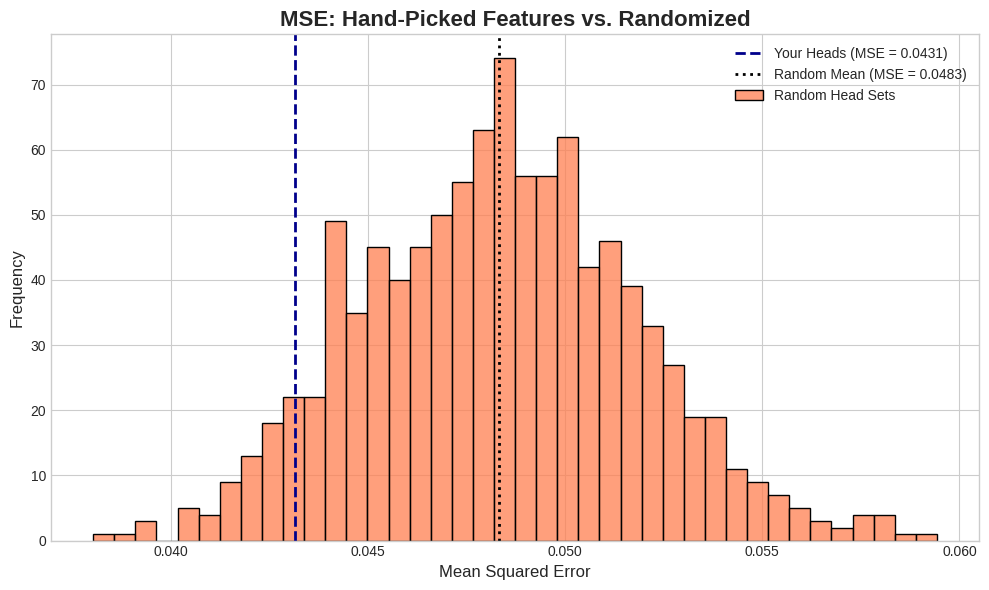


✅ Done.


In [37]:
import numpy as np
import os
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
TOP_FEATURES_PATH = "probe_features_top.npy"
LABELS_PATH = "probe_labels.npy"
PLOT_OUTPUT_PATH = "probe_mse_static_features.png"
NUM_TRIALS = 1000
RAND_FEATURE_TEMPLATE = "probe_features_rand_{:03d}.npy"

# --- Load Data ---
print("✅ Loading top features and labels...")
X = np.load(TOP_FEATURES_PATH)  # shape: [N, D]
y = np.load(LABELS_PATH)        # shape: [N]

print(f"📐 Feature shape: {X.shape}")
print(f"📊 Label shape:   {y.shape}")

# --- Train Ridge Regressor on Hand-Picked Heads ---
print("\n🎯 Training ridge regressor on your 10 selected heads...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

your_mse = mean_squared_error(y_test, y_pred)
print(f"🧠 MSE with hand-picked heads: {your_mse:.6f}")

# --- Evaluate MSE on Random Head Sets ---
print(f"\n🎲 Running {NUM_TRIALS} trials with real randomly sampled head sets...")
random_mse_list = []
missing_count = 0

for i in range(NUM_TRIALS):
    rand_path = RAND_FEATURE_TEMPLATE.format(i)
    if not os.path.exists(rand_path):
        print(f"⚠️ Missing file: {rand_path} — skipping.")
        missing_count += 1
        continue

    X_rand = np.load(rand_path)
    X_train, X_test, y_train, y_test = train_test_split(X_rand, y, test_size=0.2, random_state=42)

    model_rand = Ridge(alpha=1.0)
    model_rand.fit(X_train, y_train)
    y_pred_rand = model_rand.predict(X_test)

    mse = mean_squared_error(y_test, y_pred_rand)
    random_mse_list.append(mse)

if missing_count > 0:
    print(f"⚠️ Skipped {missing_count} trials due to missing files.")

# --- Metrics ---
random_mse_list = np.array(random_mse_list)
mean_random_mse = random_mse_list.mean()
percentile = np.mean(your_mse < random_mse_list) * 100

print("\n--- Results ---")
print(f"📌 Your MSE:         {your_mse:.6f}")
print(f"🎲 Mean Random MSE: {mean_random_mse:.6f}")
print(f"🏆 Percentile Rank:  {percentile:.1f}%")

# --- Plotting ---
print(f"\n📊 Saving plot to: {PLOT_OUTPUT_PATH}")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(random_mse_list, bins=40, color="coral", ax=ax, label="Random Head Sets")
ax.axvline(your_mse, color="darkblue", linestyle="--", linewidth=2,
           label=f"Your Heads (MSE = {your_mse:.4f})")
ax.axvline(mean_random_mse, color="black", linestyle=":", linewidth=2,
           label=f"Random Mean (MSE = {mean_random_mse:.4f})")

ax.set_title("MSE: Hand-Picked Features vs. Randomized", fontsize=16, fontweight="bold")
ax.set_xlabel("Mean Squared Error", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.legend()
fig.tight_layout()
plt.savefig(PLOT_OUTPUT_PATH)
plt.show()

print("\n✅ Done.")
